In [1]:
import pandas as pd
import numpy as np
import shap
import json
import pickle
from sklearn.manifold import TSNE
import optuna
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.utils import shuffle
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report, multilabel_confusion_matrix, f1_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier

In [2]:
# load dataset
df = pd.read_csv('../../../../datasets/atis_dataset_preprocessed.csv', sep=';')

In [3]:
# define label columns
label_columns = ['ILS', 'RNAV', 'RNP', 'VISUAL']

# list of all airport-dependent features to drop
airport_dependent = ['airport_icao', 'runway_designator_number', 'runway_designator_side', 'runway_ils_category']

# define features and targets
X = df.drop(columns=label_columns + airport_dependent)

# one-hot encode features that are categorical
X = pd.get_dummies(X, columns=['weather_phenomenon', 'rvr_tendency'])

In [4]:
y = df[label_columns]

In [5]:
# concat X and y for deduplication
combined = pd.concat([X, y], axis=1)

# drop duplicates
combined_no_dupes = combined.drop_duplicates()

# split back into features and labels
X = combined_no_dupes.drop(columns=label_columns)
y = combined_no_dupes[label_columns]

In [6]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

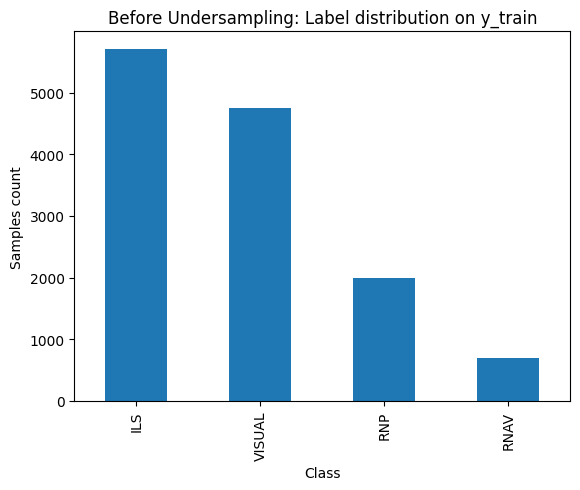

Label distribution:
 ILS       5705
VISUAL    4745
RNP       1992
RNAV       694
dtype: int64


In [7]:
# check for label distribution
label_counts = y_train.sum().sort_values(ascending=False)
label_counts.plot(kind='bar')
plt.title('Before Undersampling: Label distribution on y_train')
plt.xlabel('Class')
plt.ylabel('Samples count')
plt.show()

print("Label distribution:\n", label_counts)

In [8]:
# Combine X and y for downsampling
train_combined = pd.concat([X_train, y_train], axis=1)

# Find min label count in training data
min_count = y_train.sum().min()

# Sample equal number of rows for each label
balanced_parts = []

for label in label_columns:
    subset = train_combined[train_combined[label] == 1]
    sampled = subset.sample(n=min_count, random_state=42)
    balanced_parts.append(sampled)

# Merge, shuffle, split back to X/y
balanced_train = pd.concat(balanced_parts).drop_duplicates()
balanced_train = shuffle(balanced_train, random_state=42)

X_train_bal = balanced_train[X.columns]
y_train_bal = balanced_train[label_columns]

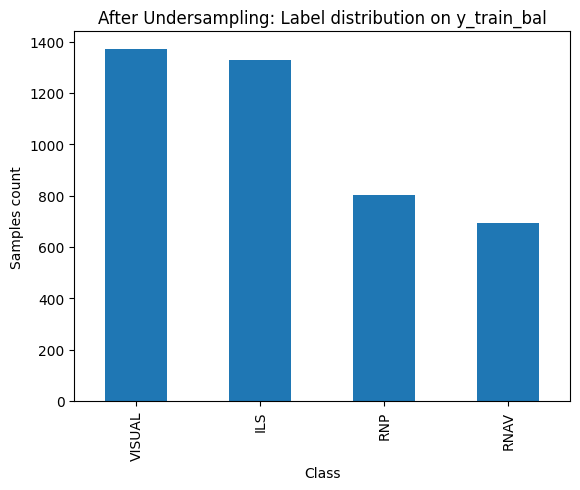

Label distribution:
 VISUAL    1371
ILS       1330
RNP        804
RNAV       694
dtype: int64


In [9]:
# check for label distribution after undersampling
label_counts = y_train_bal.sum().sort_values(ascending=False)
label_counts.plot(kind='bar')
plt.title('After Undersampling: Label distribution on y_train_bal')
plt.xlabel('Class')
plt.ylabel('Samples count')
plt.show()

print("Label distribution:\n", label_counts)

In [10]:
# build and train multi-label model + hyperparameter tuning
def objective(trial):
    # Each hyperparameter is sampled by Optuna using Bayesian optimization
    n_estimators = trial.suggest_int("n_estimators", 100, 500)
    max_depth = trial.suggest_int("max_depth", 5, 30)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 5)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", 0.5])
    bootstrap = trial.suggest_categorical("bootstrap", [True, False])

    # k-fold cv setup
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = []

    for train_idx, val_idx in kf.split(X_train_bal):
        X_train, X_val = X_train_bal.iloc[train_idx], X_train_bal.iloc[val_idx]
        y_train, y_val = y_train_bal.iloc[train_idx], y_train_bal.iloc[val_idx]
        
        model = OneVsRestClassifier(RandomForestClassifier(
            # eval_metric='logloss',
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            max_features=max_features,
            bootstrap=bootstrap
        ))
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)

        # F1 macro over all labels
        f1 = f1_score(y_val, y_pred, average='macro')
        scores.append(f1)

    return np.mean(scores)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=200, n_jobs=8)

[I 2025-06-15 14:10:39,675] A new study created in memory with name: no-name-e8b17694-25a7-453a-ac7f-5bb8393cb928
[I 2025-06-15 14:11:05,423] Trial 3 finished with value: 0.7911191903262798 and parameters: {'n_estimators': 102, 'max_depth': 27, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features': 0.5, 'bootstrap': True}. Best is trial 3 with value: 0.7911191903262798.
[I 2025-06-15 14:11:13,402] Trial 0 finished with value: 0.7785823706829227 and parameters: {'n_estimators': 134, 'max_depth': 26, 'min_samples_split': 7, 'min_samples_leaf': 4, 'max_features': 0.5, 'bootstrap': True}. Best is trial 3 with value: 0.7911191903262798.
[I 2025-06-15 14:11:18,450] Trial 2 finished with value: 0.6210907179261456 and parameters: {'n_estimators': 257, 'max_depth': 11, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 'log2', 'bootstrap': False}. Best is trial 3 with value: 0.7911191903262798.
[I 2025-06-15 14:11:22,261] Trial 1 finished with value: 0.7486796290726009 and p

[I 2025-05-20 05:58:38,327] Trial 0 finished with value: 0.8552254621378683 and parameters: {'n_estimators': 177, 'learning_rate': 0.148379413257216, 'max_depth': 4, 'subsample': 0.8345777608509345, 'colsample_bytree': 0.9961463560727013, 'gamma': 3.9247849405668638, 'reg_alpha': 0.3819088910711602, 'reg_lambda': 0.08396203747722841, 'min_child_weight': 1, 'scale_pos_weight': 20.350957250151712, 'max_delta_step': 2}. Best is trial 0 with value: 0.8552254621378683.


[I 2025-05-20 05:58:39,471] Trial 3 finished with value: 0.8381837337624465 and parameters: {'n_estimators': 179, 'learning_rate': 0.0696231586171996, 'max_depth': 4, 'subsample': 0.8168833456968058, 'colsample_bytree': 0.865450826713887, 'gamma': 2.6340895290204096, 'reg_alpha': 0.8233736292783645, 'reg_lambda': 0.1917223381885541, 'min_child_weight': 4, 'scale_pos_weight': 19.90986970023957, 'max_delta_step': 6}. Best is trial 0 with value: 0.8552254621378683.


[I 2025-05-20 05:58:39,548] Trial 5 finished with value: 0.8772791484239091 and parameters: {'n_estimators': 172, 'learning_rate': 0.10060897637676813, 'max_depth': 8, 'subsample': 0.9812785566163937, 'colsample_bytree': 0.9717801600023332, 'gamma': 1.8807496872040375, 'reg_alpha': 0.045210410912211674, 'reg_lambda': 0.19303984750143988, 'min_child_weight': 3, 'scale_pos_weight': 10.680435608290585, 'max_delta_step': 4}. Best is trial 5 with value: 0.8772791484239091.


[I 2025-05-20 05:58:39,882] Trial 1 finished with value: 0.824634599277102 and parameters: {'n_estimators': 141, 'learning_rate': 0.022790745971427034, 'max_depth': 6, 'subsample': 0.9677183689511875, 'colsample_bytree': 0.8403031516174148, 'gamma': 3.6240006811631424, 'reg_alpha': 0.0697883712099795, 'reg_lambda': 0.922426611950301, 'min_child_weight': 4, 'scale_pos_weight': 28.43300270511875, 'max_delta_step': 7}. Best is trial 5 with value: 0.8772791484239091.


[I 2025-05-20 05:58:44,551] Trial 7 finished with value: 0.8576510000310149 and parameters: {'n_estimators': 168, 'learning_rate': 0.02859097792142907, 'max_depth': 7, 'subsample': 0.8246979913912933, 'colsample_bytree': 0.754209880847809, 'gamma': 2.307432982039146, 'reg_alpha': 0.4628231131382552, 'reg_lambda': 0.8898370346790638, 'min_child_weight': 3, 'scale_pos_weight': 13.489437387503626, 'max_delta_step': 7}. Best is trial 5 with value: 0.8772791484239091.


[I 2025-05-20 05:58:45,299] Trial 6 finished with value: 0.8750965924865444 and parameters: {'n_estimators': 142, 'learning_rate': 0.08909987855470713, 'max_depth': 10, 'subsample': 0.7944865406014401, 'colsample_bytree': 0.7642190591901858, 'gamma': 0.9119601945598094, 'reg_alpha': 0.09019858748960385, 'reg_lambda': 0.4299300754169618, 'min_child_weight': 5, 'scale_pos_weight': 35.85331816268308, 'max_delta_step': 2}. Best is trial 5 with value: 0.8772791484239091.


[I 2025-05-20 05:58:49,926] Trial 2 finished with value: 0.8878646112453981 and parameters: {'n_estimators': 227, 'learning_rate': 0.2315832133690513, 'max_depth': 7, 'subsample': 0.8040532851949278, 'colsample_bytree': 0.7406981594034543, 'gamma': 0.5367195745086006, 'reg_alpha': 0.1293794843640197, 'reg_lambda': 0.5456326709565025, 'min_child_weight': 2, 'scale_pos_weight': 30.375136398459613, 'max_delta_step': 6}. Best is trial 2 with value: 0.8878646112453981.


[I 2025-05-20 05:58:53,598] Trial 9 finished with value: 0.8798210286389331 and parameters: {'n_estimators': 186, 'learning_rate': 0.11689523862668552, 'max_depth': 5, 'subsample': 0.9337105986020248, 'colsample_bytree': 0.8399656821190924, 'gamma': 3.7900442598285986, 'reg_alpha': 0.6023834224350845, 'reg_lambda': 0.4215275766048876, 'min_child_weight': 4, 'scale_pos_weight': 4.324245557996239, 'max_delta_step': 3}. Best is trial 2 with value: 0.8878646112453981.


[I 2025-05-20 05:58:54,262] Trial 8 finished with value: 0.8505503447051511 and parameters: {'n_estimators': 154, 'learning_rate': 0.10754735512543973, 'max_depth': 5, 'subsample': 0.9541448205243299, 'colsample_bytree': 0.7450995465187077, 'gamma': 1.842296935501857, 'reg_alpha': 0.929072247317406, 'reg_lambda': 0.745935968785853, 'min_child_weight': 4, 'scale_pos_weight': 24.296539253538732, 'max_delta_step': 9}. Best is trial 2 with value: 0.8878646112453981.


[I 2025-05-20 05:58:54,574] Trial 10 finished with value: 0.7852026237913539 and parameters: {'n_estimators': 175, 'learning_rate': 0.057471457084354714, 'max_depth': 3, 'subsample': 0.9142037590651522, 'colsample_bytree': 0.8605658664818375, 'gamma': 3.160945234851903, 'reg_alpha': 0.7437832553762853, 'reg_lambda': 0.9163413657018888, 'min_child_weight': 3, 'scale_pos_weight': 38.78594588239736, 'max_delta_step': 2}. Best is trial 2 with value: 0.8878646112453981.


[I 2025-05-20 05:58:54,840] Trial 4 finished with value: 0.8791663574216285 and parameters: {'n_estimators': 298, 'learning_rate': 0.1499807299343944, 'max_depth': 6, 'subsample': 0.9727361719245006, 'colsample_bytree': 0.901811287131099, 'gamma': 0.2995039286378659, 'reg_alpha': 0.20323719192729872, 'reg_lambda': 0.5413379057954533, 'min_child_weight': 2, 'scale_pos_weight': 37.56002468412139, 'max_delta_step': 1}. Best is trial 2 with value: 0.8878646112453981.


[I 2025-05-20 05:59:02,686] Trial 11 finished with value: 0.8661009040680187 and parameters: {'n_estimators': 204, 'learning_rate': 0.0659085778205633, 'max_depth': 8, 'subsample': 0.7615853722121282, 'colsample_bytree': 0.7544576330641177, 'gamma': 4.831227510800462, 'reg_alpha': 0.24561643693687485, 'reg_lambda': 0.9636283326755035, 'min_child_weight': 4, 'scale_pos_weight': 16.926906508558115, 'max_delta_step': 2}. Best is trial 2 with value: 0.8878646112453981.


[I 2025-05-20 05:59:04,302] Trial 12 finished with value: 0.8117079933673699 and parameters: {'n_estimators': 205, 'learning_rate': 0.042016357825786, 'max_depth': 4, 'subsample': 0.8555313202191112, 'colsample_bytree': 0.7119460057289391, 'gamma': 2.3108984177889984, 'reg_alpha': 0.1384431049190541, 'reg_lambda': 0.15056129095328918, 'min_child_weight': 2, 'scale_pos_weight': 32.61731138267814, 'max_delta_step': 6}. Best is trial 2 with value: 0.8878646112453981.


[I 2025-05-20 05:59:06,491] Trial 13 finished with value: 0.8471206227989748 and parameters: {'n_estimators': 222, 'learning_rate': 0.02252818672459221, 'max_depth': 4, 'subsample': 0.7450368795365638, 'colsample_bytree': 0.741384771747201, 'gamma': 3.6877623421898074, 'reg_alpha': 0.2598065998746639, 'reg_lambda': 0.9928080961292742, 'min_child_weight': 2, 'scale_pos_weight': 7.919284384318825, 'max_delta_step': 4}. Best is trial 2 with value: 0.8878646112453981.


[I 2025-05-20 05:59:07,637] Trial 18 finished with value: 0.883700348709062 and parameters: {'n_estimators': 231, 'learning_rate': 0.2961930184115601, 'max_depth': 8, 'subsample': 0.7270289641945821, 'colsample_bytree': 0.7013881975610999, 'gamma': 4.973554526340966, 'reg_alpha': 0.6282686612657356, 'reg_lambda': 0.4555850712968543, 'min_child_weight': 1, 'scale_pos_weight': 1.1672455141908857, 'max_delta_step': 4}. Best is trial 2 with value: 0.8878646112453981.


[I 2025-05-20 05:59:11,412] Trial 14 finished with value: 0.864669375598979 and parameters: {'n_estimators': 226, 'learning_rate': 0.08961678534957436, 'max_depth': 8, 'subsample': 0.8453852798776356, 'colsample_bytree': 0.9137711820320891, 'gamma': 4.687337804818124, 'reg_alpha': 0.25985497653928824, 'reg_lambda': 0.715663739080728, 'min_child_weight': 4, 'scale_pos_weight': 23.281388143025797, 'max_delta_step': 3}. Best is trial 2 with value: 0.8878646112453981.


[I 2025-05-20 05:59:18,054] Trial 20 finished with value: 0.8886545708159719 and parameters: {'n_estimators': 250, 'learning_rate': 0.2644241520035778, 'max_depth': 8, 'subsample': 0.7177543477614935, 'colsample_bytree': 0.8066837410569818, 'gamma': 4.682919908842472, 'reg_alpha': 0.6352652576053076, 'reg_lambda': 0.43633260990046835, 'min_child_weight': 1, 'scale_pos_weight': 1.1762243228218328, 'max_delta_step': 10}. Best is trial 20 with value: 0.8886545708159719.


[I 2025-05-20 05:59:18,326] Trial 15 finished with value: 0.877873814529259 and parameters: {'n_estimators': 145, 'learning_rate': 0.03840645550146554, 'max_depth': 10, 'subsample': 0.7995187734960733, 'colsample_bytree': 0.9347084898346054, 'gamma': 0.5609952541784907, 'reg_alpha': 0.20905522200984428, 'reg_lambda': 0.09970251725339463, 'min_child_weight': 1, 'scale_pos_weight': 15.343948227662906, 'max_delta_step': 5}. Best is trial 20 with value: 0.8886545708159719.


[I 2025-05-20 05:59:20,517] Trial 21 finished with value: 0.8876345222546982 and parameters: {'n_estimators': 243, 'learning_rate': 0.242950847217667, 'max_depth': 8, 'subsample': 0.8725094451844752, 'colsample_bytree': 0.803666163101722, 'gamma': 4.856945130560842, 'reg_alpha': 0.6159531070319615, 'reg_lambda': 0.45428025739739797, 'min_child_weight': 1, 'scale_pos_weight': 3.337092071958585, 'max_delta_step': 10}. Best is trial 20 with value: 0.8886545708159719.


[I 2025-05-20 05:59:21,116] Trial 19 finished with value: 0.901033417494449 and parameters: {'n_estimators': 241, 'learning_rate': 0.21128880507309886, 'max_depth': 9, 'subsample': 0.8916017459307259, 'colsample_bytree': 0.7003704771457852, 'gamma': 1.0575575138224655, 'reg_alpha': 0.6054901486907746, 'reg_lambda': 0.48954931454181205, 'min_child_weight': 1, 'scale_pos_weight': 1.4242014315562872, 'max_delta_step': 4}. Best is trial 19 with value: 0.901033417494449.


[I 2025-05-20 05:59:21,964] Trial 16 finished with value: 0.8455960465859926 and parameters: {'n_estimators': 177, 'learning_rate': 0.015378306814530805, 'max_depth': 9, 'subsample': 0.7211265422914157, 'colsample_bytree': 0.7355268987660226, 'gamma': 1.7492040645024187, 'reg_alpha': 0.6579034154140659, 'reg_lambda': 0.26958791191313347, 'min_child_weight': 2, 'scale_pos_weight': 36.7648692793838, 'max_delta_step': 3}. Best is trial 19 with value: 0.901033417494449.


[I 2025-05-20 05:59:32,327] Trial 17 finished with value: 0.8887327094005728 and parameters: {'n_estimators': 256, 'learning_rate': 0.2643087820085915, 'max_depth': 9, 'subsample': 0.7480689042502923, 'colsample_bytree': 0.7216925757171181, 'gamma': 0.006847134111588549, 'reg_alpha': 0.3191076863500282, 'reg_lambda': 0.6296167297278473, 'min_child_weight': 1, 'scale_pos_weight': 31.206664362288308, 'max_delta_step': 0}. Best is trial 19 with value: 0.901033417494449.


[I 2025-05-20 05:59:39,614] Trial 23 finished with value: 0.8982791390594821 and parameters: {'n_estimators': 262, 'learning_rate': 0.28390210194601495, 'max_depth': 10, 'subsample': 0.7070716234942062, 'colsample_bytree': 0.7983158408415502, 'gamma': 0.9949101926345008, 'reg_alpha': 0.6108331395282142, 'reg_lambda': 0.5994775723457068, 'min_child_weight': 1, 'scale_pos_weight': 2.192845319333485, 'max_delta_step': 9}. Best is trial 19 with value: 0.901033417494449.


[I 2025-05-20 05:59:42,136] Trial 22 finished with value: 0.8901290538206693 and parameters: {'n_estimators': 249, 'learning_rate': 0.2971561792480199, 'max_depth': 10, 'subsample': 0.7144385588850565, 'colsample_bytree': 0.7012263580486342, 'gamma': 0.9693838167228401, 'reg_alpha': 0.6435542804790042, 'reg_lambda': 0.6079321960236572, 'min_child_weight': 1, 'scale_pos_weight': 28.058955291073353, 'max_delta_step': 10}. Best is trial 19 with value: 0.901033417494449.


[I 2025-05-20 05:59:42,978] Trial 28 finished with value: 0.8938966182300174 and parameters: {'n_estimators': 266, 'learning_rate': 0.20986596071071317, 'max_depth': 9, 'subsample': 0.8961826832283373, 'colsample_bytree': 0.7920448195369316, 'gamma': 1.154447038815292, 'reg_alpha': 0.48058583391177356, 'reg_lambda': 0.5625486123082242, 'min_child_weight': 1, 'scale_pos_weight': 7.194353051127482, 'max_delta_step': 8}. Best is trial 19 with value: 0.901033417494449.


[I 2025-05-20 05:59:52,735] Trial 26 finished with value: 0.8874459976069053 and parameters: {'n_estimators': 265, 'learning_rate': 0.20313336015636838, 'max_depth': 9, 'subsample': 0.7067397657463326, 'colsample_bytree': 0.7929056379164463, 'gamma': 1.3425948228185374, 'reg_alpha': 0.3926962881049476, 'reg_lambda': 0.5971803913469426, 'min_child_weight': 2, 'scale_pos_weight': 28.724764129761862, 'max_delta_step': 9}. Best is trial 19 with value: 0.901033417494449.


[I 2025-05-20 05:59:57,016] Trial 25 finished with value: 0.8543320879099898 and parameters: {'n_estimators': 274, 'learning_rate': 0.012756665567041556, 'max_depth': 9, 'subsample': 0.7000090092855162, 'colsample_bytree': 0.80666076368214, 'gamma': 1.4253412673256771, 'reg_alpha': 0.4038661229099612, 'reg_lambda': 0.3150913110415937, 'min_child_weight': 2, 'scale_pos_weight': 29.841154066935477, 'max_delta_step': 10}. Best is trial 19 with value: 0.901033417494449.


[I 2025-05-20 05:59:58,246] Trial 27 finished with value: 0.8770734018883483 and parameters: {'n_estimators': 271, 'learning_rate': 0.011803861295973288, 'max_depth': 9, 'subsample': 0.8961461074361629, 'colsample_bytree': 0.7972467384425477, 'gamma': 1.272045286251272, 'reg_alpha': 0.7366621803600422, 'reg_lambda': 0.28716740866023066, 'min_child_weight': 1, 'scale_pos_weight': 7.692467863822774, 'max_delta_step': 0}. Best is trial 19 with value: 0.901033417494449.


[I 2025-05-20 05:59:58,503] Trial 24 finished with value: 0.8631341765532676 and parameters: {'n_estimators': 261, 'learning_rate': 0.011884067435541155, 'max_depth': 10, 'subsample': 0.706467478860545, 'colsample_bytree': 0.7935048925466947, 'gamma': 1.068248856831144, 'reg_alpha': 0.3807752984751377, 'reg_lambda': 0.30694611368311625, 'min_child_weight': 1, 'scale_pos_weight': 27.06547370850246, 'max_delta_step': 10}. Best is trial 19 with value: 0.901033417494449.


[I 2025-05-20 06:00:02,480] Trial 29 finished with value: 0.8963746504104317 and parameters: {'n_estimators': 265, 'learning_rate': 0.18536832455134533, 'max_depth': 9, 'subsample': 0.7021906539245438, 'colsample_bytree': 0.7931039713086914, 'gamma': 1.0381658418554534, 'reg_alpha': 0.40647705247811383, 'reg_lambda': 0.6793960815308844, 'min_child_weight': 1, 'scale_pos_weight': 4.8844231305063985, 'max_delta_step': 0}. Best is trial 19 with value: 0.901033417494449.


[I 2025-05-20 06:00:05,475] Trial 32 finished with value: 0.8918816766063514 and parameters: {'n_estimators': 279, 'learning_rate': 0.17717267522528382, 'max_depth': 9, 'subsample': 0.8906794064325919, 'colsample_bytree': 0.7869948350462996, 'gamma': 1.337298660958546, 'reg_alpha': 0.5038167428947715, 'reg_lambda': 0.3410229557502664, 'min_child_weight': 2, 'scale_pos_weight': 7.632447634145179, 'max_delta_step': 8}. Best is trial 19 with value: 0.901033417494449.


[I 2025-05-20 06:00:15,513] Trial 30 finished with value: 0.8965557278504456 and parameters: {'n_estimators': 266, 'learning_rate': 0.1832823977956512, 'max_depth': 9, 'subsample': 0.8894268747454633, 'colsample_bytree': 0.78855850087287, 'gamma': 0.008781159450628807, 'reg_alpha': 0.39455484795672074, 'reg_lambda': 0.6500284714638696, 'min_child_weight': 1, 'scale_pos_weight': 7.526482506310567, 'max_delta_step': 0}. Best is trial 19 with value: 0.901033417494449.


[I 2025-05-20 06:00:15,885] Trial 33 finished with value: 0.8933289522868503 and parameters: {'n_estimators': 275, 'learning_rate': 0.16965050692623035, 'max_depth': 9, 'subsample': 0.8911111020965053, 'colsample_bytree': 0.7861675471040304, 'gamma': 1.3065226883989376, 'reg_alpha': 0.48100005397306955, 'reg_lambda': 0.33271229534568314, 'min_child_weight': 1, 'scale_pos_weight': 7.260375687903995, 'max_delta_step': 8}. Best is trial 19 with value: 0.901033417494449.


[I 2025-05-20 06:00:16,374] Trial 31 finished with value: 0.8931292450877703 and parameters: {'n_estimators': 277, 'learning_rate': 0.17847696023684903, 'max_depth': 10, 'subsample': 0.7000303714387939, 'colsample_bytree': 0.7947627572309829, 'gamma': 1.144989263300901, 'reg_alpha': 0.4971787124000157, 'reg_lambda': 0.3319912326740262, 'min_child_weight': 1, 'scale_pos_weight': 7.2489827276699685, 'max_delta_step': 8}. Best is trial 19 with value: 0.901033417494449.


[I 2025-05-20 06:00:23,963] Trial 34 finished with value: 0.8957883837986174 and parameters: {'n_estimators': 288, 'learning_rate': 0.1739305549573189, 'max_depth': 10, 'subsample': 0.8879334526368488, 'colsample_bytree': 0.7774353072235565, 'gamma': 1.0005851569674207, 'reg_alpha': 0.5322615173049979, 'reg_lambda': 0.7392449995031459, 'min_child_weight': 1, 'scale_pos_weight': 7.44457966307338, 'max_delta_step': 8}. Best is trial 19 with value: 0.901033417494449.


[I 2025-05-20 06:00:27,292] Trial 35 finished with value: 0.8961468517690967 and parameters: {'n_estimators': 293, 'learning_rate': 0.17384126640660183, 'max_depth': 10, 'subsample': 0.8732590187678958, 'colsample_bytree': 0.7777088749583758, 'gamma': 0.8977775798821399, 'reg_alpha': 0.5491271839211083, 'reg_lambda': 0.729205937442905, 'min_child_weight': 1, 'scale_pos_weight': 5.880719939905246, 'max_delta_step': 8}. Best is trial 19 with value: 0.901033417494449.


[I 2025-05-20 06:00:29,372] Trial 41 finished with value: 0.893461168907848 and parameters: {'n_estimators': 104, 'learning_rate': 0.12112187826017447, 'max_depth': 7, 'subsample': 0.7772437228570047, 'colsample_bytree': 0.8312709571078256, 'gamma': 0.6250392459663883, 'reg_alpha': 0.5589183175350271, 'reg_lambda': 0.6875834883847652, 'min_child_weight': 1, 'scale_pos_weight': 3.574419628772387, 'max_delta_step': 1}. Best is trial 19 with value: 0.901033417494449.


[I 2025-05-20 06:00:30,914] Trial 36 finished with value: 0.896866862049027 and parameters: {'n_estimators': 290, 'learning_rate': 0.18046008326132978, 'max_depth': 10, 'subsample': 0.885003775419663, 'colsample_bytree': 0.780282178121825, 'gamma': 0.6467197394423272, 'reg_alpha': 0.5050635153120451, 'reg_lambda': 0.7581600934383014, 'min_child_weight': 1, 'scale_pos_weight': 6.735612152156762, 'max_delta_step': 8}. Best is trial 19 with value: 0.901033417494449.


[I 2025-05-20 06:00:32,639] Trial 39 finished with value: 0.8974373970231696 and parameters: {'n_estimators': 104, 'learning_rate': 0.14823152799766096, 'max_depth': 10, 'subsample': 0.7687212253441053, 'colsample_bytree': 0.8266656566038969, 'gamma': 0.04891029102770361, 'reg_alpha': 0.5308194484698888, 'reg_lambda': 0.7305821146746948, 'min_child_weight': 1, 'scale_pos_weight': 4.476885336313519, 'max_delta_step': 1}. Best is trial 19 with value: 0.901033417494449.


[I 2025-05-20 06:00:33,273] Trial 40 finished with value: 0.8986723029360963 and parameters: {'n_estimators': 117, 'learning_rate': 0.1367526563790699, 'max_depth': 10, 'subsample': 0.930179750815395, 'colsample_bytree': 0.8313239331273886, 'gamma': 0.6300552506837664, 'reg_alpha': 0.5628473014445745, 'reg_lambda': 0.7074033108820122, 'min_child_weight': 1, 'scale_pos_weight': 4.170501710484226, 'max_delta_step': 1}. Best is trial 19 with value: 0.901033417494449.


[I 2025-05-20 06:00:38,088] Trial 42 finished with value: 0.8923487929288353 and parameters: {'n_estimators': 114, 'learning_rate': 0.1402172194456533, 'max_depth': 7, 'subsample': 0.774963734620661, 'colsample_bytree': 0.8270095562613928, 'gamma': 0.5710600420532743, 'reg_alpha': 0.5448836742753351, 'reg_lambda': 0.6712741469048172, 'min_child_weight': 2, 'scale_pos_weight': 4.37673818242616, 'max_delta_step': 1}. Best is trial 19 with value: 0.901033417494449.


[I 2025-05-20 06:00:41,036] Trial 43 finished with value: 0.8754038381965052 and parameters: {'n_estimators': 103, 'learning_rate': 0.12011931097184866, 'max_depth': 7, 'subsample': 0.7774491304193623, 'colsample_bytree': 0.8308356678263457, 'gamma': 0.5905316088789497, 'reg_alpha': 0.7909720345950553, 'reg_lambda': 0.8183412635279163, 'min_child_weight': 2, 'scale_pos_weight': 10.501255898744258, 'max_delta_step': 1}. Best is trial 19 with value: 0.901033417494449.


[I 2025-05-20 06:00:42,030] Trial 37 finished with value: 0.8932122210837958 and parameters: {'n_estimators': 288, 'learning_rate': 0.15797086812926525, 'max_depth': 10, 'subsample': 0.7735723110228734, 'colsample_bytree': 0.8253815605150284, 'gamma': 0.7096207744070893, 'reg_alpha': 0.540320385991552, 'reg_lambda': 0.7113697016851039, 'min_child_weight': 3, 'scale_pos_weight': 11.413158660732066, 'max_delta_step': 1}. Best is trial 19 with value: 0.901033417494449.


[I 2025-05-20 06:00:43,569] Trial 38 finished with value: 0.8984901024433111 and parameters: {'n_estimators': 288, 'learning_rate': 0.15897314380581215, 'max_depth': 10, 'subsample': 0.7706981881345416, 'colsample_bytree': 0.8229551151837882, 'gamma': 0.6704490427146201, 'reg_alpha': 0.5303720064926081, 'reg_lambda': 0.7223988013964822, 'min_child_weight': 1, 'scale_pos_weight': 4.698144342731112, 'max_delta_step': 8}. Best is trial 19 with value: 0.901033417494449.


[I 2025-05-20 06:00:49,614] Trial 47 finished with value: 0.8881240164076931 and parameters: {'n_estimators': 104, 'learning_rate': 0.13640630719421487, 'max_depth': 10, 'subsample': 0.9457795746404392, 'colsample_bytree': 0.8826279228145024, 'gamma': 0.37325392483234376, 'reg_alpha': 0.7196127573321278, 'reg_lambda': 0.8384639493424514, 'min_child_weight': 2, 'scale_pos_weight': 9.917797883743443, 'max_delta_step': 1}. Best is trial 19 with value: 0.901033417494449.


[I 2025-05-20 06:00:55,715] Trial 44 finished with value: 0.8858458404109623 and parameters: {'n_estimators': 236, 'learning_rate': 0.1371425534281575, 'max_depth': 7, 'subsample': 0.940705180193038, 'colsample_bytree': 0.8226820397753117, 'gamma': 0.07895039068489161, 'reg_alpha': 0.6904992132185587, 'reg_lambda': 0.7854953651668385, 'min_child_weight': 5, 'scale_pos_weight': 10.856074485720228, 'max_delta_step': 1}. Best is trial 19 with value: 0.901033417494449.


[I 2025-05-20 06:00:56,421] Trial 48 finished with value: 0.8912960164818754 and parameters: {'n_estimators': 123, 'learning_rate': 0.15029428907040973, 'max_depth': 10, 'subsample': 0.92986562470097, 'colsample_bytree': 0.8210385361762115, 'gamma': 0.21485207084668956, 'reg_alpha': 0.7162736407128311, 'reg_lambda': 0.8109643531923785, 'min_child_weight': 2, 'scale_pos_weight': 10.93368318818127, 'max_delta_step': 7}. Best is trial 19 with value: 0.901033417494449.


[I 2025-05-20 06:00:59,703] Trial 49 finished with value: 0.8904912829404428 and parameters: {'n_estimators': 124, 'learning_rate': 0.14423912279239792, 'max_depth': 10, 'subsample': 0.9305958070010958, 'colsample_bytree': 0.887247161537261, 'gamma': 0.2215889765909167, 'reg_alpha': 0.7079879730167558, 'reg_lambda': 0.8136707464054798, 'min_child_weight': 2, 'scale_pos_weight': 12.319579004380532, 'max_delta_step': 7}. Best is trial 19 with value: 0.901033417494449.


[I 2025-05-20 06:01:00,220] Trial 51 finished with value: 0.8990551211755342 and parameters: {'n_estimators': 116, 'learning_rate': 0.1358677893761814, 'max_depth': 10, 'subsample': 0.945924561705722, 'colsample_bytree': 0.8736099375519921, 'gamma': 0.3354439356899134, 'reg_alpha': 0.6825382548639517, 'reg_lambda': 0.8491796166781203, 'min_child_weight': 5, 'scale_pos_weight': 2.7628085033661023, 'max_delta_step': 7}. Best is trial 19 with value: 0.901033417494449.


[I 2025-05-20 06:01:00,803] Trial 50 finished with value: 0.9027162933885486 and parameters: {'n_estimators': 133, 'learning_rate': 0.22414518204269374, 'max_depth': 10, 'subsample': 0.9423456121257553, 'colsample_bytree': 0.880959924829551, 'gamma': 0.22489317271729392, 'reg_alpha': 0.7010697854989973, 'reg_lambda': 0.8087066486441423, 'min_child_weight': 2, 'scale_pos_weight': 2.081338122393351, 'max_delta_step': 7}. Best is trial 50 with value: 0.9027162933885486.


[I 2025-05-20 06:01:04,257] Trial 45 finished with value: 0.8898260725463618 and parameters: {'n_estimators': 300, 'learning_rate': 0.12655304686481603, 'max_depth': 7, 'subsample': 0.9233912242516582, 'colsample_bytree': 0.8243352351112333, 'gamma': 0.005171120741565893, 'reg_alpha': 0.718567830162674, 'reg_lambda': 0.7943461778906762, 'min_child_weight': 3, 'scale_pos_weight': 11.007242005947848, 'max_delta_step': 7}. Best is trial 50 with value: 0.9027162933885486.


[I 2025-05-20 06:01:08,251] Trial 52 finished with value: 0.9020451898880234 and parameters: {'n_estimators': 122, 'learning_rate': 0.0816827672410267, 'max_depth': 10, 'subsample': 0.9935907736786549, 'colsample_bytree': 0.8547507532056934, 'gamma': 0.27087850680886516, 'reg_alpha': 0.5863982964877659, 'reg_lambda': 0.5297951439406713, 'min_child_weight': 3, 'scale_pos_weight': 1.5919812693608888, 'max_delta_step': 7}. Best is trial 50 with value: 0.9027162933885486.


[I 2025-05-20 06:01:12,868] Trial 46 finished with value: 0.8953698666386118 and parameters: {'n_estimators': 300, 'learning_rate': 0.14512960770437, 'max_depth': 10, 'subsample': 0.929234640659345, 'colsample_bytree': 0.8300689418237198, 'gamma': 0.32619936516389325, 'reg_alpha': 0.7141124649415755, 'reg_lambda': 0.5121444413869414, 'min_child_weight': 2, 'scale_pos_weight': 11.334986899146898, 'max_delta_step': 7}. Best is trial 50 with value: 0.9027162933885486.


[I 2025-05-20 06:01:13,434] Trial 54 finished with value: 0.8994504703932732 and parameters: {'n_estimators': 119, 'learning_rate': 0.08072292421521504, 'max_depth': 10, 'subsample': 0.8099368739214002, 'colsample_bytree': 0.8521396080828477, 'gamma': 1.5818777927102157, 'reg_alpha': 0.8543576422538972, 'reg_lambda': 0.5205059554282796, 'min_child_weight': 1, 'scale_pos_weight': 2.5134774960154447, 'max_delta_step': 5}. Best is trial 50 with value: 0.9027162933885486.


[I 2025-05-20 06:01:15,689] Trial 53 finished with value: 0.9030188012713619 and parameters: {'n_estimators': 127, 'learning_rate': 0.07255195114354406, 'max_depth': 10, 'subsample': 0.9269700544447959, 'colsample_bytree': 0.8552074269561898, 'gamma': 0.30888513530002826, 'reg_alpha': 0.9557648366282988, 'reg_lambda': 0.5379602408949772, 'min_child_weight': 3, 'scale_pos_weight': 2.1320644193011056, 'max_delta_step': 7}. Best is trial 53 with value: 0.9030188012713619.


[I 2025-05-20 06:01:16,287] Trial 57 finished with value: 0.8888805431391272 and parameters: {'n_estimators': 161, 'learning_rate': 0.07620691997538333, 'max_depth': 6, 'subsample': 0.9954181513856286, 'colsample_bytree': 0.8542014415390284, 'gamma': 1.5777476936371522, 'reg_alpha': 0.8698941096389852, 'reg_lambda': 0.8847619806552401, 'min_child_weight': 5, 'scale_pos_weight': 2.5512289869097535, 'max_delta_step': 6}. Best is trial 53 with value: 0.9030188012713619.


[I 2025-05-20 06:01:17,200] Trial 55 finished with value: 0.8922366171727452 and parameters: {'n_estimators': 214, 'learning_rate': 0.08077586996213561, 'max_depth': 6, 'subsample': 0.9992861791199665, 'colsample_bytree': 0.854172034887662, 'gamma': 1.6144107412620377, 'reg_alpha': 0.8799281929114763, 'reg_lambda': 0.5188543828352272, 'min_child_weight': 1, 'scale_pos_weight': 2.1397918610232454, 'max_delta_step': 9}. Best is trial 53 with value: 0.9030188012713619.


[I 2025-05-20 06:01:18,230] Trial 56 finished with value: 0.8916610470663804 and parameters: {'n_estimators': 217, 'learning_rate': 0.0853107473626639, 'max_depth': 6, 'subsample': 0.9618174837643753, 'colsample_bytree': 0.8509330416387499, 'gamma': 1.6156010469127302, 'reg_alpha': 0.8592253877590807, 'reg_lambda': 0.5038531765415281, 'min_child_weight': 5, 'scale_pos_weight': 2.4385806009716924, 'max_delta_step': 6}. Best is trial 53 with value: 0.9030188012713619.


[I 2025-05-20 06:01:21,259] Trial 58 finished with value: 0.8999410095841304 and parameters: {'n_estimators': 134, 'learning_rate': 0.22178450215940684, 'max_depth': 10, 'subsample': 0.9623355866774366, 'colsample_bytree': 0.8545211836370998, 'gamma': 0.3789390755769883, 'reg_alpha': 0.8008714891116222, 'reg_lambda': 0.512889413341958, 'min_child_weight': 5, 'scale_pos_weight': 2.449694244812907, 'max_delta_step': 6}. Best is trial 53 with value: 0.9030188012713619.


[I 2025-05-20 06:01:26,085] Trial 61 finished with value: 0.8861335541012874 and parameters: {'n_estimators': 134, 'learning_rate': 0.07561535149926962, 'max_depth': 5, 'subsample': 0.9850307368355005, 'colsample_bytree': 0.9316736179391307, 'gamma': 2.7382712632371313, 'reg_alpha': 0.9263167914069833, 'reg_lambda': 0.8942787681976487, 'min_child_weight': 5, 'scale_pos_weight': 2.101697568520376, 'max_delta_step': 5}. Best is trial 53 with value: 0.9030188012713619.


[I 2025-05-20 06:01:27,516] Trial 60 finished with value: 0.8928808416559303 and parameters: {'n_estimators': 130, 'learning_rate': 0.07683932101958703, 'max_depth': 6, 'subsample': 0.9912249982879385, 'colsample_bytree': 0.8540094198723834, 'gamma': 0.7908562816845508, 'reg_alpha': 0.8819535900000879, 'reg_lambda': 0.87668246374086, 'min_child_weight': 4, 'scale_pos_weight': 2.223448838456935, 'max_delta_step': 6}. Best is trial 53 with value: 0.9030188012713619.


[I 2025-05-20 06:01:28,285] Trial 59 finished with value: 0.8986170157841077 and parameters: {'n_estimators': 134, 'learning_rate': 0.07724104494008933, 'max_depth': 10, 'subsample': 0.9997452082892594, 'colsample_bytree': 0.8565136446445674, 'gamma': 0.3699347351259051, 'reg_alpha': 0.8695452572791867, 'reg_lambda': 0.85440148599411, 'min_child_weight': 5, 'scale_pos_weight': 2.549376038351787, 'max_delta_step': 6}. Best is trial 53 with value: 0.9030188012713619.


[I 2025-05-20 06:01:29,983] Trial 62 finished with value: 0.8898852499761855 and parameters: {'n_estimators': 133, 'learning_rate': 0.0761008832403693, 'max_depth': 6, 'subsample': 0.9643438812315627, 'colsample_bytree': 0.8577069828410675, 'gamma': 1.6409635963225928, 'reg_alpha': 0.9978915319519941, 'reg_lambda': 0.8708193278227906, 'min_child_weight': 5, 'scale_pos_weight': 2.4432311665609503, 'max_delta_step': 6}. Best is trial 53 with value: 0.9030188012713619.


[I 2025-05-20 06:01:33,048] Trial 64 finished with value: 0.8944087538873744 and parameters: {'n_estimators': 136, 'learning_rate': 0.05856524041824509, 'max_depth': 9, 'subsample': 0.9632790323250364, 'colsample_bytree': 0.8733834611246455, 'gamma': 2.4107585487548735, 'reg_alpha': 0.9996003987011856, 'reg_lambda': 0.5597467365701816, 'min_child_weight': 3, 'scale_pos_weight': 1.5928528686198504, 'max_delta_step': 5}. Best is trial 53 with value: 0.9030188012713619.


[I 2025-05-20 06:01:33,514] Trial 63 finished with value: 0.8925532695454017 and parameters: {'n_estimators': 134, 'learning_rate': 0.050286172788825856, 'max_depth': 9, 'subsample': 0.962954002351251, 'colsample_bytree': 0.8721603279664828, 'gamma': 2.7428313842787677, 'reg_alpha': 0.8842166246525197, 'reg_lambda': 0.5042631297121112, 'min_child_weight': 4, 'scale_pos_weight': 2.6441000573681634, 'max_delta_step': 5}. Best is trial 53 with value: 0.9030188012713619.


[I 2025-05-20 06:01:34,745] Trial 65 finished with value: 0.8918868841655974 and parameters: {'n_estimators': 134, 'learning_rate': 0.05446174985252532, 'max_depth': 9, 'subsample': 0.9099636959924616, 'colsample_bytree': 0.877834591884856, 'gamma': 2.1981516830464085, 'reg_alpha': 0.9487434510789851, 'reg_lambda': 0.3870809088614348, 'min_child_weight': 3, 'scale_pos_weight': 1.2025013409937326, 'max_delta_step': 5}. Best is trial 53 with value: 0.9030188012713619.


[I 2025-05-20 06:01:36,257] Trial 66 finished with value: 0.8843788006636251 and parameters: {'n_estimators': 135, 'learning_rate': 0.05447361477246869, 'max_depth': 9, 'subsample': 0.9786396471432646, 'colsample_bytree': 0.906734212311918, 'gamma': 2.8864009199768628, 'reg_alpha': 0.9922051814642575, 'reg_lambda': 0.39820821329259115, 'min_child_weight': 3, 'scale_pos_weight': 1.0644585442314214, 'max_delta_step': 5}. Best is trial 53 with value: 0.9030188012713619.


[I 2025-05-20 06:01:43,525] Trial 67 finished with value: 0.8904427119739162 and parameters: {'n_estimators': 137, 'learning_rate': 0.048087756840581516, 'max_depth': 9, 'subsample': 0.968469664804735, 'colsample_bytree': 0.9113988388320018, 'gamma': 1.9321827712752504, 'reg_alpha': 0.780040988684893, 'reg_lambda': 0.39211299970857183, 'min_child_weight': 3, 'scale_pos_weight': 1.138980959159905, 'max_delta_step': 5}. Best is trial 53 with value: 0.9030188012713619.


[I 2025-05-20 06:01:44,977] Trial 72 finished with value: 0.8743743214422137 and parameters: {'n_estimators': 149, 'learning_rate': 0.2318801841637955, 'max_depth': 3, 'subsample': 0.9110577656852442, 'colsample_bytree': 0.9063564500345936, 'gamma': 0.4034119563264267, 'reg_alpha': 0.7832417299731421, 'reg_lambda': 0.4063263619411571, 'min_child_weight': 3, 'scale_pos_weight': 5.846955461576799, 'max_delta_step': 4}. Best is trial 53 with value: 0.9030188012713619.


[I 2025-05-20 06:01:46,398] Trial 69 finished with value: 0.8968297025348608 and parameters: {'n_estimators': 149, 'learning_rate': 0.1041589061659032, 'max_depth': 9, 'subsample': 0.9746547248520513, 'colsample_bytree': 0.8720428585175457, 'gamma': 0.41523016982388483, 'reg_alpha': 0.9696959074430043, 'reg_lambda': 0.3873891121434376, 'min_child_weight': 3, 'scale_pos_weight': 1.0743481805619965, 'max_delta_step': 4}. Best is trial 53 with value: 0.9030188012713619.


[I 2025-05-20 06:01:47,887] Trial 74 finished with value: 0.8465942396627015 and parameters: {'n_estimators': 147, 'learning_rate': 0.0969373020957346, 'max_depth': 3, 'subsample': 0.8272441326867079, 'colsample_bytree': 0.8929214055719148, 'gamma': 0.4254942046519283, 'reg_alpha': 0.785896719300491, 'reg_lambda': 0.47052201882278466, 'min_child_weight': 4, 'scale_pos_weight': 9.046260247583028, 'max_delta_step': 4}. Best is trial 53 with value: 0.9030188012713619.


[I 2025-05-20 06:01:48,233] Trial 68 finished with value: 0.8922378942079254 and parameters: {'n_estimators': 150, 'learning_rate': 0.052587503834194006, 'max_depth': 9, 'subsample': 0.9688877323534023, 'colsample_bytree': 0.8708089768665321, 'gamma': 0.3932798375300487, 'reg_alpha': 0.9647833060318224, 'reg_lambda': 0.39494340191645333, 'min_child_weight': 3, 'scale_pos_weight': 1.0037271256417986, 'max_delta_step': 5}. Best is trial 53 with value: 0.9030188012713619.


[I 2025-05-20 06:01:49,602] Trial 70 finished with value: 0.898021027094422 and parameters: {'n_estimators': 144, 'learning_rate': 0.10033990151325117, 'max_depth': 9, 'subsample': 0.9110706324553453, 'colsample_bytree': 0.8706477062920681, 'gamma': 0.38751674605944597, 'reg_alpha': 0.8007598634011464, 'reg_lambda': 0.3901009569645243, 'min_child_weight': 3, 'scale_pos_weight': 1.0697130812341236, 'max_delta_step': 4}. Best is trial 53 with value: 0.9030188012713619.


[I 2025-05-20 06:01:53,856] Trial 71 finished with value: 0.8916515749238562 and parameters: {'n_estimators': 148, 'learning_rate': 0.09864514879968046, 'max_depth': 9, 'subsample': 0.909772601959623, 'colsample_bytree': 0.9048257130196653, 'gamma': 0.43177261214317053, 'reg_alpha': 0.7746803806889173, 'reg_lambda': 0.3879962616067437, 'min_child_weight': 4, 'scale_pos_weight': 5.612694489041049, 'max_delta_step': 4}. Best is trial 53 with value: 0.9030188012713619.


[I 2025-05-20 06:01:56,337] Trial 73 finished with value: 0.8926602958002515 and parameters: {'n_estimators': 150, 'learning_rate': 0.09394709256061853, 'max_depth': 10, 'subsample': 0.9776692684261344, 'colsample_bytree': 0.8975738113786803, 'gamma': 0.3875914528936526, 'reg_alpha': 0.7780465579405871, 'reg_lambda': 0.47531623298047965, 'min_child_weight': 4, 'scale_pos_weight': 5.850279639352518, 'max_delta_step': 4}. Best is trial 53 with value: 0.9030188012713619.


[I 2025-05-20 06:02:00,088] Trial 76 finished with value: 0.8804406771989159 and parameters: {'n_estimators': 115, 'learning_rate': 0.09633139123277266, 'max_depth': 8, 'subsample': 0.8343201306342702, 'colsample_bytree': 0.8953235462669973, 'gamma': 0.834217919952088, 'reg_alpha': 0.6692484309315517, 'reg_lambda': 0.46981205453825836, 'min_child_weight': 4, 'scale_pos_weight': 8.672639440299225, 'max_delta_step': 7}. Best is trial 53 with value: 0.9030188012713619.


[I 2025-05-20 06:02:01,367] Trial 77 finished with value: 0.8809702608189394 and parameters: {'n_estimators': 112, 'learning_rate': 0.09424872938765329, 'max_depth': 8, 'subsample': 0.950658623516935, 'colsample_bytree': 0.8926591828030539, 'gamma': 0.16914925114034116, 'reg_alpha': 0.6725319248932683, 'reg_lambda': 0.466964113590944, 'min_child_weight': 4, 'scale_pos_weight': 9.085537381211696, 'max_delta_step': 7}. Best is trial 53 with value: 0.9030188012713619.


[I 2025-05-20 06:02:03,201] Trial 80 finished with value: 0.8946286114445593 and parameters: {'n_estimators': 114, 'learning_rate': 0.21023152031244044, 'max_depth': 10, 'subsample': 0.9502675925011339, 'colsample_bytree': 0.8396706907729947, 'gamma': 0.8266206061622584, 'reg_alpha': 0.6675471608057328, 'reg_lambda': 0.9267464424557672, 'min_child_weight': 4, 'scale_pos_weight': 5.596563918187294, 'max_delta_step': 7}. Best is trial 53 with value: 0.9030188012713619.


[I 2025-05-20 06:02:05,103] Trial 78 finished with value: 0.8934131288664238 and parameters: {'n_estimators': 114, 'learning_rate': 0.20416323342115053, 'max_depth': 10, 'subsample': 0.9499466339537594, 'colsample_bytree': 0.8423100401166284, 'gamma': 0.1952127372174066, 'reg_alpha': 0.5885529823870896, 'reg_lambda': 0.9677319894000942, 'min_child_weight': 4, 'scale_pos_weight': 5.707572594464217, 'max_delta_step': 7}. Best is trial 53 with value: 0.9030188012713619.


[I 2025-05-20 06:02:05,610] Trial 75 finished with value: 0.8874911700813793 and parameters: {'n_estimators': 147, 'learning_rate': 0.1000670409229022, 'max_depth': 10, 'subsample': 0.9505397253702487, 'colsample_bytree': 0.8967027123175318, 'gamma': 0.3529968091666693, 'reg_alpha': 0.8111025905343264, 'reg_lambda': 0.4761143534119711, 'min_child_weight': 5, 'scale_pos_weight': 9.325680392442454, 'max_delta_step': 4}. Best is trial 53 with value: 0.9030188012713619.


[I 2025-05-20 06:02:07,273] Trial 79 finished with value: 0.8899759600505511 and parameters: {'n_estimators': 122, 'learning_rate': 0.06684681457169213, 'max_depth': 10, 'subsample': 0.9527608043084399, 'colsample_bytree': 0.8409826531258937, 'gamma': 0.8157862585339962, 'reg_alpha': 0.6769927363374365, 'reg_lambda': 0.9505115192790036, 'min_child_weight': 4, 'scale_pos_weight': 5.396160846893155, 'max_delta_step': 7}. Best is trial 53 with value: 0.9030188012713619.


[I 2025-05-20 06:02:07,604] Trial 81 finished with value: 0.8983121170405788 and parameters: {'n_estimators': 113, 'learning_rate': 0.20450333539220056, 'max_depth': 10, 'subsample': 0.9515914796562884, 'colsample_bytree': 0.9775872507640598, 'gamma': 0.8420907787118747, 'reg_alpha': 0.5813002934285353, 'reg_lambda': 0.5466881782302114, 'min_child_weight': 4, 'scale_pos_weight': 3.570055041809753, 'max_delta_step': 7}. Best is trial 53 with value: 0.9030188012713619.


[I 2025-05-20 06:02:14,765] Trial 84 finished with value: 0.889577628029549 and parameters: {'n_estimators': 192, 'learning_rate': 0.20968159448037055, 'max_depth': 10, 'subsample': 0.8530378510480785, 'colsample_bytree': 0.8421507005279001, 'gamma': 4.177463133214559, 'reg_alpha': 0.576201477710749, 'reg_lambda': 0.9641616894480559, 'min_child_weight': 5, 'scale_pos_weight': 3.630323746986309, 'max_delta_step': 3}. Best is trial 53 with value: 0.9030188012713619.


[I 2025-05-20 06:02:15,669] Trial 82 finished with value: 0.8953076445139703 and parameters: {'n_estimators': 115, 'learning_rate': 0.06487251099718655, 'max_depth': 10, 'subsample': 0.9518371022655034, 'colsample_bytree': 0.8466841424862239, 'gamma': 0.8146307225206518, 'reg_alpha': 0.5846787399485529, 'reg_lambda': 0.9562820412700711, 'min_child_weight': 2, 'scale_pos_weight': 3.7303943121019922, 'max_delta_step': 7}. Best is trial 53 with value: 0.9030188012713619.


[I 2025-05-20 06:02:20,698] Trial 88 finished with value: 0.892487920568246 and parameters: {'n_estimators': 185, 'learning_rate': 0.24709212352084928, 'max_depth': 10, 'subsample': 0.8086652492021583, 'colsample_bytree': 0.9839894897867422, 'gamma': 3.421444143178654, 'reg_alpha': 0.5772495428435663, 'reg_lambda': 0.5716345604854476, 'min_child_weight': 5, 'scale_pos_weight': 3.6179160073250975, 'max_delta_step': 6}. Best is trial 53 with value: 0.9030188012713619.


[I 2025-05-20 06:02:21,108] Trial 87 finished with value: 0.8895863730871969 and parameters: {'n_estimators': 119, 'learning_rate': 0.0675844735036212, 'max_depth': 10, 'subsample': 0.8560150451167752, 'colsample_bytree': 0.9951790524601525, 'gamma': 4.306906430325576, 'reg_alpha': 0.8404829944938378, 'reg_lambda': 0.5799725362092522, 'min_child_weight': 2, 'scale_pos_weight': 3.4490795228666937, 'max_delta_step': 2}. Best is trial 53 with value: 0.9030188012713619.


[I 2025-05-20 06:02:23,510] Trial 85 finished with value: 0.8896916208551406 and parameters: {'n_estimators': 123, 'learning_rate': 0.2696184916538333, 'max_depth': 10, 'subsample': 0.9402935949469844, 'colsample_bytree': 0.8427985700598694, 'gamma': 0.1692525768425993, 'reg_alpha': 0.5762721874479206, 'reg_lambda': 0.5841849330623966, 'min_child_weight': 5, 'scale_pos_weight': 18.296463444872487, 'max_delta_step': 2}. Best is trial 53 with value: 0.9030188012713619.


[I 2025-05-20 06:02:29,951] Trial 83 finished with value: 0.8776192224590005 and parameters: {'n_estimators': 189, 'learning_rate': 0.06296230513685164, 'max_depth': 10, 'subsample': 0.9503144189529887, 'colsample_bytree': 0.8418424790963289, 'gamma': 0.1561083140380148, 'reg_alpha': 0.5979788699407974, 'reg_lambda': 0.5435031998342236, 'min_child_weight': 5, 'scale_pos_weight': 20.123009085628546, 'max_delta_step': 7}. Best is trial 53 with value: 0.9030188012713619.


[I 2025-05-20 06:02:34,890] Trial 89 finished with value: 0.8980035412908824 and parameters: {'n_estimators': 194, 'learning_rate': 0.27123406328710775, 'max_depth': 10, 'subsample': 0.8137058100110308, 'colsample_bytree': 0.8635092263222655, 'gamma': 0.516056676609426, 'reg_alpha': 0.8478784354057166, 'reg_lambda': 0.5825319041071232, 'min_child_weight': 5, 'scale_pos_weight': 3.753815018582971, 'max_delta_step': 6}. Best is trial 53 with value: 0.9030188012713619.


[I 2025-05-20 06:02:35,151] Trial 86 finished with value: 0.879445999476061 and parameters: {'n_estimators': 191, 'learning_rate': 0.06582728000460429, 'max_depth': 10, 'subsample': 0.8538514219853157, 'colsample_bytree': 0.9706223999898176, 'gamma': 1.1998389856920437, 'reg_alpha': 0.5907347370114978, 'reg_lambda': 0.5482130907397434, 'min_child_weight': 5, 'scale_pos_weight': 18.654476296004795, 'max_delta_step': 2}. Best is trial 53 with value: 0.9030188012713619.


[I 2025-05-20 06:02:35,368] Trial 91 finished with value: 0.8885876239172463 and parameters: {'n_estimators': 127, 'learning_rate': 0.25212614997051713, 'max_depth': 10, 'subsample': 0.9186713372290961, 'colsample_bytree': 0.8634972267496626, 'gamma': 0.1291000448794484, 'reg_alpha': 0.44016423880093625, 'reg_lambda': 0.61421444901146, 'min_child_weight': 5, 'scale_pos_weight': 15.20592160648803, 'max_delta_step': 6}. Best is trial 53 with value: 0.9030188012713619.


[I 2025-05-20 06:02:38,905] Trial 93 finished with value: 0.8877569093286966 and parameters: {'n_estimators': 128, 'learning_rate': 0.27348715629191944, 'max_depth': 10, 'subsample': 0.938550804309847, 'colsample_bytree': 0.8632167368812418, 'gamma': 0.5646140154633467, 'reg_alpha': 0.9100276116305858, 'reg_lambda': 0.8504316879349723, 'min_child_weight': 5, 'scale_pos_weight': 18.473367495350075, 'max_delta_step': 6}. Best is trial 53 with value: 0.9030188012713619.


[I 2025-05-20 06:02:39,726] Trial 90 finished with value: 0.8936295127965291 and parameters: {'n_estimators': 160, 'learning_rate': 0.04325307210699191, 'max_depth': 10, 'subsample': 0.920820860726068, 'colsample_bytree': 0.8608536196286063, 'gamma': 0.5213764100109042, 'reg_alpha': 0.8288463325929772, 'reg_lambda': 0.5750202199467273, 'min_child_weight': 5, 'scale_pos_weight': 3.582853033137667, 'max_delta_step': 6}. Best is trial 53 with value: 0.9030188012713619.


[I 2025-05-20 06:02:41,226] Trial 92 finished with value: 0.863284016208812 and parameters: {'n_estimators': 127, 'learning_rate': 0.042272544378208154, 'max_depth': 10, 'subsample': 0.9387740427062627, 'colsample_bytree': 0.81296168948248, 'gamma': 0.4975790821473586, 'reg_alpha': 0.8358306149406052, 'reg_lambda': 0.6272922705206174, 'min_child_weight': 5, 'scale_pos_weight': 21.276756260294174, 'max_delta_step': 6}. Best is trial 53 with value: 0.9030188012713619.


[I 2025-05-20 06:02:44,933] Trial 94 finished with value: 0.879280783319526 and parameters: {'n_estimators': 160, 'learning_rate': 0.11196641503073629, 'max_depth': 10, 'subsample': 0.9206161781297577, 'colsample_bytree': 0.8608193377589944, 'gamma': 1.1467858810565579, 'reg_alpha': 0.9098584174443258, 'reg_lambda': 0.8423818796399031, 'min_child_weight': 5, 'scale_pos_weight': 23.283699743822766, 'max_delta_step': 6}. Best is trial 53 with value: 0.9030188012713619.


[I 2025-05-20 06:02:49,135] Trial 98 finished with value: 0.8954836855110209 and parameters: {'n_estimators': 108, 'learning_rate': 0.13099903223260204, 'max_depth': 10, 'subsample': 0.9882562471106493, 'colsample_bytree': 0.812131794960978, 'gamma': 0.7049301487559152, 'reg_alpha': 0.9148841611549907, 'reg_lambda': 0.7639954104179782, 'min_child_weight': 1, 'scale_pos_weight': 5.04108335630775, 'max_delta_step': 8}. Best is trial 53 with value: 0.9030188012713619.


[I 2025-05-20 06:02:49,810] Trial 95 finished with value: 0.8799610368901234 and parameters: {'n_estimators': 128, 'learning_rate': 0.10858815763593979, 'max_depth': 10, 'subsample': 0.9866115130580918, 'colsample_bytree': 0.8662141441017421, 'gamma': 0.5323620977189825, 'reg_alpha': 0.909043552173953, 'reg_lambda': 0.6442554992409251, 'min_child_weight': 1, 'scale_pos_weight': 33.72457295341628, 'max_delta_step': 6}. Best is trial 53 with value: 0.9030188012713619.


[I 2025-05-20 06:02:55,654] Trial 101 finished with value: 0.8973736566048858 and parameters: {'n_estimators': 108, 'learning_rate': 0.11748742007874391, 'max_depth': 10, 'subsample': 0.9883772749061762, 'colsample_bytree': 0.8820948504173548, 'gamma': 0.6697461191065004, 'reg_alpha': 0.6281162518457102, 'reg_lambda': 0.7887070932408005, 'min_child_weight': 1, 'scale_pos_weight': 4.651081684300653, 'max_delta_step': 8}. Best is trial 53 with value: 0.9030188012713619.


[I 2025-05-20 06:02:55,917] Trial 96 finished with value: 0.8682427572395452 and parameters: {'n_estimators': 127, 'learning_rate': 0.03675268046944671, 'max_depth': 10, 'subsample': 0.9840761455634937, 'colsample_bytree': 0.9319431123312633, 'gamma': 0.7146371564382453, 'reg_alpha': 0.9171858002198815, 'reg_lambda': 0.6257734569544317, 'min_child_weight': 1, 'scale_pos_weight': 22.559243492794963, 'max_delta_step': 6}. Best is trial 53 with value: 0.9030188012713619.


[I 2025-05-20 06:02:56,267] Trial 99 finished with value: 0.8959279779407601 and parameters: {'n_estimators': 156, 'learning_rate': 0.11209430652985379, 'max_depth': 10, 'subsample': 0.9887407688230365, 'colsample_bytree': 0.8125879297152341, 'gamma': 0.7083427952599954, 'reg_alpha': 0.7515461998980401, 'reg_lambda': 0.6305243527892078, 'min_child_weight': 1, 'scale_pos_weight': 4.776928893143177, 'max_delta_step': 8}. Best is trial 53 with value: 0.9030188012713619.


[I 2025-05-20 06:02:56,718] Trial 100 finished with value: 0.8939740427515861 and parameters: {'n_estimators': 109, 'learning_rate': 0.08607814638813269, 'max_depth': 10, 'subsample': 0.9854174093496699, 'colsample_bytree': 0.8147142304600371, 'gamma': 0.6904940874520877, 'reg_alpha': 0.6347592123174329, 'reg_lambda': 0.773845353544598, 'min_child_weight': 1, 'scale_pos_weight': 4.68452215345942, 'max_delta_step': 8}. Best is trial 53 with value: 0.9030188012713619.


[I 2025-05-20 06:02:58,684] Trial 97 finished with value: 0.8995021969898434 and parameters: {'n_estimators': 156, 'learning_rate': 0.11137372673819666, 'max_depth': 10, 'subsample': 0.7883356470538412, 'colsample_bytree': 0.9226815856415593, 'gamma': 0.700295168623295, 'reg_alpha': 0.9117154772073065, 'reg_lambda': 0.6333317371694973, 'min_child_weight': 1, 'scale_pos_weight': 4.68995628791426, 'max_delta_step': 6}. Best is trial 53 with value: 0.9030188012713619.


[I 2025-05-20 06:03:06,946] Trial 102 finished with value: 0.8947352650681317 and parameters: {'n_estimators': 139, 'learning_rate': 0.16244953424480518, 'max_depth': 10, 'subsample': 0.7870001979029152, 'colsample_bytree': 0.7239480941257425, 'gamma': 0.26280720984984746, 'reg_alpha': 0.6383071285057603, 'reg_lambda': 0.0051215556615483715, 'min_child_weight': 1, 'scale_pos_weight': 6.46077483736394, 'max_delta_step': 8}. Best is trial 53 with value: 0.9030188012713619.


[I 2025-05-20 06:03:07,424] Trial 104 finished with value: 0.8952863790261271 and parameters: {'n_estimators': 119, 'learning_rate': 0.16107429186873956, 'max_depth': 9, 'subsample': 0.7905029442697136, 'colsample_bytree': 0.8845414864686869, 'gamma': 0.6843711065019196, 'reg_alpha': 0.00024903986882685025, 'reg_lambda': 0.6924874960917079, 'min_child_weight': 1, 'scale_pos_weight': 6.679410046227464, 'max_delta_step': 8}. Best is trial 53 with value: 0.9030188012713619.


[I 2025-05-20 06:03:07,785] Trial 103 finished with value: 0.8840763506007617 and parameters: {'n_estimators': 109, 'learning_rate': 0.03047913035174307, 'max_depth': 10, 'subsample': 0.7889914122736355, 'colsample_bytree': 0.7210674796869521, 'gamma': 0.28064573456521286, 'reg_alpha': 0.6338974609430852, 'reg_lambda': 0.4299122470621072, 'min_child_weight': 1, 'scale_pos_weight': 6.504052824162235, 'max_delta_step': 8}. Best is trial 53 with value: 0.9030188012713619.


[I 2025-05-20 06:03:13,347] Trial 105 finished with value: 0.8973684313803816 and parameters: {'n_estimators': 118, 'learning_rate': 0.22720106072352422, 'max_depth': 9, 'subsample': 0.7868870154682444, 'colsample_bytree': 0.7610424990091088, 'gamma': 0.2937163484364949, 'reg_alpha': 0.757110748985135, 'reg_lambda': 0.5161586764460533, 'min_child_weight': 1, 'scale_pos_weight': 6.354153413866666, 'max_delta_step': 8}. Best is trial 53 with value: 0.9030188012713619.


[I 2025-05-20 06:03:14,206] Trial 107 finished with value: 0.8983413192135806 and parameters: {'n_estimators': 119, 'learning_rate': 0.1615381763841743, 'max_depth': 9, 'subsample': 0.7917327746994218, 'colsample_bytree': 0.7324347961946611, 'gamma': 0.27167575550115286, 'reg_alpha': 0.7506138110428954, 'reg_lambda': 0.5303789537698169, 'min_child_weight': 1, 'scale_pos_weight': 2.9168091771062983, 'max_delta_step': 8}. Best is trial 53 with value: 0.9030188012713619.


[I 2025-05-20 06:03:16,702] Trial 106 finished with value: 0.8964056306007862 and parameters: {'n_estimators': 139, 'learning_rate': 0.16215686274056224, 'max_depth': 9, 'subsample': 0.7536149665211798, 'colsample_bytree': 0.7592453390906749, 'gamma': 0.27468192944004993, 'reg_alpha': 0.7563714060791354, 'reg_lambda': 0.7092721105680821, 'min_child_weight': 1, 'scale_pos_weight': 6.641940360872697, 'max_delta_step': 8}. Best is trial 53 with value: 0.9030188012713619.


[I 2025-05-20 06:03:17,724] Trial 108 finished with value: 0.8952518392720054 and parameters: {'n_estimators': 140, 'learning_rate': 0.1578397289691109, 'max_depth': 9, 'subsample': 0.7900565131043912, 'colsample_bytree': 0.7633886553356164, 'gamma': 0.2912451854567573, 'reg_alpha': 0.6490628384369233, 'reg_lambda': 0.5256088041720984, 'min_child_weight': 1, 'scale_pos_weight': 6.663742813344775, 'max_delta_step': 7}. Best is trial 53 with value: 0.9030188012713619.


[I 2025-05-20 06:03:19,528] Trial 109 finished with value: 0.8957554256888987 and parameters: {'n_estimators': 142, 'learning_rate': 0.16066985739133627, 'max_depth': 9, 'subsample': 0.7898322758771998, 'colsample_bytree': 0.9235609955513135, 'gamma': 0.2736902567369398, 'reg_alpha': 0.5188547433923733, 'reg_lambda': 0.5233683246308334, 'min_child_weight': 1, 'scale_pos_weight': 6.650495210985982, 'max_delta_step': 9}. Best is trial 53 with value: 0.9030188012713619.


[I 2025-05-20 06:03:22,071] Trial 110 finished with value: 0.8991332193293747 and parameters: {'n_estimators': 118, 'learning_rate': 0.2269953878647944, 'max_depth': 9, 'subsample': 0.7976445645835007, 'colsample_bytree': 0.8343796787101408, 'gamma': 0.9851141209018164, 'reg_alpha': 0.7525665469814062, 'reg_lambda': 0.7176924479305563, 'min_child_weight': 1, 'scale_pos_weight': 2.7522169787303983, 'max_delta_step': 9}. Best is trial 53 with value: 0.9030188012713619.


[I 2025-05-20 06:03:28,376] Trial 111 finished with value: 0.9008280748509797 and parameters: {'n_estimators': 169, 'learning_rate': 0.18808327781381665, 'max_depth': 9, 'subsample': 0.7510838561567397, 'colsample_bytree': 0.921226211261398, 'gamma': 0.969455556189913, 'reg_alpha': 0.7533256921441929, 'reg_lambda': 0.709482983155771, 'min_child_weight': 1, 'scale_pos_weight': 2.529977220423913, 'max_delta_step': 9}. Best is trial 53 with value: 0.9030188012713619.


[I 2025-05-20 06:03:31,183] Trial 112 finished with value: 0.8994969969259069 and parameters: {'n_estimators': 171, 'learning_rate': 0.07226631762421468, 'max_depth': 9, 'subsample': 0.7550954520945858, 'colsample_bytree': 0.7634322526350457, 'gamma': 0.9611490217212736, 'reg_alpha': 0.5196401377689931, 'reg_lambda': 0.5306489300376309, 'min_child_weight': 1, 'scale_pos_weight': 2.7536937585451753, 'max_delta_step': 7}. Best is trial 53 with value: 0.9030188012713619.


[I 2025-05-20 06:03:33,105] Trial 113 finished with value: 0.8982506562274924 and parameters: {'n_estimators': 143, 'learning_rate': 0.08294266726522971, 'max_depth': 9, 'subsample': 0.7589761443869488, 'colsample_bytree': 0.9206578112417991, 'gamma': 0.9696702033104918, 'reg_alpha': 0.9565065946357796, 'reg_lambda': 0.7166141599459803, 'min_child_weight': 1, 'scale_pos_weight': 2.9818774826292054, 'max_delta_step': 9}. Best is trial 53 with value: 0.9030188012713619.


[I 2025-05-20 06:03:34,938] Trial 117 finished with value: 0.9010938089098293 and parameters: {'n_estimators': 100, 'learning_rate': 0.08267794562101143, 'max_depth': 10, 'subsample': 0.7629377560011513, 'colsample_bytree': 0.8342778237673258, 'gamma': 0.08519308173102508, 'reg_alpha': 0.6129230695734492, 'reg_lambda': 0.49165605123753, 'min_child_weight': 2, 'scale_pos_weight': 2.0297066950776284, 'max_delta_step': 5}. Best is trial 53 with value: 0.9030188012713619.


[I 2025-05-20 06:03:37,957] Trial 118 finished with value: 0.8972410219209118 and parameters: {'n_estimators': 101, 'learning_rate': 0.07173787306291925, 'max_depth': 10, 'subsample': 0.7313972127660129, 'colsample_bytree': 0.9469376849157086, 'gamma': 0.9701966415811639, 'reg_alpha': 0.8124396365214475, 'reg_lambda': 0.7365538687412876, 'min_child_weight': 1, 'scale_pos_weight': 2.826624001699292, 'max_delta_step': 9}. Best is trial 53 with value: 0.9030188012713619.


[I 2025-05-20 06:03:38,205] Trial 114 finished with value: 0.9035860454928326 and parameters: {'n_estimators': 171, 'learning_rate': 0.07182370249498982, 'max_depth': 10, 'subsample': 0.7989776492647638, 'colsample_bytree': 0.9416389143980938, 'gamma': 0.9551924306873111, 'reg_alpha': 0.5233851948395406, 'reg_lambda': 0.7149377282934538, 'min_child_weight': 1, 'scale_pos_weight': 1.9532053523103086, 'max_delta_step': 9}. Best is trial 114 with value: 0.9035860454928326.


[I 2025-05-20 06:03:41,134] Trial 119 finished with value: 0.8980867352604909 and parameters: {'n_estimators': 167, 'learning_rate': 0.2270185217644403, 'max_depth': 8, 'subsample': 0.9006497270450836, 'colsample_bytree': 0.9443810850976861, 'gamma': 1.4780828262225372, 'reg_alpha': 0.70300063611025, 'reg_lambda': 0.6572671974489045, 'min_child_weight': 1, 'scale_pos_weight': 1.955403499768502, 'max_delta_step': 9}. Best is trial 114 with value: 0.9035860454928326.


[I 2025-05-20 06:03:47,810] Trial 116 finished with value: 0.9010074191795926 and parameters: {'n_estimators': 283, 'learning_rate': 0.19480346523732162, 'max_depth': 10, 'subsample': 0.7377538881629877, 'colsample_bytree': 0.8348106904409844, 'gamma': 0.925861753030397, 'reg_alpha': 0.5234038589189509, 'reg_lambda': 0.4927165606697732, 'min_child_weight': 2, 'scale_pos_weight': 1.7821963695618797, 'max_delta_step': 9}. Best is trial 114 with value: 0.9035860454928326.


[I 2025-05-20 06:03:47,863] Trial 122 finished with value: 0.8970069015982609 and parameters: {'n_estimators': 101, 'learning_rate': 0.07292399574003608, 'max_depth': 8, 'subsample': 0.7276889626937124, 'colsample_bytree': 0.9509438948334685, 'gamma': 1.4892388715494573, 'reg_alpha': 0.6917330917731896, 'reg_lambda': 0.4901400904046334, 'min_child_weight': 2, 'scale_pos_weight': 1.8914318637978265, 'max_delta_step': 10}. Best is trial 114 with value: 0.9035860454928326.


[I 2025-05-20 06:03:50,078] Trial 120 finished with value: 0.9025303470890407 and parameters: {'n_estimators': 171, 'learning_rate': 0.18537082270390612, 'max_depth': 8, 'subsample': 0.7344898743783002, 'colsample_bytree': 0.9626312828578214, 'gamma': 1.0268439226662394, 'reg_alpha': 0.7308843647666656, 'reg_lambda': 0.6637139705945584, 'min_child_weight': 1, 'scale_pos_weight': 1.8387918475175922, 'max_delta_step': 9}. Best is trial 114 with value: 0.9035860454928326.


[I 2025-05-20 06:03:50,729] Trial 115 finished with value: 0.899375429097994 and parameters: {'n_estimators': 251, 'learning_rate': 0.060644790947682006, 'max_depth': 10, 'subsample': 0.7611218943955997, 'colsample_bytree': 0.8325389796897754, 'gamma': 0.9441611917827324, 'reg_alpha': 0.9456519799684558, 'reg_lambda': 0.6624165665554522, 'min_child_weight': 2, 'scale_pos_weight': 2.7632942342034075, 'max_delta_step': 7}. Best is trial 114 with value: 0.9035860454928326.


[I 2025-05-20 06:03:54,786] Trial 121 finished with value: 0.9006025450517361 and parameters: {'n_estimators': 208, 'learning_rate': 0.19418969327899346, 'max_depth': 8, 'subsample': 0.7351117829577675, 'colsample_bytree': 0.9543389356948349, 'gamma': 1.0746958018861843, 'reg_alpha': 0.6109241203338153, 'reg_lambda': 0.488841049405264, 'min_child_weight': 1, 'scale_pos_weight': 1.957321050019668, 'max_delta_step': 10}. Best is trial 114 with value: 0.9035860454928326.


[I 2025-05-20 06:03:55,042] Trial 123 finished with value: 0.8987695972892027 and parameters: {'n_estimators': 170, 'learning_rate': 0.1887113913741513, 'max_depth': 8, 'subsample': 0.7359591374820473, 'colsample_bytree': 0.8357070675011552, 'gamma': 1.4132458125666045, 'reg_alpha': 0.693043192241215, 'reg_lambda': 0.5030825836534119, 'min_child_weight': 2, 'scale_pos_weight': 1.7989915299812895, 'max_delta_step': 5}. Best is trial 114 with value: 0.9035860454928326.


[I 2025-05-20 06:04:00,086] Trial 124 finished with value: 0.8998379040752106 and parameters: {'n_estimators': 181, 'learning_rate': 0.05915280007977214, 'max_depth': 8, 'subsample': 0.7340968961042882, 'colsample_bytree': 0.7456219766186664, 'gamma': 1.429553069708108, 'reg_alpha': 0.699352035552267, 'reg_lambda': 0.49339949575785313, 'min_child_weight': 2, 'scale_pos_weight': 1.7822868885033172, 'max_delta_step': 10}. Best is trial 114 with value: 0.9035860454928326.


[I 2025-05-20 06:04:03,915] Trial 125 finished with value: 0.9004658905400044 and parameters: {'n_estimators': 169, 'learning_rate': 0.059781197853310895, 'max_depth': 9, 'subsample': 0.8026809968187558, 'colsample_bytree': 0.9560884108440061, 'gamma': 1.1990824869696843, 'reg_alpha': 0.45636666577795615, 'reg_lambda': 0.4894651417750276, 'min_child_weight': 2, 'scale_pos_weight': 1.5610230522146566, 'max_delta_step': 10}. Best is trial 114 with value: 0.9035860454928326.


[I 2025-05-20 06:04:04,200] Trial 127 finished with value: 0.8976537716911164 and parameters: {'n_estimators': 172, 'learning_rate': 0.1861113024534806, 'max_depth': 5, 'subsample': 0.7380408787859181, 'colsample_bytree': 0.9391803647269824, 'gamma': 1.0470268221765995, 'reg_alpha': 0.4587507025360196, 'reg_lambda': 0.43837007668278904, 'min_child_weight': 2, 'scale_pos_weight': 1.7715855468987711, 'max_delta_step': 5}. Best is trial 114 with value: 0.9035860454928326.


[I 2025-05-20 06:04:10,201] Trial 129 finished with value: 0.9024609703581546 and parameters: {'n_estimators': 172, 'learning_rate': 0.1922940843345208, 'max_depth': 9, 'subsample': 0.7368289367503861, 'colsample_bytree': 0.9603760977052449, 'gamma': 1.274233857547162, 'reg_alpha': 0.4919315202509146, 'reg_lambda': 0.45521139141829636, 'min_child_weight': 2, 'scale_pos_weight': 1.7341428188355303, 'max_delta_step': 10}. Best is trial 114 with value: 0.9035860454928326.


[I 2025-05-20 06:04:11,205] Trial 126 finished with value: 0.8996019104092247 and parameters: {'n_estimators': 172, 'learning_rate': 0.05844609130823298, 'max_depth': 8, 'subsample': 0.7363696251847801, 'colsample_bytree': 0.9561007988576096, 'gamma': 1.0961115629269278, 'reg_alpha': 0.42891071392148206, 'reg_lambda': 0.44437323776201754, 'min_child_weight': 2, 'scale_pos_weight': 1.8944768915250514, 'max_delta_step': 10}. Best is trial 114 with value: 0.9035860454928326.


[I 2025-05-20 06:04:12,732] Trial 128 finished with value: 0.9006671821192249 and parameters: {'n_estimators': 173, 'learning_rate': 0.06061946227354535, 'max_depth': 8, 'subsample': 0.7383971281779647, 'colsample_bytree': 0.7485778482766281, 'gamma': 1.08367804054044, 'reg_alpha': 0.4836514665033895, 'reg_lambda': 0.49115667674885866, 'min_child_weight': 2, 'scale_pos_weight': 1.8669649265630324, 'max_delta_step': 10}. Best is trial 114 with value: 0.9035860454928326.


[I 2025-05-20 06:04:13,802] Trial 130 finished with value: 0.9019865074572735 and parameters: {'n_estimators': 173, 'learning_rate': 0.19617274098743753, 'max_depth': 7, 'subsample': 0.7484661813097453, 'colsample_bytree': 0.9685582363093267, 'gamma': 1.0648971596128756, 'reg_alpha': 0.4372162438550081, 'reg_lambda': 0.4511078766469689, 'min_child_weight': 2, 'scale_pos_weight': 2.0087513474093974, 'max_delta_step': 10}. Best is trial 114 with value: 0.9035860454928326.


[I 2025-05-20 06:04:18,039] Trial 131 finished with value: 0.8975544231322591 and parameters: {'n_estimators': 181, 'learning_rate': 0.1889079506298248, 'max_depth': 8, 'subsample': 0.7442680856423296, 'colsample_bytree': 0.958652416546353, 'gamma': 1.2069777452138537, 'reg_alpha': 0.43615858406126284, 'reg_lambda': 0.48519153590403996, 'min_child_weight': 3, 'scale_pos_weight': 4.018903207170524, 'max_delta_step': 10}. Best is trial 114 with value: 0.9035860454928326.


[I 2025-05-20 06:04:22,194] Trial 132 finished with value: 0.8946035875965637 and parameters: {'n_estimators': 179, 'learning_rate': 0.18891144268311907, 'max_depth': 8, 'subsample': 0.7398594900136873, 'colsample_bytree': 0.7476235905294972, 'gamma': 1.2703913512912743, 'reg_alpha': 0.6109362170417939, 'reg_lambda': 0.4508311738525269, 'min_child_weight': 2, 'scale_pos_weight': 4.331589189579363, 'max_delta_step': 10}. Best is trial 114 with value: 0.9035860454928326.


[I 2025-05-20 06:04:24,282] Trial 133 finished with value: 0.903007445649237 and parameters: {'n_estimators': 180, 'learning_rate': 0.1941414949899397, 'max_depth': 8, 'subsample': 0.7392573357586165, 'colsample_bytree': 0.9686015426330151, 'gamma': 1.2410207896299168, 'reg_alpha': 0.43885421618385295, 'reg_lambda': 0.48817162563698335, 'min_child_weight': 2, 'scale_pos_weight': 1.8457484757625018, 'max_delta_step': 10}. Best is trial 114 with value: 0.9035860454928326.


[I 2025-05-20 06:04:29,194] Trial 134 finished with value: 0.8942461866112689 and parameters: {'n_estimators': 182, 'learning_rate': 0.018665731099504836, 'max_depth': 8, 'subsample': 0.7454999672415021, 'colsample_bytree': 0.7054045674484712, 'gamma': 1.2035836248200953, 'reg_alpha': 0.5515582668399975, 'reg_lambda': 0.4524643231237224, 'min_child_weight': 2, 'scale_pos_weight': 1.7536455942077513, 'max_delta_step': 10}. Best is trial 114 with value: 0.9035860454928326.


[I 2025-05-20 06:04:32,711] Trial 138 finished with value: 0.8962782014921542 and parameters: {'n_estimators': 165, 'learning_rate': 0.199831001311831, 'max_depth': 7, 'subsample': 0.743992818925238, 'colsample_bytree': 0.9614232850189477, 'gamma': 1.2186562027538987, 'reg_alpha': 0.47552968118288025, 'reg_lambda': 0.45186253011332506, 'min_child_weight': 2, 'scale_pos_weight': 4.306447581912735, 'max_delta_step': 10}. Best is trial 114 with value: 0.9035860454928326.


[I 2025-05-20 06:04:33,006] Trial 135 finished with value: 0.8972774557326609 and parameters: {'n_estimators': 200, 'learning_rate': 0.1951886454317954, 'max_depth': 7, 'subsample': 0.7445085525308545, 'colsample_bytree': 0.959418004720836, 'gamma': 1.1183448890106185, 'reg_alpha': 0.4846381928735624, 'reg_lambda': 0.4527823413184462, 'min_child_weight': 2, 'scale_pos_weight': 3.8945027335662212, 'max_delta_step': 10}. Best is trial 114 with value: 0.9035860454928326.


[I 2025-05-20 06:04:38,016] Trial 139 finished with value: 0.8824732544666605 and parameters: {'n_estimators': 165, 'learning_rate': 0.1925274046855441, 'max_depth': 7, 'subsample': 0.7128807051676128, 'colsample_bytree': 0.9660287631875576, 'gamma': 1.2796981489919048, 'reg_alpha': 0.33070878836537915, 'reg_lambda': 0.3672024585905955, 'min_child_weight': 2, 'scale_pos_weight': 39.45889435380219, 'max_delta_step': 10}. Best is trial 114 with value: 0.9035860454928326.


[I 2025-05-20 06:04:38,580] Trial 137 finished with value: 0.8881962131809592 and parameters: {'n_estimators': 204, 'learning_rate': 0.1980282453158116, 'max_depth': 8, 'subsample': 0.7445682250871976, 'colsample_bytree': 0.9635433579214157, 'gamma': 1.2319864064441681, 'reg_alpha': 0.5539032862387953, 'reg_lambda': 0.4184403030545929, 'min_child_weight': 2, 'scale_pos_weight': 26.708424577003427, 'max_delta_step': 10}. Best is trial 114 with value: 0.9035860454928326.


[I 2025-05-20 06:04:39,973] Trial 136 finished with value: 0.895283439970038 and parameters: {'n_estimators': 237, 'learning_rate': 0.1970023953312517, 'max_depth': 9, 'subsample': 0.7145412646071656, 'colsample_bytree': 0.9670343438548256, 'gamma': 1.2459018437965526, 'reg_alpha': 0.4983965722546858, 'reg_lambda': 0.45674254506872036, 'min_child_weight': 2, 'scale_pos_weight': 4.151328958017335, 'max_delta_step': 10}. Best is trial 114 with value: 0.9035860454928326.


[I 2025-05-20 06:04:42,310] Trial 140 finished with value: 0.8860417685436716 and parameters: {'n_estimators': 164, 'learning_rate': 0.01942068634922089, 'max_depth': 7, 'subsample': 0.7147096960367646, 'colsample_bytree': 0.966165257657422, 'gamma': 1.302946045239612, 'reg_alpha': 0.37224875191607976, 'reg_lambda': 0.3578860150024456, 'min_child_weight': 2, 'scale_pos_weight': 1.1947987441817962, 'max_delta_step': 10}. Best is trial 114 with value: 0.9035860454928326.


[I 2025-05-20 06:04:44,509] Trial 141 finished with value: 0.8826406778501195 and parameters: {'n_estimators': 165, 'learning_rate': 0.19722959649980176, 'max_depth': 7, 'subsample': 0.7185651961765085, 'colsample_bytree': 0.9628857981549225, 'gamma': 1.3344412744353193, 'reg_alpha': 0.36589489896098387, 'reg_lambda': 0.3585163437290052, 'min_child_weight': 2, 'scale_pos_weight': 39.67478907181064, 'max_delta_step': 9}. Best is trial 114 with value: 0.9035860454928326.


[I 2025-05-20 06:04:51,165] Trial 143 finished with value: 0.8978661429953666 and parameters: {'n_estimators': 208, 'learning_rate': 0.2440069066164904, 'max_depth': 7, 'subsample': 0.7167513535889504, 'colsample_bytree': 0.9654780385490107, 'gamma': 1.3643895620971929, 'reg_alpha': 0.4853647348716506, 'reg_lambda': 0.3670317716944783, 'min_child_weight': 2, 'scale_pos_weight': 1.0116861892192386, 'max_delta_step': 9}. Best is trial 114 with value: 0.9035860454928326.


[I 2025-05-20 06:04:52,642] Trial 142 finished with value: 0.8852911833221999 and parameters: {'n_estimators': 201, 'learning_rate': 0.24668768647439213, 'max_depth': 7, 'subsample': 0.717080254680587, 'colsample_bytree': 0.9646295397057602, 'gamma': 1.7394686352082993, 'reg_alpha': 0.49895560395217803, 'reg_lambda': 0.42564044906147014, 'min_child_weight': 2, 'scale_pos_weight': 39.73518296069046, 'max_delta_step': 9}. Best is trial 114 with value: 0.9035860454928326.


[I 2025-05-20 06:04:53,676] Trial 145 finished with value: 0.8965540257820894 and parameters: {'n_estimators': 175, 'learning_rate': 0.2483654984249904, 'max_depth': 8, 'subsample': 0.7220069576733671, 'colsample_bytree': 0.9903120377553143, 'gamma': 1.787263999863063, 'reg_alpha': 0.36114513626209577, 'reg_lambda': 0.5479449086297711, 'min_child_weight': 2, 'scale_pos_weight': 1.3067513383199862, 'max_delta_step': 9}. Best is trial 114 with value: 0.9035860454928326.


[I 2025-05-20 06:04:55,328] Trial 147 finished with value: 0.8960502661620314 and parameters: {'n_estimators': 175, 'learning_rate': 0.2485207578506949, 'max_depth': 8, 'subsample': 0.7228475396512098, 'colsample_bytree': 0.9740410970387193, 'gamma': 1.7669978777966493, 'reg_alpha': 0.4218201546600804, 'reg_lambda': 0.5591741689121678, 'min_child_weight': 2, 'scale_pos_weight': 1.1490673890400278, 'max_delta_step': 9}. Best is trial 114 with value: 0.9035860454928326.


[I 2025-05-20 06:04:56,572] Trial 144 finished with value: 0.901687292335829 and parameters: {'n_estimators': 238, 'learning_rate': 0.17275679525265022, 'max_depth': 7, 'subsample': 0.7219559935445595, 'colsample_bytree': 0.9685294281516664, 'gamma': 1.0659541560170425, 'reg_alpha': 0.33551795014058233, 'reg_lambda': 0.3478701182517898, 'min_child_weight': 2, 'scale_pos_weight': 1.1893822089222938, 'max_delta_step': 9}. Best is trial 114 with value: 0.9035860454928326.


[I 2025-05-20 06:05:00,366] Trial 146 finished with value: 0.8976503867857065 and parameters: {'n_estimators': 176, 'learning_rate': 0.2467302992683801, 'max_depth': 8, 'subsample': 0.7230071818740007, 'colsample_bytree': 0.9797981079835048, 'gamma': 0.8740234323944902, 'reg_alpha': 0.34613284720101967, 'reg_lambda': 0.41792182502163006, 'min_child_weight': 2, 'scale_pos_weight': 3.1962000953569873, 'max_delta_step': 9}. Best is trial 114 with value: 0.9035860454928326.


[I 2025-05-20 06:05:03,694] Trial 149 finished with value: 0.89663646787657 and parameters: {'n_estimators': 175, 'learning_rate': 0.174466763585736, 'max_depth': 8, 'subsample': 0.7270923976451904, 'colsample_bytree': 0.9769453873400465, 'gamma': 1.7170059390395147, 'reg_alpha': 0.45112805782863247, 'reg_lambda': 0.4825309669212937, 'min_child_weight': 2, 'scale_pos_weight': 3.228886148635142, 'max_delta_step': 9}. Best is trial 114 with value: 0.9035860454928326.


[I 2025-05-20 06:05:04,264] Trial 148 finished with value: 0.8975777956630931 and parameters: {'n_estimators': 175, 'learning_rate': 0.1760783358045661, 'max_depth': 8, 'subsample': 0.719531514614547, 'colsample_bytree': 0.9769930473426606, 'gamma': 1.0610337635938836, 'reg_alpha': 0.4612920891895465, 'reg_lambda': 0.42046487093631146, 'min_child_weight': 2, 'scale_pos_weight': 3.2435882730492276, 'max_delta_step': 9}. Best is trial 114 with value: 0.9035860454928326.


[I 2025-05-20 06:05:10,176] Trial 151 finished with value: 0.8954335428511117 and parameters: {'n_estimators': 175, 'learning_rate': 0.17519469013316707, 'max_depth': 8, 'subsample': 0.724943489760306, 'colsample_bytree': 0.9769854618102911, 'gamma': 1.9903460194956786, 'reg_alpha': 0.45332617815251003, 'reg_lambda': 0.2210213304464408, 'min_child_weight': 3, 'scale_pos_weight': 3.2294606724589983, 'max_delta_step': 9}. Best is trial 114 with value: 0.9035860454928326.


[I 2025-05-20 06:05:12,179] Trial 150 finished with value: 0.8959475800845025 and parameters: {'n_estimators': 176, 'learning_rate': 0.2169219043860943, 'max_depth': 8, 'subsample': 0.7247571474685709, 'colsample_bytree': 0.9818938765643256, 'gamma': 1.0903021961508632, 'reg_alpha': 0.46507222312615537, 'reg_lambda': 0.48604569205269654, 'min_child_weight': 2, 'scale_pos_weight': 3.0798568535715525, 'max_delta_step': 9}. Best is trial 114 with value: 0.9035860454928326.


[I 2025-05-20 06:05:16,102] Trial 152 finished with value: 0.8950266009879488 and parameters: {'n_estimators': 176, 'learning_rate': 0.049797205775582644, 'max_depth': 8, 'subsample': 0.767555128920425, 'colsample_bytree': 0.9770247636679248, 'gamma': 1.0868094477216, 'reg_alpha': 0.44854079629965565, 'reg_lambda': 0.47910999554167866, 'min_child_weight': 3, 'scale_pos_weight': 3.1489257163171196, 'max_delta_step': 9}. Best is trial 114 with value: 0.9035860454928326.


[I 2025-05-20 06:05:16,534] Trial 153 finished with value: 0.8957920378182667 and parameters: {'n_estimators': 177, 'learning_rate': 0.17467518507202723, 'max_depth': 8, 'subsample': 0.7671767524938132, 'colsample_bytree': 0.954115489382879, 'gamma': 1.066992016088201, 'reg_alpha': 0.4544944237366702, 'reg_lambda': 0.4889372081740122, 'min_child_weight': 3, 'scale_pos_weight': 3.262726037144027, 'max_delta_step': 10}. Best is trial 114 with value: 0.9035860454928326.


[I 2025-05-20 06:05:22,167] Trial 154 finished with value: 0.8978982745235171 and parameters: {'n_estimators': 230, 'learning_rate': 0.21576271515930545, 'max_depth': 8, 'subsample': 0.7508892805977722, 'colsample_bytree': 0.9835753795062966, 'gamma': 1.0759293430078096, 'reg_alpha': 0.25998209943904094, 'reg_lambda': 0.7521962455072979, 'min_child_weight': 3, 'scale_pos_weight': 3.175868039744845, 'max_delta_step': 9}. Best is trial 114 with value: 0.9035860454928326.


[I 2025-05-20 06:05:29,117] Trial 155 finished with value: 0.8993388686521151 and parameters: {'n_estimators': 281, 'learning_rate': 0.17512177752225275, 'max_depth': 8, 'subsample': 0.7514650315648619, 'colsample_bytree': 0.9376778715116525, 'gamma': 1.0643947040514268, 'reg_alpha': 0.2867866856829863, 'reg_lambda': 0.2722740846968506, 'min_child_weight': 3, 'scale_pos_weight': 2.309843545138657, 'max_delta_step': 9}. Best is trial 114 with value: 0.9035860454928326.


[I 2025-05-20 06:05:29,685] Trial 157 finished with value: 0.8995358470563992 and parameters: {'n_estimators': 225, 'learning_rate': 0.21606498652710351, 'max_depth': 7, 'subsample': 0.8626311795733909, 'colsample_bytree': 0.9513602416827331, 'gamma': 0.08810104236530489, 'reg_alpha': 0.27183769981791106, 'reg_lambda': 0.7527798599698724, 'min_child_weight': 3, 'scale_pos_weight': 2.269735111385862, 'max_delta_step': 10}. Best is trial 114 with value: 0.9035860454928326.


[I 2025-05-20 06:05:30,742] Trial 158 finished with value: 0.9006072246057748 and parameters: {'n_estimators': 187, 'learning_rate': 0.21361626298612496, 'max_depth': 9, 'subsample': 0.767762294959556, 'colsample_bytree': 0.9542636432334464, 'gamma': 1.0875461291810151, 'reg_alpha': 0.2938341099528113, 'reg_lambda': 0.5083204963779693, 'min_child_weight': 2, 'scale_pos_weight': 2.210761897616078, 'max_delta_step': 10}. Best is trial 114 with value: 0.9035860454928326.


[I 2025-05-20 06:05:31,938] Trial 156 finished with value: 0.8995729666912322 and parameters: {'n_estimators': 281, 'learning_rate': 0.21473566285996318, 'max_depth': 8, 'subsample': 0.7665420478931378, 'colsample_bytree': 0.984534320246809, 'gamma': 1.0582062505480494, 'reg_alpha': 0.4045831638970466, 'reg_lambda': 0.22590966677785418, 'min_child_weight': 3, 'scale_pos_weight': 2.2111235381217096, 'max_delta_step': 3}. Best is trial 114 with value: 0.9035860454928326.


[I 2025-05-20 06:05:37,801] Trial 159 finished with value: 0.901454013991623 and parameters: {'n_estimators': 186, 'learning_rate': 0.04581448414821662, 'max_depth': 9, 'subsample': 0.752913717711916, 'colsample_bytree': 0.9536793995413944, 'gamma': 0.027293901665597482, 'reg_alpha': 0.40514371435742813, 'reg_lambda': 0.4994186669009146, 'min_child_weight': 2, 'scale_pos_weight': 2.209238362475113, 'max_delta_step': 10}. Best is trial 114 with value: 0.9035860454928326.


[I 2025-05-20 06:05:38,777] Trial 161 finished with value: 0.9007070342415995 and parameters: {'n_estimators': 187, 'learning_rate': 0.21709167139129387, 'max_depth': 9, 'subsample': 0.7550288682242544, 'colsample_bytree': 0.9445682965345039, 'gamma': 0.8809139725667495, 'reg_alpha': 0.17315969946409407, 'reg_lambda': 0.3105274130760898, 'min_child_weight': 2, 'scale_pos_weight': 2.2954514068834238, 'max_delta_step': 10}. Best is trial 114 with value: 0.9035860454928326.


[I 2025-05-20 06:05:43,962] Trial 160 finished with value: 0.901049646888952 and parameters: {'n_estimators': 229, 'learning_rate': 0.06328414463410564, 'max_depth': 9, 'subsample': 0.873650974437149, 'colsample_bytree': 0.940614254014484, 'gamma': 0.8368014530772707, 'reg_alpha': 0.40718436046183176, 'reg_lambda': 0.27994597684836875, 'min_child_weight': 2, 'scale_pos_weight': 2.1812238525884258, 'max_delta_step': 10}. Best is trial 114 with value: 0.9035860454928326.


[I 2025-05-20 06:05:52,083] Trial 162 finished with value: 0.9017319551081998 and parameters: {'n_estimators': 224, 'learning_rate': 0.04624993594752843, 'max_depth': 9, 'subsample': 0.8209166862502623, 'colsample_bytree': 0.9443269625352294, 'gamma': 0.9181501362015894, 'reg_alpha': 0.4058295573707694, 'reg_lambda': 0.5996907135055285, 'min_child_weight': 2, 'scale_pos_weight': 2.118836835451026, 'max_delta_step': 10}. Best is trial 114 with value: 0.9035860454928326.


[I 2025-05-20 06:05:52,977] Trial 165 finished with value: 0.9029997594341432 and parameters: {'n_estimators': 184, 'learning_rate': 0.08976991032954486, 'max_depth': 9, 'subsample': 0.8743885581700738, 'colsample_bytree': 0.9453241624686535, 'gamma': 0.8759880358019562, 'reg_alpha': 0.15860493560198308, 'reg_lambda': 0.5080233943322217, 'min_child_weight': 2, 'scale_pos_weight': 2.189543293721923, 'max_delta_step': 10}. Best is trial 114 with value: 0.9035860454928326.


[I 2025-05-20 06:05:55,575] Trial 164 finished with value: 0.9028629841643813 and parameters: {'n_estimators': 211, 'learning_rate': 0.07016770682157042, 'max_depth': 9, 'subsample': 0.8799192292987753, 'colsample_bytree': 0.9425439112916217, 'gamma': 0.8712260505924738, 'reg_alpha': 0.40583811357809974, 'reg_lambda': 0.5028052971610856, 'min_child_weight': 2, 'scale_pos_weight': 2.0795938139668744, 'max_delta_step': 10}. Best is trial 114 with value: 0.9035860454928326.


[I 2025-05-20 06:05:56,642] Trial 166 finished with value: 0.9015636619720396 and parameters: {'n_estimators': 184, 'learning_rate': 0.0901642434017513, 'max_depth': 9, 'subsample': 0.7312331198760627, 'colsample_bytree': 0.9452242691622976, 'gamma': 0.8766613448737022, 'reg_alpha': 0.21748274471950557, 'reg_lambda': 0.511390627269986, 'min_child_weight': 2, 'scale_pos_weight': 1.8549515411729995, 'max_delta_step': 10}. Best is trial 114 with value: 0.9035860454928326.


[I 2025-05-20 06:06:00,617] Trial 163 finished with value: 0.8923784956296993 and parameters: {'n_estimators': 218, 'learning_rate': 0.010066809602192575, 'max_depth': 9, 'subsample': 0.8784852456041639, 'colsample_bytree': 0.9537577668467352, 'gamma': 0.90944995382328, 'reg_alpha': 0.5255772995873523, 'reg_lambda': 0.5960582022459272, 'min_child_weight': 2, 'scale_pos_weight': 2.05847989806523, 'max_delta_step': 3}. Best is trial 114 with value: 0.9035860454928326.


[I 2025-05-20 06:06:02,532] Trial 169 finished with value: 0.9016891654270823 and parameters: {'n_estimators': 237, 'learning_rate': 0.2941050062018414, 'max_depth': 9, 'subsample': 0.8779250861955311, 'colsample_bytree': 0.942197710632085, 'gamma': 0.8822900000744194, 'reg_alpha': 0.12285813143615529, 'reg_lambda': 0.30672045513107804, 'min_child_weight': 2, 'scale_pos_weight': 1.741240403602404, 'max_delta_step': 10}. Best is trial 114 with value: 0.9035860454928326.


[I 2025-05-20 06:06:03,521] Trial 167 finished with value: 0.9030714612922269 and parameters: {'n_estimators': 186, 'learning_rate': 0.08833018917858342, 'max_depth': 9, 'subsample': 0.8737042494870677, 'colsample_bytree': 0.9481467619252113, 'gamma': 0.005719908960699155, 'reg_alpha': 0.398651770331389, 'reg_lambda': 0.5122634118363062, 'min_child_weight': 2, 'scale_pos_weight': 1.0632921955854318, 'max_delta_step': 10}. Best is trial 114 with value: 0.9035860454928326.


[I 2025-05-20 06:06:05,415] Trial 168 finished with value: 0.9014289547035391 and parameters: {'n_estimators': 188, 'learning_rate': 0.23051958735644315, 'max_depth': 9, 'subsample': 0.7603368485133212, 'colsample_bytree': 0.9456922182690763, 'gamma': 0.04844403279304118, 'reg_alpha': 0.3823358174020861, 'reg_lambda': 0.30120343960334145, 'min_child_weight': 2, 'scale_pos_weight': 2.2157260218883756, 'max_delta_step': 10}. Best is trial 114 with value: 0.9035860454928326.


[I 2025-05-20 06:06:23,819] Trial 170 finished with value: 0.9013850447948567 and parameters: {'n_estimators': 243, 'learning_rate': 0.045172802571999286, 'max_depth': 9, 'subsample': 0.8755451792714872, 'colsample_bytree': 0.9438309516611232, 'gamma': 0.043109264554348534, 'reg_alpha': 0.3885864413299132, 'reg_lambda': 0.3093606439395933, 'min_child_weight': 2, 'scale_pos_weight': 1.0978176771817694, 'max_delta_step': 10}. Best is trial 114 with value: 0.9035860454928326.


[I 2025-05-20 06:06:24,361] Trial 171 finished with value: 0.9011368590099741 and parameters: {'n_estimators': 242, 'learning_rate': 0.03875012205587906, 'max_depth': 9, 'subsample': 0.8427005285964457, 'colsample_bytree': 0.9288079446439058, 'gamma': 0.018248451800333187, 'reg_alpha': 0.3919476519039618, 'reg_lambda': 0.6027445942239573, 'min_child_weight': 2, 'scale_pos_weight': 1.249939924341326, 'max_delta_step': 10}. Best is trial 114 with value: 0.9035860454928326.


[I 2025-05-20 06:06:26,846] Trial 172 finished with value: 0.9015068073227408 and parameters: {'n_estimators': 242, 'learning_rate': 0.04778410077518403, 'max_depth': 9, 'subsample': 0.8852737526899548, 'colsample_bytree': 0.9395259325540062, 'gamma': 0.0026803222432648377, 'reg_alpha': 0.38938962117992193, 'reg_lambda': 0.5986183337165276, 'min_child_weight': 2, 'scale_pos_weight': 1.3514384790010676, 'max_delta_step': 10}. Best is trial 114 with value: 0.9035860454928326.


[I 2025-05-20 06:06:27,456] Trial 173 finished with value: 0.903801468738185 and parameters: {'n_estimators': 241, 'learning_rate': 0.08825324372167409, 'max_depth': 9, 'subsample': 0.8726350804123042, 'colsample_bytree': 0.9435201067359261, 'gamma': 0.03922962525586464, 'reg_alpha': 0.1538179935440187, 'reg_lambda': 0.6092121104052719, 'min_child_weight': 2, 'scale_pos_weight': 1.0901657213151554, 'max_delta_step': 10}. Best is trial 173 with value: 0.903801468738185.


[I 2025-05-20 06:06:28,218] Trial 174 finished with value: 0.8984121028331765 and parameters: {'n_estimators': 239, 'learning_rate': 0.04567504330414319, 'max_depth': 9, 'subsample': 0.8696050646004427, 'colsample_bytree': 0.9293392663841582, 'gamma': 0.7700014250836328, 'reg_alpha': 0.3972257394550373, 'reg_lambda': 0.1524023478824933, 'min_child_weight': 2, 'scale_pos_weight': 1.0178865718124568, 'max_delta_step': 10}. Best is trial 173 with value: 0.903801468738185.


[I 2025-05-20 06:06:28,532] Trial 176 finished with value: 0.8988218560855673 and parameters: {'n_estimators': 194, 'learning_rate': 0.04518001068620974, 'max_depth': 9, 'subsample': 0.8659486247154227, 'colsample_bytree': 0.9489175086773405, 'gamma': 0.0014853559487675166, 'reg_alpha': 0.08656378166220713, 'reg_lambda': 0.6039459149390779, 'min_child_weight': 2, 'scale_pos_weight': 1.0195993930469704, 'max_delta_step': 10}. Best is trial 173 with value: 0.903801468738185.


[I 2025-05-20 06:06:31,254] Trial 177 finished with value: 0.90429866826201 and parameters: {'n_estimators': 195, 'learning_rate': 0.08963117005130836, 'max_depth': 9, 'subsample': 0.8430507125140002, 'colsample_bytree': 0.9312591914160578, 'gamma': 0.022296640689291942, 'reg_alpha': 0.08636701670949361, 'reg_lambda': 0.29978298434103756, 'min_child_weight': 2, 'scale_pos_weight': 1.1050522663792215, 'max_delta_step': 10}. Best is trial 177 with value: 0.90429866826201.


[I 2025-05-20 06:06:33,967] Trial 175 finished with value: 0.8942898245186128 and parameters: {'n_estimators': 242, 'learning_rate': 0.045681113942578226, 'max_depth': 9, 'subsample': 0.8424646947374492, 'colsample_bytree': 0.9291736966526051, 'gamma': 0.7429484583228554, 'reg_alpha': 0.1079236081464473, 'reg_lambda': 0.31485933451274056, 'min_child_weight': 2, 'scale_pos_weight': 5.1068823041749525, 'max_delta_step': 10}. Best is trial 177 with value: 0.90429866826201.


[I 2025-05-20 06:06:49,107] Trial 179 finished with value: 0.9020292737122613 and parameters: {'n_estimators': 194, 'learning_rate': 0.09048791017565669, 'max_depth': 9, 'subsample': 0.8696162894434476, 'colsample_bytree': 0.9482706355060256, 'gamma': 0.16230860840986838, 'reg_alpha': 0.19674580701696923, 'reg_lambda': 0.2919874475045987, 'min_child_weight': 2, 'scale_pos_weight': 1.0965663976022646, 'max_delta_step': 10}. Best is trial 177 with value: 0.90429866826201.


[I 2025-05-20 06:06:51,880] Trial 180 finished with value: 0.9048798151659714 and parameters: {'n_estimators': 196, 'learning_rate': 0.09063923604135586, 'max_depth': 9, 'subsample': 0.8810057689715088, 'colsample_bytree': 0.9331869428481558, 'gamma': 0.16148319358920527, 'reg_alpha': 0.11248193288920161, 'reg_lambda': 0.33536966525668777, 'min_child_weight': 2, 'scale_pos_weight': 1.0484127464612887, 'max_delta_step': 10}. Best is trial 180 with value: 0.9048798151659714.


[I 2025-05-20 06:06:52,489] Trial 183 finished with value: 0.8979709744362022 and parameters: {'n_estimators': 184, 'learning_rate': 0.08780742950866519, 'max_depth': 9, 'subsample': 0.879226805181242, 'colsample_bytree': 0.9368947381026171, 'gamma': 0.15593338855864702, 'reg_alpha': 0.13047754370203213, 'reg_lambda': 0.6855038562596969, 'min_child_weight': 2, 'scale_pos_weight': 4.120192108413627, 'max_delta_step': 10}. Best is trial 180 with value: 0.9048798151659714.


[I 2025-05-20 06:06:56,091] Trial 178 finished with value: 0.9007003594007099 and parameters: {'n_estimators': 244, 'learning_rate': 0.038204032089286466, 'max_depth': 9, 'subsample': 0.8215781696221713, 'colsample_bytree': 0.9286734381016479, 'gamma': 0.007454046251815796, 'reg_alpha': 0.08577744117388675, 'reg_lambda': 0.251891738998126, 'min_child_weight': 2, 'scale_pos_weight': 1.070409202190251, 'max_delta_step': 10}. Best is trial 180 with value: 0.9048798151659714.


[I 2025-05-20 06:06:57,539] Trial 181 finished with value: 0.9031159569118807 and parameters: {'n_estimators': 235, 'learning_rate': 0.09057027687470677, 'max_depth': 9, 'subsample': 0.8664340990152274, 'colsample_bytree': 0.947308782104707, 'gamma': 0.1957426783188624, 'reg_alpha': 0.13093454724065978, 'reg_lambda': 0.5638176069519573, 'min_child_weight': 2, 'scale_pos_weight': 1.0185709147020572, 'max_delta_step': 10}. Best is trial 180 with value: 0.9048798151659714.


[I 2025-05-20 06:06:59,893] Trial 182 finished with value: 0.8981378921005015 and parameters: {'n_estimators': 246, 'learning_rate': 0.08616515349298842, 'max_depth': 9, 'subsample': 0.8832732938169294, 'colsample_bytree': 0.9475593511823166, 'gamma': 0.15835311347663197, 'reg_alpha': 0.08427061861268834, 'reg_lambda': 0.566878835451516, 'min_child_weight': 2, 'scale_pos_weight': 4.126010030225368, 'max_delta_step': 10}. Best is trial 180 with value: 0.9048798151659714.


[I 2025-05-20 06:07:02,055] Trial 184 finished with value: 0.8984484583103345 and parameters: {'n_estimators': 234, 'learning_rate': 0.08449294227479015, 'max_depth': 9, 'subsample': 0.8208210127340148, 'colsample_bytree': 0.9350977799457055, 'gamma': 0.11131657720240579, 'reg_alpha': 0.13906983775554158, 'reg_lambda': 0.557088608986258, 'min_child_weight': 2, 'scale_pos_weight': 3.736464939661264, 'max_delta_step': 10}. Best is trial 180 with value: 0.9048798151659714.


[I 2025-05-20 06:07:05,633] Trial 185 finished with value: 0.8980136578854474 and parameters: {'n_estimators': 247, 'learning_rate': 0.09237596241221523, 'max_depth': 9, 'subsample': 0.8796674949181486, 'colsample_bytree': 0.9383716808579706, 'gamma': 0.17627818570096462, 'reg_alpha': 0.14498219553317795, 'reg_lambda': 0.2554556210015595, 'min_child_weight': 2, 'scale_pos_weight': 4.044618837730817, 'max_delta_step': 10}. Best is trial 180 with value: 0.9048798151659714.


[I 2025-05-20 06:07:15,226] Trial 186 finished with value: 0.897074865314158 and parameters: {'n_estimators': 195, 'learning_rate': 0.086364460144996, 'max_depth': 9, 'subsample': 0.8219424315609741, 'colsample_bytree': 0.934334100270143, 'gamma': 0.15766148610776354, 'reg_alpha': 0.22116982101426724, 'reg_lambda': 0.6814122264090509, 'min_child_weight': 2, 'scale_pos_weight': 3.9251504199609517, 'max_delta_step': 10}. Best is trial 180 with value: 0.9048798151659714.


[I 2025-05-20 06:07:18,257] Trial 188 finished with value: 0.8991834634688434 and parameters: {'n_estimators': 197, 'learning_rate': 0.0893658263227912, 'max_depth': 9, 'subsample': 0.8600599404801909, 'colsample_bytree': 0.9149344724285257, 'gamma': 0.18984863441488622, 'reg_alpha': 0.0503146358709546, 'reg_lambda': 0.26055189323255407, 'min_child_weight': 2, 'scale_pos_weight': 2.7869493244303136, 'max_delta_step': 10}. Best is trial 180 with value: 0.9048798151659714.


[I 2025-05-20 06:07:22,223] Trial 189 finished with value: 0.8999020568616718 and parameters: {'n_estimators': 196, 'learning_rate': 0.09065463933665377, 'max_depth': 9, 'subsample': 0.8612876647005512, 'colsample_bytree': 0.9159011021589671, 'gamma': 0.20756457477367157, 'reg_alpha': 0.15889675737499404, 'reg_lambda': 0.3308916558786761, 'min_child_weight': 2, 'scale_pos_weight': 2.77800518428839, 'max_delta_step': 10}. Best is trial 180 with value: 0.9048798151659714.


[I 2025-05-20 06:07:23,355] Trial 190 finished with value: 0.8998939309089506 and parameters: {'n_estimators': 195, 'learning_rate': 0.07697168663218926, 'max_depth': 9, 'subsample': 0.8578644477413628, 'colsample_bytree': 0.9714656805525429, 'gamma': 0.1696934237737275, 'reg_alpha': 0.16883576389827895, 'reg_lambda': 0.3419186605216271, 'min_child_weight': 2, 'scale_pos_weight': 2.745619882544649, 'max_delta_step': 10}. Best is trial 180 with value: 0.9048798151659714.


[I 2025-05-20 06:07:24,715] Trial 187 finished with value: 0.899198490421465 and parameters: {'n_estimators': 251, 'learning_rate': 0.0891352595533838, 'max_depth': 9, 'subsample': 0.8804240012395458, 'colsample_bytree': 0.9350114849323751, 'gamma': 0.18030834862631515, 'reg_alpha': 0.14535822488282016, 'reg_lambda': 0.24480109392957128, 'min_child_weight': 2, 'scale_pos_weight': 3.9541447945905226, 'max_delta_step': 10}. Best is trial 180 with value: 0.9048798151659714.


[I 2025-05-20 06:07:25,355] Trial 191 finished with value: 0.8999657990544476 and parameters: {'n_estimators': 196, 'learning_rate': 0.07749937950302123, 'max_depth': 9, 'subsample': 0.8604553791837991, 'colsample_bytree': 0.9352161037946229, 'gamma': 0.4688844202887603, 'reg_alpha': 0.14628402090068, 'reg_lambda': 0.3376606804928892, 'min_child_weight': 2, 'scale_pos_weight': 2.7893855428859062, 'max_delta_step': 10}. Best is trial 180 with value: 0.9048798151659714.


[I 2025-05-20 06:07:28,257] Trial 192 finished with value: 0.8998491727904183 and parameters: {'n_estimators': 197, 'learning_rate': 0.07913879878061564, 'max_depth': 9, 'subsample': 0.8592565140334716, 'colsample_bytree': 0.9132697020437233, 'gamma': 0.22249093798618544, 'reg_alpha': 0.15931059061004918, 'reg_lambda': 0.34323926553815454, 'min_child_weight': 2, 'scale_pos_weight': 2.7372287024197184, 'max_delta_step': 10}. Best is trial 180 with value: 0.9048798151659714.


[I 2025-05-20 06:07:36,955] Trial 193 finished with value: 0.9015347053360058 and parameters: {'n_estimators': 233, 'learning_rate': 0.07617264338836864, 'max_depth': 9, 'subsample': 0.8977918122612402, 'colsample_bytree': 0.9163341954270501, 'gamma': 0.23651177810229396, 'reg_alpha': 0.16576065952921915, 'reg_lambda': 0.5319199652187339, 'min_child_weight': 2, 'scale_pos_weight': 2.7257119384346136, 'max_delta_step': 10}. Best is trial 180 with value: 0.9048798151659714.


[I 2025-05-20 06:07:49,014] Trial 194 finished with value: 0.9004294718670763 and parameters: {'n_estimators': 253, 'learning_rate': 0.07613522177122885, 'max_depth': 9, 'subsample': 0.8585719189355222, 'colsample_bytree': 0.9704436705685949, 'gamma': 0.48405303253959836, 'reg_alpha': 0.1754566218782621, 'reg_lambda': 0.3397206432669896, 'min_child_weight': 2, 'scale_pos_weight': 2.7233465457771593, 'max_delta_step': 10}. Best is trial 180 with value: 0.9048798151659714.


[I 2025-05-20 06:07:49,885] Trial 195 finished with value: 0.9012846365473972 and parameters: {'n_estimators': 234, 'learning_rate': 0.080120384858408, 'max_depth': 9, 'subsample': 0.8488223653014373, 'colsample_bytree': 0.970078599056283, 'gamma': 0.47923679042281275, 'reg_alpha': 0.15065685526969672, 'reg_lambda': 0.5303288240698786, 'min_child_weight': 2, 'scale_pos_weight': 2.741506531111602, 'max_delta_step': 10}. Best is trial 180 with value: 0.9048798151659714.


[I 2025-05-20 06:07:49,892] Trial 197 finished with value: 0.9015745329449218 and parameters: {'n_estimators': 254, 'learning_rate': 0.10187979605815643, 'max_depth': 6, 'subsample': 0.902800517679166, 'colsample_bytree': 0.9491371113018903, 'gamma': 0.3483603832797981, 'reg_alpha': 0.11911373215827434, 'reg_lambda': 0.2949064305450022, 'min_child_weight': 2, 'scale_pos_weight': 1.7273038010913206, 'max_delta_step': 10}. Best is trial 180 with value: 0.9048798151659714.


[I 2025-05-20 06:07:51,276] Trial 198 finished with value: 0.9039551216938131 and parameters: {'n_estimators': 221, 'learning_rate': 0.10402056097014915, 'max_depth': 9, 'subsample': 0.8953459259428272, 'colsample_bytree': 0.9438190584925406, 'gamma': 0.5565802057972796, 'reg_alpha': 0.11072874187648152, 'reg_lambda': 0.2937588023943511, 'min_child_weight': 2, 'scale_pos_weight': 1.6867890978474205, 'max_delta_step': 10}. Best is trial 180 with value: 0.9048798151659714.


[I 2025-05-20 06:07:51,382] Trial 196 finished with value: 0.9040027207089265 and parameters: {'n_estimators': 234, 'learning_rate': 0.10374978699607154, 'max_depth': 9, 'subsample': 0.8967142526524224, 'colsample_bytree': 0.9596174743940757, 'gamma': 0.4559796342750207, 'reg_alpha': 0.1849246628172844, 'reg_lambda': 0.5367944215288827, 'min_child_weight': 2, 'scale_pos_weight': 1.6881133886003994, 'max_delta_step': 10}. Best is trial 180 with value: 0.9048798151659714.


[I 2025-05-20 06:07:54,776] Trial 199 finished with value: 0.9028410625637946 and parameters: {'n_estimators': 221, 'learning_rate': 0.10490307960457658, 'max_depth': 9, 'subsample': 0.8999159915271222, 'colsample_bytree': 0.9444118824545865, 'gamma': 0.32903419030540104, 'reg_alpha': 0.19729121494433477, 'reg_lambda': 0.2866233118797394, 'min_child_weight': 2, 'scale_pos_weight': 1.682502608169657, 'max_delta_step': 10}. Best is trial 180 with value: 0.9048798151659714.


[I 2025-05-20 06:07:57,798] Trial 200 finished with value: 0.9010905447508613 and parameters: {'n_estimators': 233, 'learning_rate': 0.06932607590904227, 'max_depth': 9, 'subsample': 0.8697211459134417, 'colsample_bytree': 0.9430459964827499, 'gamma': 0.5755043733732152, 'reg_alpha': 0.10998131864781319, 'reg_lambda': 0.5324028627343995, 'min_child_weight': 2, 'scale_pos_weight': 1.0117726625940375, 'max_delta_step': 10}. Best is trial 180 with value: 0.9048798151659714.


[I 2025-05-20 06:08:02,288] Trial 201 finished with value: 0.904001769292431 and parameters: {'n_estimators': 191, 'learning_rate': 0.10432195281137448, 'max_depth': 9, 'subsample': 0.8695636314630423, 'colsample_bytree': 0.943869953772792, 'gamma': 0.3516147153408117, 'reg_alpha': 0.20097714280312085, 'reg_lambda': 0.28237757315138207, 'min_child_weight': 2, 'scale_pos_weight': 1.724097447672924, 'max_delta_step': 10}. Best is trial 180 with value: 0.9048798151659714.


[I 2025-05-20 06:08:09,993] Trial 203 finished with value: 0.9005094633317959 and parameters: {'n_estimators': 213, 'learning_rate': 0.10397350659988917, 'max_depth': 6, 'subsample': 0.8328942854521258, 'colsample_bytree': 0.9496819475777211, 'gamma': 0.8942831936998258, 'reg_alpha': 0.20106279193358695, 'reg_lambda': 0.2922172774265061, 'min_child_weight': 2, 'scale_pos_weight': 1.7466077555763428, 'max_delta_step': 10}. Best is trial 180 with value: 0.9048798151659714.


[I 2025-05-20 06:08:11,800] Trial 204 finished with value: 0.9004728814314868 and parameters: {'n_estimators': 224, 'learning_rate': 0.10366233449741545, 'max_depth': 6, 'subsample': 0.8932044967225092, 'colsample_bytree': 0.9594677795869642, 'gamma': 0.3768837012116238, 'reg_alpha': 0.07798181566755769, 'reg_lambda': 0.2950139558688668, 'min_child_weight': 2, 'scale_pos_weight': 1.015821509579885, 'max_delta_step': 10}. Best is trial 180 with value: 0.9048798151659714.


[I 2025-05-20 06:08:15,617] Trial 205 finished with value: 0.901474972463021 and parameters: {'n_estimators': 225, 'learning_rate': 0.09848908765052579, 'max_depth': 9, 'subsample': 0.87036310282939, 'colsample_bytree': 0.9599683684037642, 'gamma': 0.5991528779624751, 'reg_alpha': 0.058416706049733126, 'reg_lambda': 0.27775508227206364, 'min_child_weight': 2, 'scale_pos_weight': 1.0097510321189003, 'max_delta_step': 10}. Best is trial 180 with value: 0.9048798151659714.


[I 2025-05-20 06:08:16,366] Trial 206 finished with value: 0.9023858662541391 and parameters: {'n_estimators': 220, 'learning_rate': 0.29628110834341287, 'max_depth': 9, 'subsample': 0.8920606802109109, 'colsample_bytree': 0.9438138078112719, 'gamma': 0.3388658171638035, 'reg_alpha': 0.18856674190676495, 'reg_lambda': 0.28864885818683045, 'min_child_weight': 2, 'scale_pos_weight': 1.5640093328100257, 'max_delta_step': 10}. Best is trial 180 with value: 0.9048798151659714.


[I 2025-05-20 06:08:16,957] Trial 202 finished with value: 0.9034289218730267 and parameters: {'n_estimators': 222, 'learning_rate': 0.06928047427042006, 'max_depth': 9, 'subsample': 0.8681790017738976, 'colsample_bytree': 0.9438859957736557, 'gamma': 0.5592333824199573, 'reg_alpha': 0.1978750803559828, 'reg_lambda': 0.2875092886034385, 'min_child_weight': 2, 'scale_pos_weight': 1.7324928421758332, 'max_delta_step': 10}. Best is trial 180 with value: 0.9048798151659714.


[I 2025-05-20 06:08:18,969] Trial 207 finished with value: 0.904206702038576 and parameters: {'n_estimators': 220, 'learning_rate': 0.10386781684133091, 'max_depth': 9, 'subsample': 0.8940216929180145, 'colsample_bytree': 0.9566239082742968, 'gamma': 0.5910343172124022, 'reg_alpha': 0.0658525717147023, 'reg_lambda': 0.2864053376959145, 'min_child_weight': 2, 'scale_pos_weight': 1.6515154137867536, 'max_delta_step': 10}. Best is trial 180 with value: 0.9048798151659714.


[I 2025-05-20 06:08:26,192] Trial 208 finished with value: 0.9024999281948872 and parameters: {'n_estimators': 224, 'learning_rate': 0.10611782521043199, 'max_depth': 9, 'subsample': 0.8896002156760932, 'colsample_bytree': 0.9564054661085637, 'gamma': 0.3260270520648791, 'reg_alpha': 0.19370138247626018, 'reg_lambda': 0.29488563804414913, 'min_child_weight': 2, 'scale_pos_weight': 1.750985145691444, 'max_delta_step': 10}. Best is trial 180 with value: 0.9048798151659714.


[I 2025-05-20 06:08:29,825] Trial 209 finished with value: 0.9041708856611261 and parameters: {'n_estimators': 215, 'learning_rate': 0.1015442014565162, 'max_depth': 9, 'subsample': 0.8896729730209519, 'colsample_bytree': 0.9581882771386476, 'gamma': 0.3381260190924897, 'reg_alpha': 0.19071370741074922, 'reg_lambda': 0.2775632002968145, 'min_child_weight': 2, 'scale_pos_weight': 1.6587170432845566, 'max_delta_step': 10}. Best is trial 180 with value: 0.9048798151659714.


[I 2025-05-20 06:08:36,938] Trial 211 finished with value: 0.9040933661657398 and parameters: {'n_estimators': 191, 'learning_rate': 0.09462450021405147, 'max_depth': 9, 'subsample': 0.8903283324018079, 'colsample_bytree': 0.9587522514099287, 'gamma': 0.32625797785709576, 'reg_alpha': 0.19778412588951214, 'reg_lambda': 0.5461953696877812, 'min_child_weight': 2, 'scale_pos_weight': 1.6985127493144638, 'max_delta_step': 10}. Best is trial 180 with value: 0.9048798151659714.


[I 2025-05-20 06:08:38,117] Trial 210 finished with value: 0.9044354374911195 and parameters: {'n_estimators': 223, 'learning_rate': 0.09611692549481657, 'max_depth': 9, 'subsample': 0.8921612876279622, 'colsample_bytree': 0.9593936050345812, 'gamma': 0.3504541116495581, 'reg_alpha': 0.19931498285709817, 'reg_lambda': 0.22907947506992388, 'min_child_weight': 2, 'scale_pos_weight': 1.7429272224595311, 'max_delta_step': 10}. Best is trial 180 with value: 0.9048798151659714.


[I 2025-05-20 06:08:43,420] Trial 213 finished with value: 0.9039262983456371 and parameters: {'n_estimators': 215, 'learning_rate': 0.1162420545340754, 'max_depth': 9, 'subsample': 0.8914591223923395, 'colsample_bytree': 0.9573282271055847, 'gamma': 0.3662958737496541, 'reg_alpha': 0.19450059145018933, 'reg_lambda': 0.21273923560088503, 'min_child_weight': 2, 'scale_pos_weight': 1.8697433530962795, 'max_delta_step': 10}. Best is trial 180 with value: 0.9048798151659714.


[I 2025-05-20 06:08:44,081] Trial 214 finished with value: 0.9048864773641826 and parameters: {'n_estimators': 213, 'learning_rate': 0.11725974403682968, 'max_depth': 9, 'subsample': 0.8884714036904026, 'colsample_bytree': 0.9531138350324315, 'gamma': 0.3168347025625121, 'reg_alpha': 0.1936252023751182, 'reg_lambda': 0.1998348477457839, 'min_child_weight': 2, 'scale_pos_weight': 1.7516713718752615, 'max_delta_step': 10}. Best is trial 214 with value: 0.9048864773641826.


[I 2025-05-20 06:08:44,704] Trial 212 finished with value: 0.8928515450661362 and parameters: {'n_estimators': 219, 'learning_rate': 0.11860862054093771, 'max_depth': 9, 'subsample': 0.9044749480041369, 'colsample_bytree': 0.9497283497287509, 'gamma': 0.31971177777523774, 'reg_alpha': 0.18556047712644166, 'reg_lambda': 0.23232159601476332, 'min_child_weight': 2, 'scale_pos_weight': 14.333403405159036, 'max_delta_step': 10}. Best is trial 214 with value: 0.9048864773641826.


[I 2025-05-20 06:08:46,039] Trial 215 finished with value: 0.903949424718755 and parameters: {'n_estimators': 219, 'learning_rate': 0.12101057271749796, 'max_depth': 9, 'subsample': 0.8890276502855677, 'colsample_bytree': 0.9565450279260534, 'gamma': 0.41015868830005087, 'reg_alpha': 0.24311665186028697, 'reg_lambda': 0.22764778249574635, 'min_child_weight': 2, 'scale_pos_weight': 1.8185737050944712, 'max_delta_step': 10}. Best is trial 214 with value: 0.9048864773641826.


[I 2025-05-20 06:08:54,279] Trial 216 finished with value: 0.9037065004221283 and parameters: {'n_estimators': 219, 'learning_rate': 0.11555963614775158, 'max_depth': 9, 'subsample': 0.9043204450847553, 'colsample_bytree': 0.9597308246934293, 'gamma': 0.34318782390311053, 'reg_alpha': 0.2147539671736799, 'reg_lambda': 0.24781732739100798, 'min_child_weight': 2, 'scale_pos_weight': 2.0221696663807305, 'max_delta_step': 10}. Best is trial 214 with value: 0.9048864773641826.


[I 2025-05-20 06:08:57,128] Trial 217 finished with value: 0.8989343699244454 and parameters: {'n_estimators': 216, 'learning_rate': 0.12572739284515774, 'max_depth': 9, 'subsample': 0.9024569902764084, 'colsample_bytree': 0.951695674082747, 'gamma': 0.42813954371707225, 'reg_alpha': 0.03566013673084088, 'reg_lambda': 0.19579874367613942, 'min_child_weight': 2, 'scale_pos_weight': 3.4308285171059354, 'max_delta_step': 10}. Best is trial 214 with value: 0.9048864773641826.


[I 2025-05-20 06:09:02,160] Trial 218 finished with value: 0.9042918809130018 and parameters: {'n_estimators': 214, 'learning_rate': 0.1193705806667909, 'max_depth': 9, 'subsample': 0.9044300443976218, 'colsample_bytree': 0.9579814150290007, 'gamma': 0.4847324901110288, 'reg_alpha': 0.2321256785153403, 'reg_lambda': 0.2314137418769856, 'min_child_weight': 2, 'scale_pos_weight': 1.9407445823318716, 'max_delta_step': 10}. Best is trial 214 with value: 0.9048864773641826.


[I 2025-05-20 06:09:03,189] Trial 219 finished with value: 0.9032503643596318 and parameters: {'n_estimators': 214, 'learning_rate': 0.12333987941239465, 'max_depth': 9, 'subsample': 0.9058402247828937, 'colsample_bytree': 0.9551009219454373, 'gamma': 0.45350455829501324, 'reg_alpha': 0.2258389407819099, 'reg_lambda': 0.2284156758228189, 'min_child_weight': 2, 'scale_pos_weight': 1.9233359099612182, 'max_delta_step': 10}. Best is trial 214 with value: 0.9048864773641826.


[I 2025-05-20 06:09:09,501] Trial 220 finished with value: 0.8985408868096357 and parameters: {'n_estimators': 212, 'learning_rate': 0.12201687346454097, 'max_depth': 9, 'subsample': 0.9048004689229343, 'colsample_bytree': 0.9557349538694833, 'gamma': 0.44191441002349097, 'reg_alpha': 0.2319141550875911, 'reg_lambda': 0.22785235326166886, 'min_child_weight': 2, 'scale_pos_weight': 3.4300097595223704, 'max_delta_step': 10}. Best is trial 214 with value: 0.9048864773641826.


[I 2025-05-20 06:09:10,132] Trial 221 finished with value: 0.9003923132251284 and parameters: {'n_estimators': 215, 'learning_rate': 0.11357498030998228, 'max_depth': 9, 'subsample': 0.9056721449578082, 'colsample_bytree': 0.9521601622525223, 'gamma': 0.4442725553552326, 'reg_alpha': 0.026480860340378193, 'reg_lambda': 0.19507376438808488, 'min_child_weight': 2, 'scale_pos_weight': 3.3180428319013213, 'max_delta_step': 10}. Best is trial 214 with value: 0.9048864773641826.


[I 2025-05-20 06:09:10,555] Trial 222 finished with value: 0.9021565060157807 and parameters: {'n_estimators': 212, 'learning_rate': 0.1263515889533226, 'max_depth': 9, 'subsample': 0.8863413321286141, 'colsample_bytree': 0.9547593382326123, 'gamma': 0.4441352061635448, 'reg_alpha': 0.2318645757408522, 'reg_lambda': 0.1927091185676988, 'min_child_weight': 2, 'scale_pos_weight': 2.339348637053734, 'max_delta_step': 10}. Best is trial 214 with value: 0.9048864773641826.


[I 2025-05-20 06:09:12,617] Trial 223 finished with value: 0.8978241118159002 and parameters: {'n_estimators': 211, 'learning_rate': 0.1130653510805592, 'max_depth': 9, 'subsample': 0.8873059171859007, 'colsample_bytree': 0.955771261837864, 'gamma': 0.45324082084617134, 'reg_alpha': 0.027526499076380606, 'reg_lambda': 0.18931757915497122, 'min_child_weight': 2, 'scale_pos_weight': 3.2956534897884295, 'max_delta_step': 10}. Best is trial 214 with value: 0.9048864773641826.


[I 2025-05-20 06:09:21,245] Trial 224 finished with value: 0.9009039898747174 and parameters: {'n_estimators': 215, 'learning_rate': 0.12771304558953261, 'max_depth': 9, 'subsample': 0.8865146687179536, 'colsample_bytree': 0.9558514465086319, 'gamma': 0.48876015607272605, 'reg_alpha': 0.24137351293512588, 'reg_lambda': 0.188088318952, 'min_child_weight': 2, 'scale_pos_weight': 3.1561659046823687, 'max_delta_step': 10}. Best is trial 214 with value: 0.9048864773641826.


[I 2025-05-20 06:09:22,874] Trial 225 finished with value: 0.9008987858330679 and parameters: {'n_estimators': 211, 'learning_rate': 0.1202039606844374, 'max_depth': 9, 'subsample': 0.8845589062376946, 'colsample_bytree': 0.9559683690192643, 'gamma': 0.5466725451801673, 'reg_alpha': 0.23280910345011258, 'reg_lambda': 0.17316919605816244, 'min_child_weight': 2, 'scale_pos_weight': 2.4198880932086513, 'max_delta_step': 10}. Best is trial 214 with value: 0.9048864773641826.


[I 2025-05-20 06:09:28,107] Trial 226 finished with value: 0.9020411196990501 and parameters: {'n_estimators': 209, 'learning_rate': 0.11829491881350147, 'max_depth': 9, 'subsample': 0.887709255045822, 'colsample_bytree': 0.9570420968197612, 'gamma': 0.5664735485896571, 'reg_alpha': 0.22034298692436574, 'reg_lambda': 0.20497724356529246, 'min_child_weight': 2, 'scale_pos_weight': 2.5793448983571867, 'max_delta_step': 10}. Best is trial 214 with value: 0.9048864773641826.


[I 2025-05-20 06:09:28,914] Trial 227 finished with value: 0.8996530842181741 and parameters: {'n_estimators': 209, 'learning_rate': 0.12328364330504034, 'max_depth': 9, 'subsample': 0.8873151851438549, 'colsample_bytree': 0.9596006916994699, 'gamma': 0.558818590545997, 'reg_alpha': 0.2385978662066559, 'reg_lambda': 0.203714239709848, 'min_child_weight': 2, 'scale_pos_weight': 3.4351212116065986, 'max_delta_step': 10}. Best is trial 214 with value: 0.9048864773641826.


[I 2025-05-20 06:09:35,747] Trial 228 finished with value: 0.9012157331076527 and parameters: {'n_estimators': 207, 'learning_rate': 0.11338688057139638, 'max_depth': 9, 'subsample': 0.8867694731887378, 'colsample_bytree': 0.9596165819706067, 'gamma': 0.5730981152904598, 'reg_alpha': 0.23867273410654494, 'reg_lambda': 0.1933032356245005, 'min_child_weight': 2, 'scale_pos_weight': 2.435488974840342, 'max_delta_step': 10}. Best is trial 214 with value: 0.9048864773641826.


[I 2025-05-20 06:09:36,306] Trial 230 finished with value: 0.9022344825175072 and parameters: {'n_estimators': 207, 'learning_rate': 0.09688128733884727, 'max_depth': 9, 'subsample': 0.8921846616683532, 'colsample_bytree': 0.9638367692156061, 'gamma': 0.6041621617735456, 'reg_alpha': 0.2167182864951764, 'reg_lambda': 0.2126458863199548, 'min_child_weight': 2, 'scale_pos_weight': 2.46678213047152, 'max_delta_step': 10}. Best is trial 214 with value: 0.9048864773641826.


[I 2025-05-20 06:09:36,395] Trial 229 finished with value: 0.9018191378192604 and parameters: {'n_estimators': 208, 'learning_rate': 0.09756938131600956, 'max_depth': 9, 'subsample': 0.8860585769558179, 'colsample_bytree': 0.9600931458045298, 'gamma': 0.5759102040225581, 'reg_alpha': 0.2383380869191763, 'reg_lambda': 0.23035264028113725, 'min_child_weight': 2, 'scale_pos_weight': 2.425631346262138, 'max_delta_step': 10}. Best is trial 214 with value: 0.9048864773641826.


[I 2025-05-20 06:09:38,582] Trial 231 finished with value: 0.9006988180389373 and parameters: {'n_estimators': 207, 'learning_rate': 0.09831960734330808, 'max_depth': 9, 'subsample': 0.8948139778964237, 'colsample_bytree': 0.9642899168521872, 'gamma': 0.5959748420525715, 'reg_alpha': 0.24303540032128834, 'reg_lambda': 0.2379138026825964, 'min_child_weight': 2, 'scale_pos_weight': 2.574833869034075, 'max_delta_step': 10}. Best is trial 214 with value: 0.9048864773641826.


[I 2025-05-20 06:09:47,244] Trial 232 finished with value: 0.9010843110329694 and parameters: {'n_estimators': 204, 'learning_rate': 0.0965263614867183, 'max_depth': 9, 'subsample': 0.889320063662926, 'colsample_bytree': 0.9608927125448539, 'gamma': 0.6013338591270392, 'reg_alpha': 0.2111025960117437, 'reg_lambda': 0.16618793272872823, 'min_child_weight': 2, 'scale_pos_weight': 2.4579796440940185, 'max_delta_step': 10}. Best is trial 214 with value: 0.9048864773641826.


[I 2025-05-20 06:09:47,535] Trial 233 finished with value: 0.9043453088945194 and parameters: {'n_estimators': 206, 'learning_rate': 0.09724616303371511, 'max_depth': 9, 'subsample': 0.8950130085150436, 'colsample_bytree': 0.9633601137276058, 'gamma': 0.6042259677325931, 'reg_alpha': 0.21764722793223812, 'reg_lambda': 0.21995955365151432, 'min_child_weight': 2, 'scale_pos_weight': 1.6575034195612892, 'max_delta_step': 10}. Best is trial 214 with value: 0.9048864773641826.


[I 2025-05-20 06:09:49,061] Trial 234 finished with value: 0.9012977298903107 and parameters: {'n_estimators': 203, 'learning_rate': 0.10896777969392524, 'max_depth': 9, 'subsample': 0.9154505081415141, 'colsample_bytree': 0.9644164482811888, 'gamma': 0.6339601747697122, 'reg_alpha': 0.20370191452293265, 'reg_lambda': 0.23922809435879822, 'min_child_weight': 2, 'scale_pos_weight': 1.0255985338974918, 'max_delta_step': 10}. Best is trial 214 with value: 0.9048864773641826.


[I 2025-05-20 06:09:53,995] Trial 235 finished with value: 0.903273572999059 and parameters: {'n_estimators': 229, 'learning_rate': 0.094155136401117, 'max_depth': 9, 'subsample': 0.9145200237893759, 'colsample_bytree': 0.9626433779205413, 'gamma': 0.6070384120053691, 'reg_alpha': 0.21164797175348923, 'reg_lambda': 0.2415568614039273, 'min_child_weight': 2, 'scale_pos_weight': 1.673134201070386, 'max_delta_step': 10}. Best is trial 214 with value: 0.9048864773641826.


[I 2025-05-20 06:10:01,665] Trial 237 finished with value: 0.9012492755350975 and parameters: {'n_estimators': 202, 'learning_rate': 0.09617935441269895, 'max_depth': 9, 'subsample': 0.9110337169956634, 'colsample_bytree': 0.9645041182659168, 'gamma': 0.2942140934659802, 'reg_alpha': 0.26256955647302005, 'reg_lambda': 0.26043214268645976, 'min_child_weight': 2, 'scale_pos_weight': 1.0083640248177816, 'max_delta_step': 10}. Best is trial 214 with value: 0.9048864773641826.


[I 2025-05-20 06:10:04,022] Trial 238 finished with value: 0.9040729451933011 and parameters: {'n_estimators': 220, 'learning_rate': 0.10785152435830779, 'max_depth': 9, 'subsample': 0.8962526267163973, 'colsample_bytree': 0.9411057444836783, 'gamma': 0.2860861903908232, 'reg_alpha': 0.2080238966653779, 'reg_lambda': 0.2610803540166977, 'min_child_weight': 2, 'scale_pos_weight': 1.5975094888229557, 'max_delta_step': 10}. Best is trial 214 with value: 0.9048864773641826.


[I 2025-05-20 06:10:04,641] Trial 236 finished with value: 0.9046342303778999 and parameters: {'n_estimators': 229, 'learning_rate': 0.09566236770255429, 'max_depth': 9, 'subsample': 0.8954096451035247, 'colsample_bytree': 0.9649441580531554, 'gamma': 0.29156436761627486, 'reg_alpha': 0.20922896956972103, 'reg_lambda': 0.23415037748687254, 'min_child_weight': 2, 'scale_pos_weight': 1.6179350201891345, 'max_delta_step': 10}. Best is trial 214 with value: 0.9048864773641826.


[I 2025-05-20 06:10:05,753] Trial 239 finished with value: 0.9043833439929372 and parameters: {'n_estimators': 220, 'learning_rate': 0.1044854063074428, 'max_depth': 9, 'subsample': 0.9131856699501666, 'colsample_bytree': 0.9401379993758389, 'gamma': 0.3257084223839588, 'reg_alpha': 0.20544625513403844, 'reg_lambda': 0.2459332140010601, 'min_child_weight': 2, 'scale_pos_weight': 1.6302518989729515, 'max_delta_step': 10}. Best is trial 214 with value: 0.9048864773641826.


[I 2025-05-20 06:10:13,373] Trial 240 finished with value: 0.9048214049995217 and parameters: {'n_estimators': 220, 'learning_rate': 0.10866982546907285, 'max_depth': 9, 'subsample': 0.915654336213606, 'colsample_bytree': 0.9494584788445601, 'gamma': 0.2922313760025685, 'reg_alpha': 0.1026925613931868, 'reg_lambda': 0.25881609921505433, 'min_child_weight': 2, 'scale_pos_weight': 1.048331551746231, 'max_delta_step': 10}. Best is trial 214 with value: 0.9048864773641826.


[I 2025-05-20 06:10:13,940] Trial 241 finished with value: 0.9034494754529202 and parameters: {'n_estimators': 219, 'learning_rate': 0.10607534373608395, 'max_depth': 9, 'subsample': 0.9121235737121524, 'colsample_bytree': 0.9490933923643532, 'gamma': 0.27287378079588626, 'reg_alpha': 0.19025458830255038, 'reg_lambda': 0.25468722695640733, 'min_child_weight': 2, 'scale_pos_weight': 1.0816713713633974, 'max_delta_step': 10}. Best is trial 214 with value: 0.9048864773641826.


[I 2025-05-20 06:10:16,152] Trial 242 finished with value: 0.9048585908227077 and parameters: {'n_estimators': 221, 'learning_rate': 0.10683039201333318, 'max_depth': 9, 'subsample': 0.9106215811949513, 'colsample_bytree': 0.9510712169271924, 'gamma': 0.3379051902217135, 'reg_alpha': 0.17596912446406518, 'reg_lambda': 0.2694697767322329, 'min_child_weight': 2, 'scale_pos_weight': 1.6349912664804096, 'max_delta_step': 10}. Best is trial 214 with value: 0.9048864773641826.


[I 2025-05-20 06:10:21,892] Trial 243 finished with value: 0.9038858172835633 and parameters: {'n_estimators': 228, 'learning_rate': 0.10853841231303146, 'max_depth': 9, 'subsample': 0.9109308586804422, 'colsample_bytree': 0.9681230637306656, 'gamma': 0.3113860539155106, 'reg_alpha': 0.17641725928050037, 'reg_lambda': 0.2588346264953142, 'min_child_weight': 2, 'scale_pos_weight': 1.6310036226311737, 'max_delta_step': 10}. Best is trial 214 with value: 0.9048864773641826.


[I 2025-05-20 06:10:29,509] Trial 244 finished with value: 0.9039580421249227 and parameters: {'n_estimators': 230, 'learning_rate': 0.10531637980613576, 'max_depth': 9, 'subsample': 0.8969160995947418, 'colsample_bytree': 0.9710004470856094, 'gamma': 0.3746175974179476, 'reg_alpha': 0.18284998806632916, 'reg_lambda': 0.10796808853720753, 'min_child_weight': 2, 'scale_pos_weight': 1.5543394361464595, 'max_delta_step': 10}. Best is trial 214 with value: 0.9048864773641826.


[I 2025-05-20 06:10:30,417] Trial 245 finished with value: 0.9044922398634958 and parameters: {'n_estimators': 228, 'learning_rate': 0.13562751940515463, 'max_depth': 9, 'subsample': 0.897012070449413, 'colsample_bytree': 0.9500109716088159, 'gamma': 0.35348015324998083, 'reg_alpha': 0.17735617961012853, 'reg_lambda': 0.26527251065315716, 'min_child_weight': 2, 'scale_pos_weight': 1.557117579308864, 'max_delta_step': 10}. Best is trial 214 with value: 0.9048864773641826.


[I 2025-05-20 06:10:32,573] Trial 246 finished with value: 0.9046565009250799 and parameters: {'n_estimators': 227, 'learning_rate': 0.10694941196410776, 'max_depth': 9, 'subsample': 0.8963869929084036, 'colsample_bytree': 0.9497228914097801, 'gamma': 0.3537449803213633, 'reg_alpha': 0.1857009131620082, 'reg_lambda': 0.2660259248496897, 'min_child_weight': 2, 'scale_pos_weight': 1.6275261079395413, 'max_delta_step': 10}. Best is trial 214 with value: 0.9048864773641826.


[I 2025-05-20 06:10:32,829] Trial 247 finished with value: 0.9027955028864294 and parameters: {'n_estimators': 229, 'learning_rate': 0.10661188570847316, 'max_depth': 9, 'subsample': 0.8970756899515371, 'colsample_bytree': 0.9493356688126627, 'gamma': 0.4059343477833594, 'reg_alpha': 0.17964659175941083, 'reg_lambda': 0.11752149774931202, 'min_child_weight': 2, 'scale_pos_weight': 1.6912877893008, 'max_delta_step': 10}. Best is trial 214 with value: 0.9048864773641826.


[I 2025-05-20 06:10:41,262] Trial 248 finished with value: 0.9052347503704835 and parameters: {'n_estimators': 229, 'learning_rate': 0.10931853926510858, 'max_depth': 9, 'subsample': 0.8973228753634174, 'colsample_bytree': 0.9384724967120175, 'gamma': 0.3818574942531805, 'reg_alpha': 0.10286209443937841, 'reg_lambda': 0.26454214778174484, 'min_child_weight': 2, 'scale_pos_weight': 1.673673286133496, 'max_delta_step': 10}. Best is trial 248 with value: 0.9052347503704835.


[I 2025-05-20 06:10:42,181] Trial 249 finished with value: 0.9030806114118901 and parameters: {'n_estimators': 228, 'learning_rate': 0.10685472156998989, 'max_depth': 9, 'subsample': 0.8987813199218859, 'colsample_bytree': 0.9397210665906954, 'gamma': 0.357741603376292, 'reg_alpha': 0.18765347190436166, 'reg_lambda': 0.26478421763181437, 'min_child_weight': 2, 'scale_pos_weight': 1.9512940120103086, 'max_delta_step': 10}. Best is trial 248 with value: 0.9052347503704835.


[I 2025-05-20 06:10:44,659] Trial 250 finished with value: 0.9023402879734297 and parameters: {'n_estimators': 227, 'learning_rate': 0.10768925785052855, 'max_depth': 9, 'subsample': 0.8972889592965462, 'colsample_bytree': 0.9386506946226314, 'gamma': 0.37493590243073116, 'reg_alpha': 0.18431787505242916, 'reg_lambda': 0.26291985492674597, 'min_child_weight': 2, 'scale_pos_weight': 1.9450315821307684, 'max_delta_step': 10}. Best is trial 248 with value: 0.9052347503704835.


[I 2025-05-20 06:10:48,376] Trial 251 finished with value: 0.9043178058203193 and parameters: {'n_estimators': 221, 'learning_rate': 0.10828208133080738, 'max_depth': 9, 'subsample': 0.9242075027203541, 'colsample_bytree': 0.9389118313402036, 'gamma': 0.3850992528332637, 'reg_alpha': 0.18192925514578756, 'reg_lambda': 0.260769715513247, 'min_child_weight': 2, 'scale_pos_weight': 1.766751977103881, 'max_delta_step': 10}. Best is trial 248 with value: 0.9052347503704835.


[I 2025-05-20 06:10:50,714] Trial 254 finished with value: 0.8968305160839998 and parameters: {'n_estimators': 228, 'learning_rate': 0.10882259917769652, 'max_depth': 4, 'subsample': 0.8979616616434407, 'colsample_bytree': 0.9527683863632616, 'gamma': 0.3707172579714227, 'reg_alpha': 0.18001980704295514, 'reg_lambda': 0.1334240286561601, 'min_child_weight': 2, 'scale_pos_weight': 1.6954066397609342, 'max_delta_step': 10}. Best is trial 248 with value: 0.9052347503704835.


[I 2025-05-20 06:10:58,129] Trial 253 finished with value: 0.903360691724485 and parameters: {'n_estimators': 228, 'learning_rate': 0.13471396035270874, 'max_depth': 9, 'subsample': 0.8972376041686119, 'colsample_bytree': 0.9693438694679586, 'gamma': 0.36893858340396135, 'reg_alpha': 0.17793232532643002, 'reg_lambda': 0.062402749119061705, 'min_child_weight': 2, 'scale_pos_weight': 1.7386685940419881, 'max_delta_step': 10}. Best is trial 248 with value: 0.9052347503704835.


[I 2025-05-20 06:10:58,755] Trial 252 finished with value: 0.8930037954621 and parameters: {'n_estimators': 219, 'learning_rate': 0.10639203486599941, 'max_depth': 9, 'subsample': 0.9219442740402698, 'colsample_bytree': 0.9746738148684517, 'gamma': 0.3440186070652908, 'reg_alpha': 0.17804470266963338, 'reg_lambda': 0.25802800073980864, 'min_child_weight': 2, 'scale_pos_weight': 12.424878121749053, 'max_delta_step': 10}. Best is trial 248 with value: 0.9052347503704835.


[I 2025-05-20 06:11:00,612] Trial 255 finished with value: 0.9028080184722374 and parameters: {'n_estimators': 227, 'learning_rate': 0.13443315250499915, 'max_depth': 9, 'subsample': 0.8970721607769332, 'colsample_bytree': 0.9686878606304006, 'gamma': 0.3447100554889946, 'reg_alpha': 0.17770017569602725, 'reg_lambda': 0.2660808974508408, 'min_child_weight': 2, 'scale_pos_weight': 1.7190679300522655, 'max_delta_step': 10}. Best is trial 248 with value: 0.9052347503704835.


[I 2025-05-20 06:11:10,504] Trial 257 finished with value: 0.9038428151769373 and parameters: {'n_estimators': 226, 'learning_rate': 0.13789439716924373, 'max_depth': 9, 'subsample': 0.8955600431441852, 'colsample_bytree': 0.9732878018059128, 'gamma': 0.2797605145062736, 'reg_alpha': 0.09636059492242546, 'reg_lambda': 0.0527903031973013, 'min_child_weight': 2, 'scale_pos_weight': 1.5030081111583276, 'max_delta_step': 10}. Best is trial 248 with value: 0.9052347503704835.


[I 2025-05-20 06:11:10,904] Trial 256 finished with value: 0.9037613057666241 and parameters: {'n_estimators': 228, 'learning_rate': 0.10655009581926768, 'max_depth': 9, 'subsample': 0.8964826707997555, 'colsample_bytree': 0.9711964842771137, 'gamma': 0.28810410759146843, 'reg_alpha': 0.10605785401287994, 'reg_lambda': 0.26516494123297657, 'min_child_weight': 2, 'scale_pos_weight': 1.8151500444190325, 'max_delta_step': 10}. Best is trial 248 with value: 0.9052347503704835.


[I 2025-05-20 06:11:13,004] Trial 258 finished with value: 0.9040464956589238 and parameters: {'n_estimators': 222, 'learning_rate': 0.13221859519108695, 'max_depth': 9, 'subsample': 0.8948640677980908, 'colsample_bytree': 0.9734919307098219, 'gamma': 0.2593318056563095, 'reg_alpha': 0.10097238906501692, 'reg_lambda': 0.12529458639973395, 'min_child_weight': 2, 'scale_pos_weight': 1.5955230172560293, 'max_delta_step': 10}. Best is trial 248 with value: 0.9052347503704835.


[I 2025-05-20 06:11:15,801] Trial 259 finished with value: 0.9033323432018137 and parameters: {'n_estimators': 222, 'learning_rate': 0.13420403250003882, 'max_depth': 9, 'subsample': 0.8944450979544005, 'colsample_bytree': 0.9729340748263933, 'gamma': 0.2982841264262456, 'reg_alpha': 0.09541429193248559, 'reg_lambda': 0.025199919761312944, 'min_child_weight': 2, 'scale_pos_weight': 1.6418906647887002, 'max_delta_step': 10}. Best is trial 248 with value: 0.9052347503704835.


[I 2025-05-20 06:11:20,566] Trial 260 finished with value: 0.8873341284909207 and parameters: {'n_estimators': 222, 'learning_rate': 0.10219682442683843, 'max_depth': 9, 'subsample': 0.9217370547057969, 'colsample_bytree': 0.9721145482088762, 'gamma': 0.24117663184983296, 'reg_alpha': 0.06596341513341926, 'reg_lambda': 0.27048229145980884, 'min_child_weight': 2, 'scale_pos_weight': 37.860383103317304, 'max_delta_step': 10}. Best is trial 248 with value: 0.9052347503704835.


[I 2025-05-20 06:11:26,748] Trial 261 finished with value: 0.9005191038066698 and parameters: {'n_estimators': 221, 'learning_rate': 0.10231077346400105, 'max_depth': 9, 'subsample': 0.9259610153153195, 'colsample_bytree': 0.926867861648887, 'gamma': 0.2710779322384032, 'reg_alpha': 0.09849956597434578, 'reg_lambda': 0.2771478962541505, 'min_child_weight': 2, 'scale_pos_weight': 2.669600956065504, 'max_delta_step': 10}. Best is trial 248 with value: 0.9052347503704835.


[I 2025-05-20 06:11:27,968] Trial 262 finished with value: 0.8997474120386894 and parameters: {'n_estimators': 222, 'learning_rate': 0.13680230883380307, 'max_depth': 9, 'subsample': 0.9081158479765153, 'colsample_bytree': 0.9283836551303013, 'gamma': 0.2856658162959381, 'reg_alpha': 0.11195474286046132, 'reg_lambda': 0.2727800070807694, 'min_child_weight': 2, 'scale_pos_weight': 2.9360400161764497, 'max_delta_step': 10}. Best is trial 248 with value: 0.9052347503704835.


[I 2025-05-20 06:11:29,475] Trial 263 finished with value: 0.9000075049641992 and parameters: {'n_estimators': 222, 'learning_rate': 0.10067490669200828, 'max_depth': 9, 'subsample': 0.9097554282458575, 'colsample_bytree': 0.9311992131762793, 'gamma': 0.26092367073616085, 'reg_alpha': 0.10099323252129234, 'reg_lambda': 0.21865346534985775, 'min_child_weight': 2, 'scale_pos_weight': 2.8774935876345733, 'max_delta_step': 10}. Best is trial 248 with value: 0.9052347503704835.


[I 2025-05-20 06:11:38,914] Trial 266 finished with value: 0.9012903899107385 and parameters: {'n_estimators': 222, 'learning_rate': 0.11501457905472474, 'max_depth': 9, 'subsample': 0.9244493986966973, 'colsample_bytree': 0.923192060742474, 'gamma': 0.47335079555219706, 'reg_alpha': 0.07330799818011785, 'reg_lambda': 0.22273405580707673, 'min_child_weight': 2, 'scale_pos_weight': 2.8393038519988263, 'max_delta_step': 10}. Best is trial 248 with value: 0.9052347503704835.


[I 2025-05-20 06:11:40,060] Trial 265 finished with value: 0.899847569505712 and parameters: {'n_estimators': 221, 'learning_rate': 0.11433862446763823, 'max_depth': 9, 'subsample': 0.9183768611740669, 'colsample_bytree': 0.9230476469297353, 'gamma': 0.24575022929484047, 'reg_alpha': 0.12380317690314631, 'reg_lambda': 0.21762379323720513, 'min_child_weight': 2, 'scale_pos_weight': 2.8993287612681025, 'max_delta_step': 10}. Best is trial 248 with value: 0.9052347503704835.


[I 2025-05-20 06:11:40,392] Trial 264 finished with value: 0.8997167918789455 and parameters: {'n_estimators': 222, 'learning_rate': 0.10053981300937632, 'max_depth': 9, 'subsample': 0.9078910962381215, 'colsample_bytree': 0.9301802212833215, 'gamma': 0.23303140863154997, 'reg_alpha': 0.06403427324710956, 'reg_lambda': 0.21356771728857304, 'min_child_weight': 2, 'scale_pos_weight': 2.9190546456140307, 'max_delta_step': 10}. Best is trial 248 with value: 0.9052347503704835.


[I 2025-05-20 06:11:41,288] Trial 267 finished with value: 0.9017143278030806 and parameters: {'n_estimators': 217, 'learning_rate': 0.11542595341623463, 'max_depth': 9, 'subsample': 0.91771570296417, 'colsample_bytree': 0.9346003385078548, 'gamma': 0.47381745943823, 'reg_alpha': 0.07623612427697787, 'reg_lambda': 0.10052039173150396, 'min_child_weight': 2, 'scale_pos_weight': 2.9778211843618245, 'max_delta_step': 10}. Best is trial 248 with value: 0.9052347503704835.


[I 2025-05-20 06:11:46,502] Trial 268 finished with value: 0.9007580554357867 and parameters: {'n_estimators': 217, 'learning_rate': 0.11997275236150039, 'max_depth': 9, 'subsample': 0.904344805200877, 'colsample_bytree': 0.9307401792791877, 'gamma': 0.47391024469247855, 'reg_alpha': 0.13537538403128635, 'reg_lambda': 0.10107367414382633, 'min_child_weight': 2, 'scale_pos_weight': 2.785944379087024, 'max_delta_step': 10}. Best is trial 248 with value: 0.9052347503704835.


[I 2025-05-20 06:11:51,645] Trial 270 finished with value: 0.901866329146191 and parameters: {'n_estimators': 216, 'learning_rate': 0.1148677009900217, 'max_depth': 9, 'subsample': 0.8921105570054835, 'colsample_bytree': 0.9356580329736556, 'gamma': 0.4523240983965786, 'reg_alpha': 0.13529571130012688, 'reg_lambda': 0.09608105603156636, 'min_child_weight': 2, 'scale_pos_weight': 1.0205245969398193, 'max_delta_step': 10}. Best is trial 248 with value: 0.9052347503704835.


[I 2025-05-20 06:11:54,178] Trial 269 finished with value: 0.8922965993193328 and parameters: {'n_estimators': 217, 'learning_rate': 0.1154622217158191, 'max_depth': 9, 'subsample': 0.9066618432315658, 'colsample_bytree': 0.9346937042720542, 'gamma': 0.46366776557314937, 'reg_alpha': 0.12443702794311341, 'reg_lambda': 0.2242171141527854, 'min_child_weight': 2, 'scale_pos_weight': 16.780857010014437, 'max_delta_step': 10}. Best is trial 248 with value: 0.9052347503704835.


[I 2025-05-20 06:11:55,597] Trial 271 finished with value: 0.8999576944156367 and parameters: {'n_estimators': 216, 'learning_rate': 0.11747707836486485, 'max_depth': 9, 'subsample': 0.8914835786618144, 'colsample_bytree': 0.9363104665918576, 'gamma': 0.44881986291188836, 'reg_alpha': 0.1319173928984124, 'reg_lambda': 0.126306352948111, 'min_child_weight': 2, 'scale_pos_weight': 2.9459490776679385, 'max_delta_step': 10}. Best is trial 248 with value: 0.9052347503704835.


[I 2025-05-20 06:12:01,936] Trial 272 finished with value: 0.903998440968768 and parameters: {'n_estimators': 216, 'learning_rate': 0.14615201831293467, 'max_depth': 9, 'subsample': 0.8919299666394231, 'colsample_bytree': 0.934302189829162, 'gamma': 0.45449831949517, 'reg_alpha': 0.2048184179514965, 'reg_lambda': 0.08911763925783395, 'min_child_weight': 2, 'scale_pos_weight': 1.006706438014507, 'max_delta_step': 10}. Best is trial 248 with value: 0.9052347503704835.


[I 2025-05-20 06:12:02,742] Trial 274 finished with value: 0.9030787138128193 and parameters: {'n_estimators': 216, 'learning_rate': 0.14656006198993074, 'max_depth': 9, 'subsample': 0.8922751594136676, 'colsample_bytree': 0.9388392590152905, 'gamma': 0.47564775429413164, 'reg_alpha': 0.21234955737283798, 'reg_lambda': 0.0910420480820199, 'min_child_weight': 2, 'scale_pos_weight': 1.09143741670025, 'max_delta_step': 10}. Best is trial 248 with value: 0.9052347503704835.


[I 2025-05-20 06:12:08,218] Trial 273 finished with value: 0.8923578009338481 and parameters: {'n_estimators': 216, 'learning_rate': 0.11758315061772041, 'max_depth': 9, 'subsample': 0.8928775392949291, 'colsample_bytree': 0.9885837690885514, 'gamma': 0.470312873299584, 'reg_alpha': 0.13483387870593033, 'reg_lambda': 0.10305892803328232, 'min_child_weight': 2, 'scale_pos_weight': 16.48079553224587, 'max_delta_step': 10}. Best is trial 248 with value: 0.9052347503704835.


[I 2025-05-20 06:12:09,825] Trial 275 finished with value: 0.8913949516428531 and parameters: {'n_estimators': 216, 'learning_rate': 0.12555598957820707, 'max_depth': 9, 'subsample': 0.8930821010959686, 'colsample_bytree': 0.9513189953760731, 'gamma': 0.1193864846970227, 'reg_alpha': 0.2074706177288781, 'reg_lambda': 0.24413665377551852, 'min_child_weight': 2, 'scale_pos_weight': 25.78745907857521, 'max_delta_step': 10}. Best is trial 248 with value: 0.9052347503704835.


[I 2025-05-20 06:12:14,086] Trial 276 finished with value: 0.9049654733275819 and parameters: {'n_estimators': 215, 'learning_rate': 0.12523827772353996, 'max_depth': 9, 'subsample': 0.8914029813743662, 'colsample_bytree': 0.9515641726184002, 'gamma': 0.11697614328569791, 'reg_alpha': 0.2033317107224747, 'reg_lambda': 0.32171677042919405, 'min_child_weight': 2, 'scale_pos_weight': 1.0312941064437413, 'max_delta_step': 10}. Best is trial 248 with value: 0.9052347503704835.


[I 2025-05-20 06:12:19,227] Trial 278 finished with value: 0.9023088042967531 and parameters: {'n_estimators': 232, 'learning_rate': 0.12650138923082144, 'max_depth': 9, 'subsample': 0.9013571572463197, 'colsample_bytree': 0.949843324107551, 'gamma': 0.40006007207321775, 'reg_alpha': 0.20363486470679712, 'reg_lambda': 0.3177634686611229, 'min_child_weight': 2, 'scale_pos_weight': 1.0038086092039122, 'max_delta_step': 10}. Best is trial 248 with value: 0.9052347503704835.


[I 2025-05-20 06:12:21,790] Trial 277 finished with value: 0.9035934014723302 and parameters: {'n_estimators': 232, 'learning_rate': 0.09572831421250864, 'max_depth': 9, 'subsample': 0.8928607905726398, 'colsample_bytree': 0.9494096434868234, 'gamma': 0.12731620128413818, 'reg_alpha': 0.19919180428010985, 'reg_lambda': 0.24027462046328849, 'min_child_weight': 2, 'scale_pos_weight': 1.1100242660763193, 'max_delta_step': 10}. Best is trial 248 with value: 0.9052347503704835.


[I 2025-05-20 06:12:24,350] Trial 279 finished with value: 0.9050356394268249 and parameters: {'n_estimators': 231, 'learning_rate': 0.1280232416855131, 'max_depth': 9, 'subsample': 0.9017765490830411, 'colsample_bytree': 0.95099551320126, 'gamma': 0.10183037194669395, 'reg_alpha': 0.20509220895945948, 'reg_lambda': 0.31960042592861737, 'min_child_weight': 2, 'scale_pos_weight': 1.0099315570038359, 'max_delta_step': 10}. Best is trial 248 with value: 0.9052347503704835.


[I 2025-05-20 06:12:31,349] Trial 280 finished with value: 0.9036134049319747 and parameters: {'n_estimators': 232, 'learning_rate': 0.14159685579520354, 'max_depth': 9, 'subsample': 0.8821284022790506, 'colsample_bytree': 0.9518017091099351, 'gamma': 0.12820646693917687, 'reg_alpha': 0.207260368178305, 'reg_lambda': 0.3211493117804602, 'min_child_weight': 2, 'scale_pos_weight': 1.0252952026865034, 'max_delta_step': 10}. Best is trial 248 with value: 0.9052347503704835.


[I 2025-05-20 06:12:31,799] Trial 281 finished with value: 0.9046366786685187 and parameters: {'n_estimators': 231, 'learning_rate': 0.1284334391126751, 'max_depth': 9, 'subsample': 0.9017950645984792, 'colsample_bytree': 0.9496994402527565, 'gamma': 0.1126479198907894, 'reg_alpha': 0.2635171349577681, 'reg_lambda': 0.31146106464748297, 'min_child_weight': 2, 'scale_pos_weight': 1.0059111230487952, 'max_delta_step': 10}. Best is trial 248 with value: 0.9052347503704835.


[I 2025-05-20 06:12:35,268] Trial 282 finished with value: 0.8866221675697415 and parameters: {'n_estimators': 199, 'learning_rate': 0.09910698256022732, 'max_depth': 9, 'subsample': 0.8822192250816191, 'colsample_bytree': 0.9491199344677393, 'gamma': 0.11034102151569258, 'reg_alpha': 0.2708064877106274, 'reg_lambda': 0.073394189148002, 'min_child_weight': 2, 'scale_pos_weight': 30.642256066319774, 'max_delta_step': 10}. Best is trial 248 with value: 0.9052347503704835.


[I 2025-05-20 06:12:39,427] Trial 283 finished with value: 0.9034279672289035 and parameters: {'n_estimators': 233, 'learning_rate': 0.14997059402753835, 'max_depth': 9, 'subsample': 0.881676511961656, 'colsample_bytree': 0.9492700246844317, 'gamma': 0.12448366400833824, 'reg_alpha': 0.165572174256315, 'reg_lambda': 0.3140369149959582, 'min_child_weight': 2, 'scale_pos_weight': 1.0554068360810638, 'max_delta_step': 9}. Best is trial 248 with value: 0.9052347503704835.


[I 2025-05-20 06:12:45,239] Trial 285 finished with value: 0.8848588359087032 and parameters: {'n_estimators': 190, 'learning_rate': 0.0954710070024588, 'max_depth': 9, 'subsample': 0.9007038397600394, 'colsample_bytree': 0.9426420397140227, 'gamma': 0.1249857417725016, 'reg_alpha': 0.16790377048107433, 'reg_lambda': 0.28207011805238763, 'min_child_weight': 2, 'scale_pos_weight': 32.32323406774482, 'max_delta_step': 9}. Best is trial 248 with value: 0.9052347503704835.


[I 2025-05-20 06:12:45,294] Trial 284 finished with value: 0.8884693728001967 and parameters: {'n_estimators': 232, 'learning_rate': 0.09531773858915367, 'max_depth': 9, 'subsample': 0.9344684291713905, 'colsample_bytree': 0.9480372812564986, 'gamma': 0.1342733364649686, 'reg_alpha': 0.1555390870203148, 'reg_lambda': 0.06365899484002256, 'min_child_weight': 2, 'scale_pos_weight': 30.876953510501146, 'max_delta_step': 9}. Best is trial 248 with value: 0.9052347503704835.


[I 2025-05-20 06:12:52,143] Trial 286 finished with value: 0.9024541756274091 and parameters: {'n_estimators': 225, 'learning_rate': 0.09626590914332014, 'max_depth': 9, 'subsample': 0.9009378661188998, 'colsample_bytree': 0.9474854873263171, 'gamma': 0.12161308384641042, 'reg_alpha': 0.15649602351443542, 'reg_lambda': 0.32320808374069127, 'min_child_weight': 2, 'scale_pos_weight': 2.2036679693212973, 'max_delta_step': 9}. Best is trial 248 with value: 0.9052347503704835.


[I 2025-05-20 06:12:53,465] Trial 291 finished with value: 0.8961968817483227 and parameters: {'n_estimators': 224, 'learning_rate': 0.14542130665865974, 'max_depth': 9, 'subsample': 0.9041103897393357, 'colsample_bytree': 0.93979028788853, 'gamma': 3.142822234406965, 'reg_alpha': 0.22225689460756812, 'reg_lambda': 0.2788427899502001, 'min_child_weight': 2, 'scale_pos_weight': 2.276983075557383, 'max_delta_step': 9}. Best is trial 248 with value: 0.9052347503704835.


[I 2025-05-20 06:12:54,895] Trial 287 finished with value: 0.9024716500690166 and parameters: {'n_estimators': 232, 'learning_rate': 0.15130878918103874, 'max_depth': 9, 'subsample': 0.933560359212423, 'colsample_bytree': 0.9405021175177343, 'gamma': 0.10479977081061542, 'reg_alpha': 0.15663856379352128, 'reg_lambda': 0.3228861447691482, 'min_child_weight': 2, 'scale_pos_weight': 2.1821221717793, 'max_delta_step': 9}. Best is trial 248 with value: 0.9052347503704835.


[I 2025-05-20 06:12:58,094] Trial 289 finished with value: 0.9021482697140991 and parameters: {'n_estimators': 190, 'learning_rate': 0.14241026733635892, 'max_depth': 9, 'subsample': 0.9022998323038858, 'colsample_bytree': 0.9409609024746473, 'gamma': 0.11446111237989344, 'reg_alpha': 0.15999555926152, 'reg_lambda': 0.3112543711554597, 'min_child_weight': 2, 'scale_pos_weight': 2.175359958620022, 'max_delta_step': 9}. Best is trial 248 with value: 0.9052347503704835.


[I 2025-05-20 06:12:58,803] Trial 288 finished with value: 0.8901832283408018 and parameters: {'n_estimators': 191, 'learning_rate': 0.14638659015760447, 'max_depth': 9, 'subsample': 0.9028179161843127, 'colsample_bytree': 0.9417266427309399, 'gamma': 0.11171410399126767, 'reg_alpha': 0.15980408628231837, 'reg_lambda': 0.05766972567335177, 'min_child_weight': 2, 'scale_pos_weight': 29.262033860369833, 'max_delta_step': 9}. Best is trial 248 with value: 0.9052347503704835.


[I 2025-05-20 06:13:07,012] Trial 290 finished with value: 0.9038795648114849 and parameters: {'n_estimators': 225, 'learning_rate': 0.13462957765360087, 'max_depth': 9, 'subsample': 0.9142461885887974, 'colsample_bytree': 0.9392829322433349, 'gamma': 0.1044534152568731, 'reg_alpha': 0.2581456001539692, 'reg_lambda': 0.31951030995092355, 'min_child_weight': 2, 'scale_pos_weight': 1.017700990615186, 'max_delta_step': 9}. Best is trial 248 with value: 0.9052347503704835.


[I 2025-05-20 06:13:15,466] Trial 292 finished with value: 0.9034328845561157 and parameters: {'n_estimators': 225, 'learning_rate': 0.13103818020865965, 'max_depth': 9, 'subsample': 0.9340696370123018, 'colsample_bytree': 0.9402134269571155, 'gamma': 0.22789829287516006, 'reg_alpha': 0.22656818439051243, 'reg_lambda': 0.3230164057900253, 'min_child_weight': 2, 'scale_pos_weight': 2.3073565338170763, 'max_delta_step': 10}. Best is trial 248 with value: 0.9052347503704835.


[I 2025-05-20 06:13:15,799] Trial 293 finished with value: 0.9019918734796863 and parameters: {'n_estimators': 225, 'learning_rate': 0.14736395936703978, 'max_depth': 9, 'subsample': 0.9031328106938059, 'colsample_bytree': 0.9414091695086079, 'gamma': 0.2228616242271676, 'reg_alpha': 0.29576693754054706, 'reg_lambda': 0.3201265516337819, 'min_child_weight': 2, 'scale_pos_weight': 2.444384514145803, 'max_delta_step': 10}. Best is trial 248 with value: 0.9052347503704835.


[I 2025-05-20 06:13:17,612] Trial 294 finished with value: 0.9020165009320504 and parameters: {'n_estimators': 191, 'learning_rate': 0.14206652586420496, 'max_depth': 9, 'subsample': 0.9138760693841684, 'colsample_bytree': 0.9391426376879678, 'gamma': 0.2468093961903806, 'reg_alpha': 0.2254613585029556, 'reg_lambda': 0.3060708817858582, 'min_child_weight': 2, 'scale_pos_weight': 2.26609518387276, 'max_delta_step': 10}. Best is trial 248 with value: 0.9052347503704835.


[I 2025-05-20 06:13:21,118] Trial 296 finished with value: 0.9037356511178969 and parameters: {'n_estimators': 211, 'learning_rate': 0.12979882289762448, 'max_depth': 9, 'subsample': 0.9155362679549456, 'colsample_bytree': 0.9568452431913771, 'gamma': 0.19195971627239772, 'reg_alpha': 0.2530338414436464, 'reg_lambda': 0.16899982025921334, 'min_child_weight': 2, 'scale_pos_weight': 2.240326861798601, 'max_delta_step': 10}. Best is trial 248 with value: 0.9052347503704835.


[I 2025-05-20 06:13:21,785] Trial 295 finished with value: 0.903312218341387 and parameters: {'n_estimators': 237, 'learning_rate': 0.13194322067502975, 'max_depth': 9, 'subsample': 0.915702975894014, 'colsample_bytree': 0.9619734625011663, 'gamma': 0.2114121636565095, 'reg_alpha': 0.25087196610577406, 'reg_lambda': 0.305683698934077, 'min_child_weight': 2, 'scale_pos_weight': 2.232913893776614, 'max_delta_step': 10}. Best is trial 248 with value: 0.9052347503704835.


[I 2025-05-20 06:13:22,593] Trial 298 finished with value: 0.9048471236995915 and parameters: {'n_estimators': 212, 'learning_rate': 0.13021348622563522, 'max_depth': 9, 'subsample': 0.9124211079873373, 'colsample_bytree': 0.9623978707295503, 'gamma': 0.22909995540149092, 'reg_alpha': 0.25749429443261274, 'reg_lambda': 0.24832924500957318, 'min_child_weight': 2, 'scale_pos_weight': 1.061755886432375, 'max_delta_step': 10}. Best is trial 248 with value: 0.9052347503704835.


[I 2025-05-20 06:13:22,884] Trial 297 finished with value: 0.8901504589185414 and parameters: {'n_estimators': 212, 'learning_rate': 0.13403493749489492, 'max_depth': 9, 'subsample': 0.9104912170430923, 'colsample_bytree': 0.961148501303148, 'gamma': 0.21300304780822, 'reg_alpha': 0.22312921597828608, 'reg_lambda': 0.24668237191042877, 'min_child_weight': 2, 'scale_pos_weight': 35.36266044859694, 'max_delta_step': 10}. Best is trial 248 with value: 0.9052347503704835.


[I 2025-05-20 06:13:25,688] Trial 299 finished with value: 0.8981238755598664 and parameters: {'n_estimators': 211, 'learning_rate': 0.11077090691420736, 'max_depth': 9, 'subsample': 0.9139513318346288, 'colsample_bytree': 0.9615998990133409, 'gamma': 0.23824873105489938, 'reg_alpha': 0.3016788297950302, 'reg_lambda': 0.1720380478560989, 'min_child_weight': 2, 'scale_pos_weight': 3.6147848563524176, 'max_delta_step': 10}. Best is trial 248 with value: 0.9052347503704835.


In [11]:
# trials progress
print(f"Best params: {study.best_trial.params}")
print(f"Best CV F1: {study.best_value}")

Best params: {'n_estimators': 467, 'max_depth': 30, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 0.5, 'bootstrap': True}
Best CV F1: 0.8038735980906653


In [12]:

# save all trials log
df = study.trials_dataframe()
df.to_csv("../../optuna_trials/rf_no_airport_feats_optuna_trials.csv", index=False)

In [13]:
# save trained best model
best_params = study.best_trial.params
best_model = OneVsRestClassifier(RandomForestClassifier(
    # eval_metric='logloss',
    **best_params
))

best_model.fit(X_train_bal, y_train_bal)

with open("../../trained_models/model-rf-ovr-BYS-no_airport_feats.pkl", "wb") as f:
    pickle.dump(best_model, f)

In [14]:
# features in order
feature_order = list(X.columns)

# save to json
with open("../../feature_order/feature_order_rf_ovr_BYS_no_airport_feats.json", "w") as f:
    json.dump(feature_order, f)

In [15]:
# predict and evaluate
y_pred = best_model.predict(X_test)
empty_mask = y_pred.sum(axis=1) == 0
no_predictions = np.sum(empty_mask)
print(f"Samples with no predicted labels: {no_predictions} out of {len(y_pred)}")
print(X_test[empty_mask])
print(classification_report(y_test, y_pred, target_names=label_columns, zero_division=0))

Samples with no predicted labels: 63 out of 2247
       visibility  wind_speed  wind_gust  wind_direction     rvr  headwind  \
344          10.0          11          0             280  6000.0       5.5   
3811         10.0           6          0              70  6000.0       5.9   
18902        10.0          13          0             190  6000.0      -0.0   
10800         1.0          12         17             250  5500.0      11.8   
13216        10.0          11          0             250  6000.0       9.5   
...           ...         ...        ...             ...     ...       ...   
7067         10.0          15          0             210  6000.0      14.8   
16500        10.0           6          0             280  6000.0       6.0   
20277        10.0          15          0             230  6000.0       9.6   
15137        10.0          11          0             250  6000.0       9.5   
20670         8.0           4          0              10  6000.0      -0.0   

       crosswi

C:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


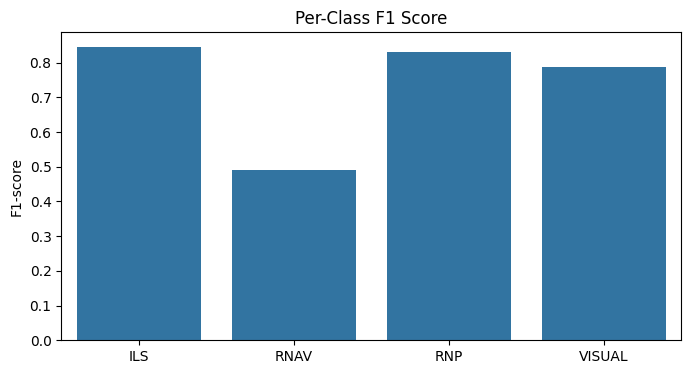

In [16]:
# per-class F1-score bar chart
report = classification_report(y_test, y_pred, output_dict=True)
f1_scores = [report[str(i)]['f1-score'] for i in range(len(label_columns))]
plt.figure(figsize=(8,4))
sns.barplot(x=label_columns, y=f1_scores)
plt.title("Per-Class F1 Score")
plt.ylabel("F1-score")
plt.show()

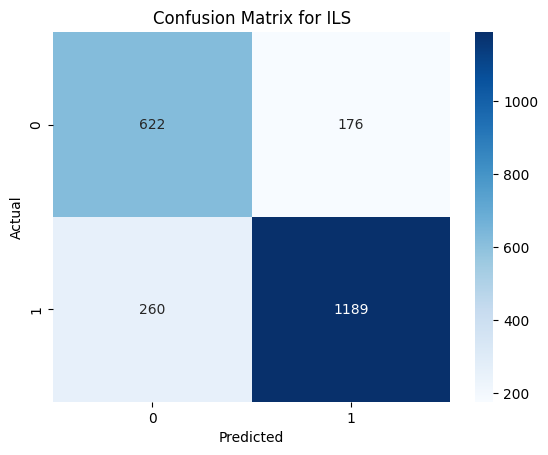

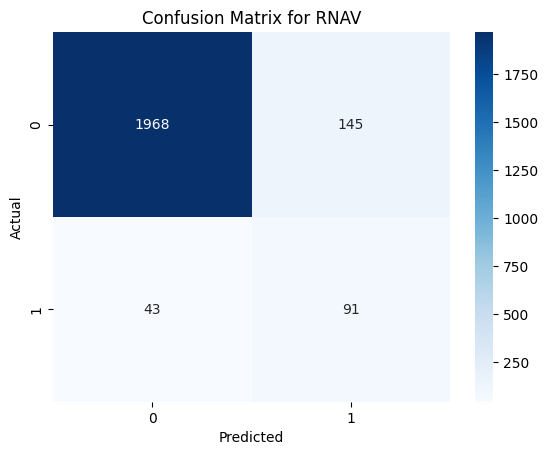

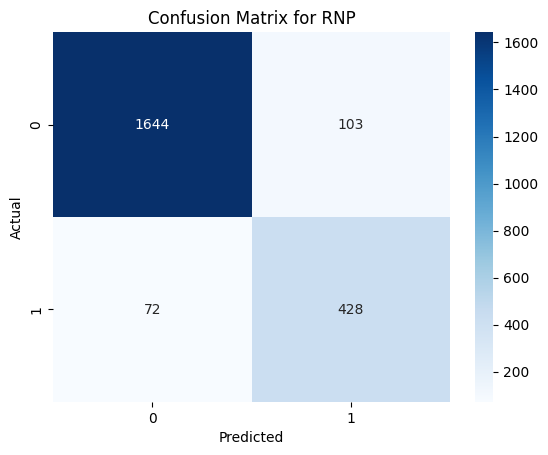

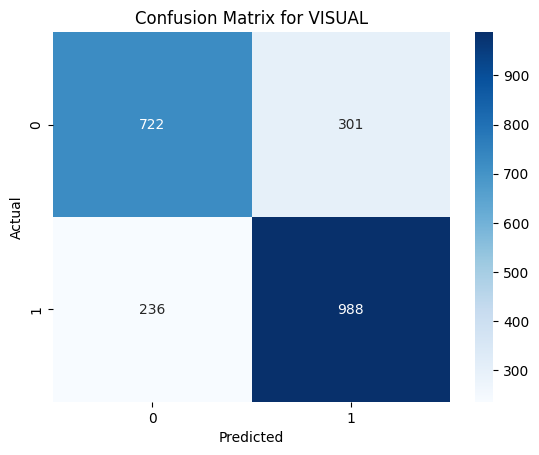

In [17]:
# confusion matrix per label
cm = multilabel_confusion_matrix(y_test, y_pred)
for i, label in enumerate(label_columns):
    plt.figure()
    sns.heatmap(cm[i], annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {label}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.savefig(f"../../visualizations/confusion-matrix/no_airport_features-OVR/{label}-no_airport_features-ovr-BYS.png")
    plt.show()

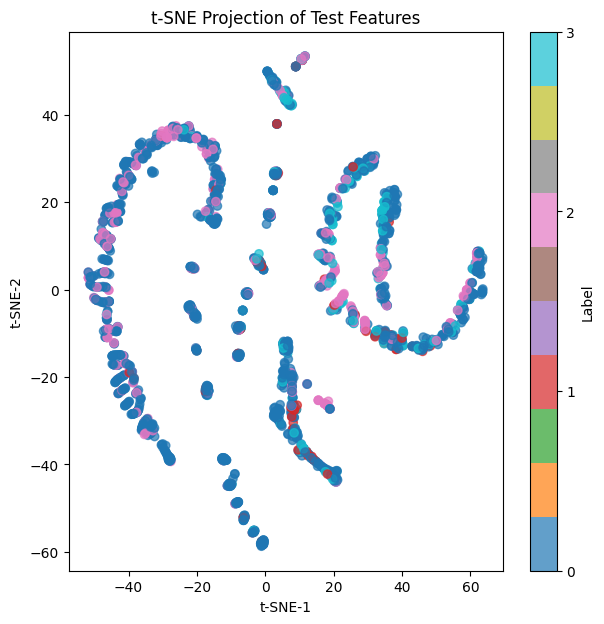

In [18]:
# t-SNE projection
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_proj = tsne.fit_transform(X_test)
dominant_label = np.argmax(y_test.values, axis=1)
plt.figure(figsize=(7,7))
plt.scatter(X_proj[:,0], X_proj[:,1], c=dominant_label, cmap='tab10', alpha=0.7)
plt.title('t-SNE Projection of Test Features')
plt.xlabel('t-SNE-1')
plt.ylabel('t-SNE-2')
plt.colorbar(ticks=range(len(label_columns)), label='Label')
plt.savefig("../../visualizations/t-SNE/no_airport_features-ovr-BYS.png")
plt.show()

SHAP summary plot for ILS


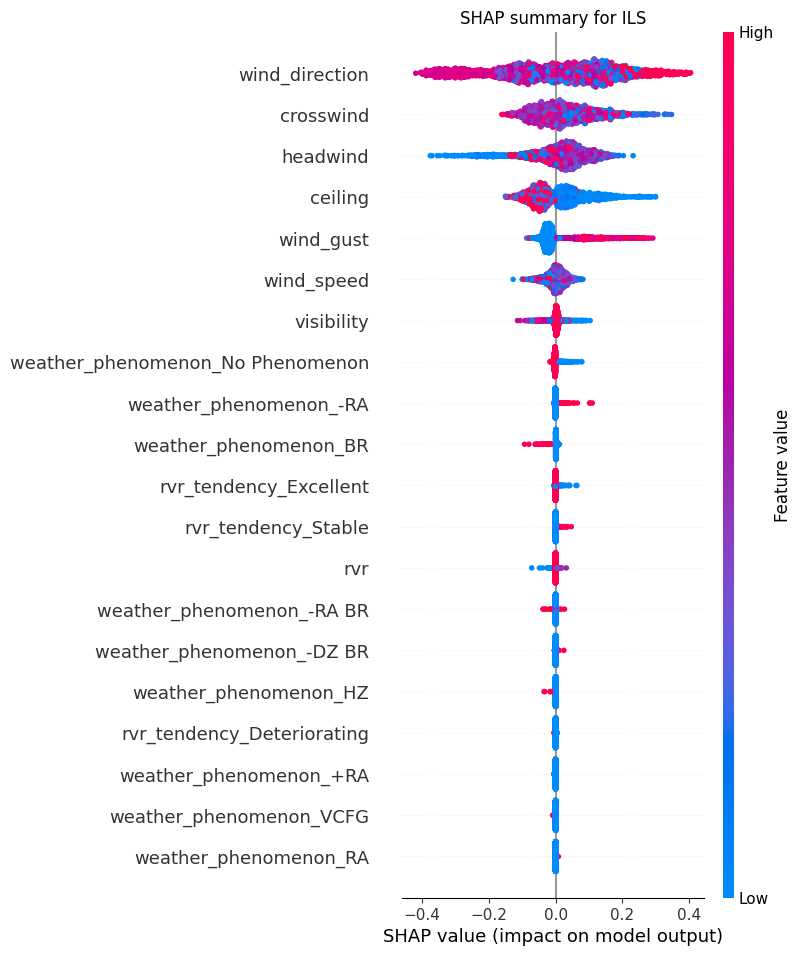

SHAP summary plot for RNAV


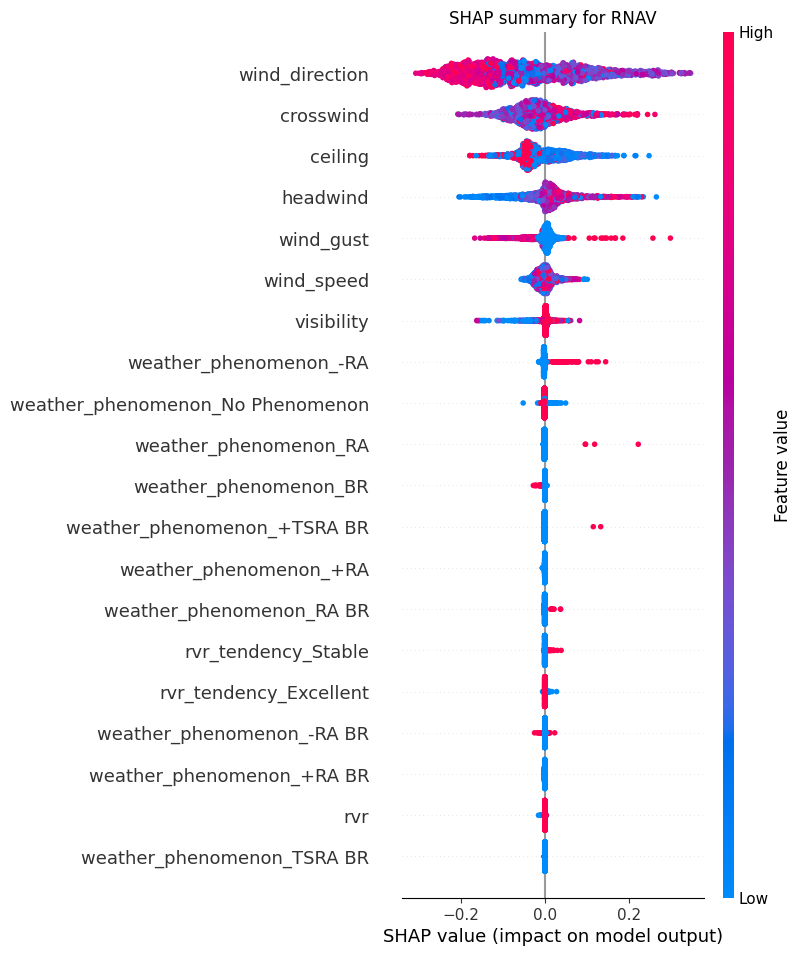

SHAP summary plot for RNP


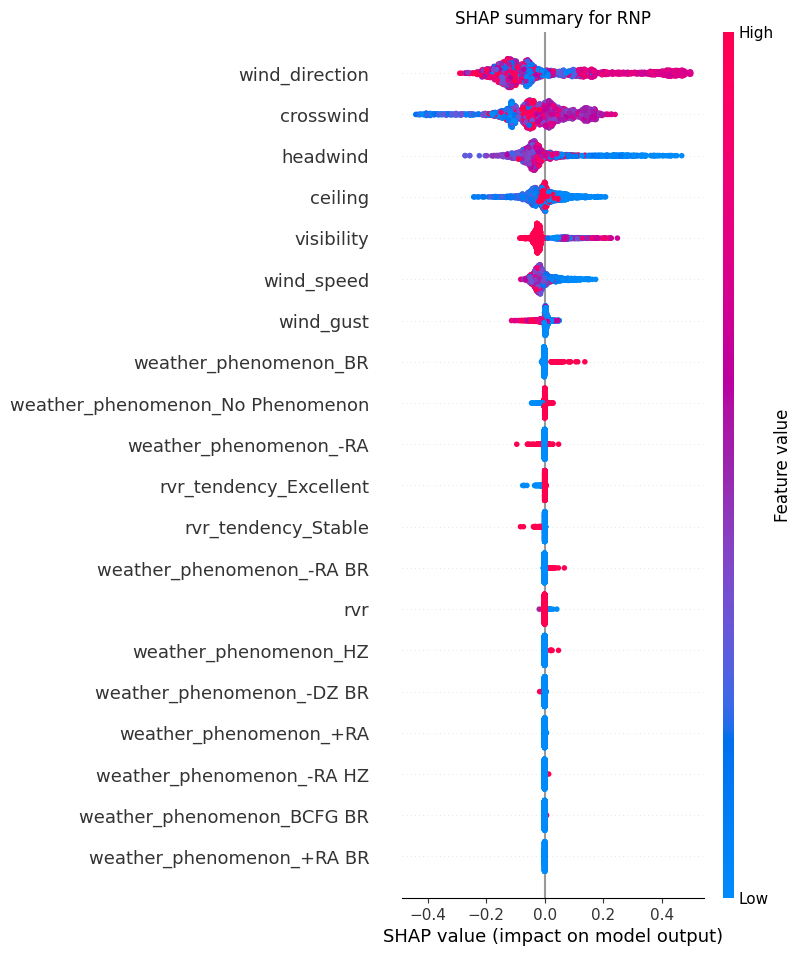

SHAP summary plot for VISUAL


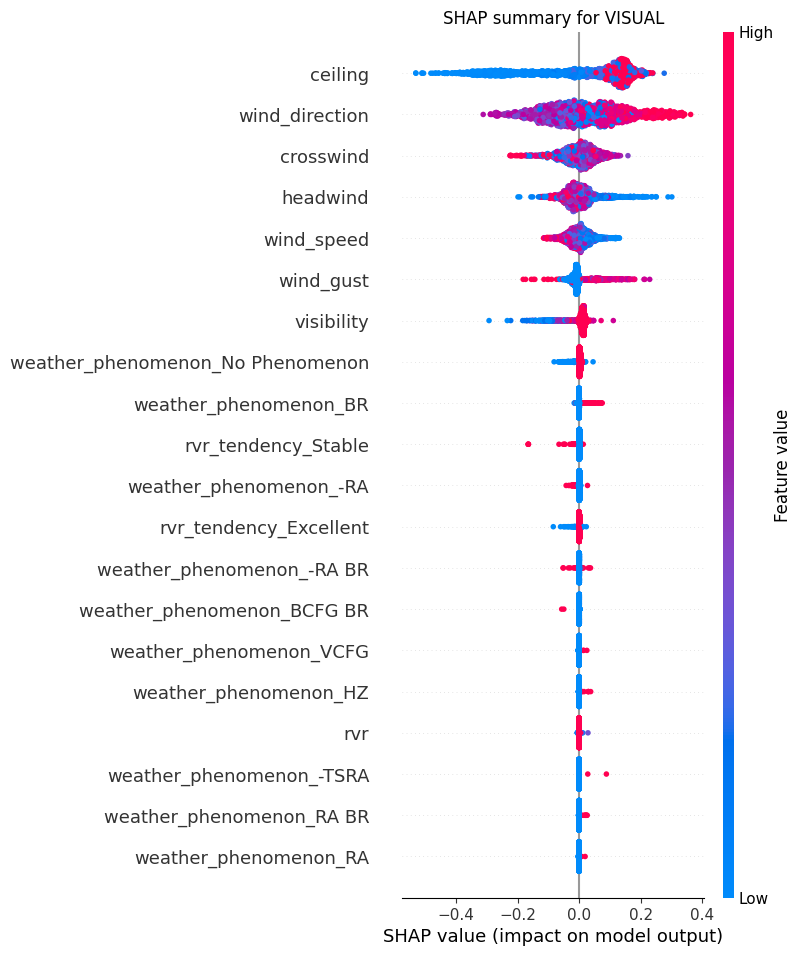

In [19]:
# SHAP summary plot per label
X_test_fixed = X_test.astype(float)

for idx, label in enumerate(label_columns):
    print(f"SHAP summary plot for {label}")
    explainer = shap.TreeExplainer(best_model.estimators_[idx])
    shap_values = explainer.shap_values(X_test_fixed)
    shap.summary_plot(shap_values[:,:,1], X_test_fixed, show=False)
    plt.title(f"SHAP summary for {label}")
    plt.savefig(f"../../visualizations/SHAP/no_airport_features-OVR/{label}-no_airport_features-ovr-BYS.png")
    plt.show()

In [20]:
# false predictions cases
for i, label in enumerate(label_columns):
    false_positives = np.where((y_test[label].values == 0) & (y_pred[:, i] == 1))[0]
    false_negatives = np.where((y_test[label].values == 1) & (y_pred[:, i] == 0))[0]
    print(f"\n{label} False Positives (max 5):")
    display(X_test.iloc[false_positives[:5]])
    print(f"{label} False Negatives (max 5):")
    display(X_test.iloc[false_negatives[:5]])


ILS False Positives (max 5):


,visibility,wind_speed,wind_gust,wind_direction,rvr,headwind,crosswind,ceiling,weather_phenomenon_+RA,weather_phenomenon_+RA BR,...,weather_phenomenon_RA,weather_phenomenon_RA BR,weather_phenomenon_TS,weather_phenomenon_TS BR,weather_phenomenon_TSRA BR,weather_phenomenon_VCFG,rvr_tendency_Deteriorating,rvr_tendency_Excellent,rvr_tendency_Improving,rvr_tendency_Stable
15773,10.0,4,0,250,6000.0,3.5,-2.0,7500,False,False,...,False,False,False,False,False,False,False,True,False,False
3759,10.0,7,0,90,6000.0,6.1,3.5,3200,False,False,...,False,False,False,False,False,False,False,True,False,False
5975,10.0,13,22,190,6000.0,4.4,-12.2,25000,False,False,...,False,False,False,False,False,False,False,True,False,False
8133,10.0,4,0,140,6000.0,2.0,3.5,22000,False,False,...,False,False,False,False,False,False,False,True,False,False
17426,10.0,12,0,230,6000.0,7.7,-9.2,1500,False,False,...,False,False,False,False,False,False,False,True,False,False


ILS False Negatives (max 5):


,visibility,wind_speed,wind_gust,wind_direction,rvr,headwind,crosswind,ceiling,weather_phenomenon_+RA,weather_phenomenon_+RA BR,...,weather_phenomenon_RA,weather_phenomenon_RA BR,weather_phenomenon_TS,weather_phenomenon_TS BR,weather_phenomenon_TSRA BR,weather_phenomenon_VCFG,rvr_tendency_Deteriorating,rvr_tendency_Excellent,rvr_tendency_Improving,rvr_tendency_Stable
20337,10.0,5,0,130,6000.0,2.5,-4.3,11000,False,False,...,False,False,False,False,False,False,False,True,False,False
4444,10.0,7,0,120,6000.0,-6.6,-2.4,10000,False,False,...,False,False,False,False,False,False,False,True,False,False
2355,10.0,4,0,240,6000.0,3.5,-2.0,99999,False,False,...,False,False,False,False,False,False,False,True,False,False
18671,10.0,4,0,110,6000.0,-3.9,-0.7,99999,False,False,...,False,False,False,False,False,False,False,True,False,False
499,7.0,9,0,250,6000.0,8.5,-3.1,10000,False,False,...,False,False,False,False,False,False,False,True,False,False



RNAV False Positives (max 5):


,visibility,wind_speed,wind_gust,wind_direction,rvr,headwind,crosswind,ceiling,weather_phenomenon_+RA,weather_phenomenon_+RA BR,...,weather_phenomenon_RA,weather_phenomenon_RA BR,weather_phenomenon_TS,weather_phenomenon_TS BR,weather_phenomenon_TSRA BR,weather_phenomenon_VCFG,rvr_tendency_Deteriorating,rvr_tendency_Excellent,rvr_tendency_Improving,rvr_tendency_Stable
20337,10.0,5,0,130,6000.0,2.5,-4.3,11000,False,False,...,False,False,False,False,False,False,False,True,False,False
16415,10.0,8,0,140,6000.0,4.0,6.9,4300,False,False,...,False,False,False,False,False,False,False,True,False,False
11943,10.0,10,0,40,6000.0,10.0,0.0,2500,False,False,...,False,False,False,False,False,False,False,True,False,False
16805,10.0,3,0,250,6000.0,-1.5,-2.6,25000,False,False,...,False,False,False,False,False,False,False,True,False,False
154,10.0,6,0,330,6000.0,4.6,-3.9,99999,False,False,...,False,False,False,False,False,False,False,True,False,False


RNAV False Negatives (max 5):


,visibility,wind_speed,wind_gust,wind_direction,rvr,headwind,crosswind,ceiling,weather_phenomenon_+RA,weather_phenomenon_+RA BR,...,weather_phenomenon_RA,weather_phenomenon_RA BR,weather_phenomenon_TS,weather_phenomenon_TS BR,weather_phenomenon_TSRA BR,weather_phenomenon_VCFG,rvr_tendency_Deteriorating,rvr_tendency_Excellent,rvr_tendency_Improving,rvr_tendency_Stable
4144,10.0,11,18,100,6000.0,-5.5,-9.5,12000,False,False,...,False,False,False,False,False,False,False,True,False,False
7167,6.0,13,24,160,6000.0,6.5,-11.3,2600,False,False,...,False,False,False,False,False,False,False,True,False,False
18434,10.0,6,0,30,6000.0,2.1,-5.6,99999,False,False,...,False,False,False,False,False,False,False,True,False,False
9937,10.0,7,0,260,6000.0,5.4,4.5,19000,False,False,...,False,False,False,False,False,False,False,True,False,False
13681,10.0,5,0,80,6000.0,5.0,0.0,99999,False,False,...,False,False,False,False,False,False,False,True,False,False



RNP False Positives (max 5):


,visibility,wind_speed,wind_gust,wind_direction,rvr,headwind,crosswind,ceiling,weather_phenomenon_+RA,weather_phenomenon_+RA BR,...,weather_phenomenon_RA,weather_phenomenon_RA BR,weather_phenomenon_TS,weather_phenomenon_TS BR,weather_phenomenon_TSRA BR,weather_phenomenon_VCFG,rvr_tendency_Deteriorating,rvr_tendency_Excellent,rvr_tendency_Improving,rvr_tendency_Stable
4444,10.00,7,0,120,6000.0,-6.6,-2.4,10000,False,False,...,False,False,False,False,False,False,False,True,False,False
12891,10.00,13,0,250,6000.0,12.8,-2.3,99999,False,False,...,False,False,False,False,False,False,False,True,False,False
2355,10.00,4,0,240,6000.0,3.5,-2.0,99999,False,False,...,False,False,False,False,False,False,False,True,False,False
9700,0.75,6,0,120,6000.0,-1.0,-5.9,800,False,False,...,False,False,False,False,False,False,False,True,False,False
499,7.00,9,0,250,6000.0,8.5,-3.1,10000,False,False,...,False,False,False,False,False,False,False,True,False,False


RNP False Negatives (max 5):


,visibility,wind_speed,wind_gust,wind_direction,rvr,headwind,crosswind,ceiling,weather_phenomenon_+RA,weather_phenomenon_+RA BR,...,weather_phenomenon_RA,weather_phenomenon_RA BR,weather_phenomenon_TS,weather_phenomenon_TS BR,weather_phenomenon_TSRA BR,weather_phenomenon_VCFG,rvr_tendency_Deteriorating,rvr_tendency_Excellent,rvr_tendency_Improving,rvr_tendency_Stable
3349,10.0,3,0,280,6000.0,2.6,1.5,99999,False,False,...,False,False,False,False,False,False,False,True,False,False
3759,10.0,7,0,90,6000.0,6.1,3.5,3200,False,False,...,False,False,False,False,False,False,False,True,False,False
8701,10.0,4,0,260,6000.0,3.8,1.4,5500,False,False,...,False,False,False,False,False,False,False,True,False,False
15232,10.0,5,0,340,6000.0,-0.9,4.9,1500,False,False,...,False,False,False,False,False,False,False,True,False,False
3828,10.0,7,0,60,6000.0,6.9,-1.2,99999,False,False,...,False,False,False,False,False,False,False,True,False,False



VISUAL False Positives (max 5):


,visibility,wind_speed,wind_gust,wind_direction,rvr,headwind,crosswind,ceiling,weather_phenomenon_+RA,weather_phenomenon_+RA BR,...,weather_phenomenon_RA,weather_phenomenon_RA BR,weather_phenomenon_TS,weather_phenomenon_TS BR,weather_phenomenon_TSRA BR,weather_phenomenon_VCFG,rvr_tendency_Deteriorating,rvr_tendency_Excellent,rvr_tendency_Improving,rvr_tendency_Stable
4444,10.0,7,0,120,6000.0,-6.6,-2.4,10000,False,False,...,False,False,False,False,False,False,False,True,False,False
12013,10.0,14,0,70,6000.0,12.1,7.0,4300,False,False,...,False,False,False,False,False,False,False,True,False,False
4144,10.0,11,18,100,6000.0,-5.5,-9.5,12000,False,False,...,False,False,False,False,False,False,False,True,False,False
1946,10.0,8,0,200,6000.0,4.0,-6.9,99999,False,False,...,False,False,False,False,False,False,False,True,False,False
3962,10.0,11,0,40,6000.0,11.0,0.0,8500,False,False,...,False,False,False,False,False,False,False,True,False,False


VISUAL False Negatives (max 5):


,visibility,wind_speed,wind_gust,wind_direction,rvr,headwind,crosswind,ceiling,weather_phenomenon_+RA,weather_phenomenon_+RA BR,...,weather_phenomenon_RA,weather_phenomenon_RA BR,weather_phenomenon_TS,weather_phenomenon_TS BR,weather_phenomenon_TSRA BR,weather_phenomenon_VCFG,rvr_tendency_Deteriorating,rvr_tendency_Excellent,rvr_tendency_Improving,rvr_tendency_Stable
20337,10.0,5,0,130,6000.0,2.5,-4.3,11000,False,False,...,False,False,False,False,False,False,False,True,False,False
15773,10.0,4,0,250,6000.0,3.5,-2.0,7500,False,False,...,False,False,False,False,False,False,False,True,False,False
1556,10.0,18,0,240,6000.0,17.7,-3.1,99999,False,False,...,False,False,False,False,False,False,False,True,False,False
16415,10.0,8,0,140,6000.0,4.0,6.9,4300,False,False,...,False,False,False,False,False,False,False,True,False,False
3759,10.0,7,0,90,6000.0,6.1,3.5,3200,False,False,...,False,False,False,False,False,False,False,True,False,False
